In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, 2, 2) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price #買入成本 = 今天收盤
                    Sold = last_trade_price #賣出成本 = 明天開盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本




                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price #買入成本 = 明天開盤
                    Sold = current_price #賣出成本 = 今天收盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price
                    Sold = last_trade_price

                    price_diff = Sold - Buy#最後賺到的錢
                    long_profit_percentage = (Sold - Buy)/Buy
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price
                    Sold = current_price

                    price_diff = Sold - Buy#最後賺到的錢
                    short_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('TSLA', str):
    # load it from yahoo_fin library
    df = si.get_data('TSLA')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2010-07-27,1.394,1.412,1.351,1.370,1.370,9295500,TSLA,1.267,1.483,...,68.083,65.280,69.781,-0.027,-0.049,1.623,1.325,1.026,0,1
1,2010-07-28,1.370,1.393,1.367,1.381,1.381,7008000,TSLA,1.300,1.483,...,71.512,58.308,65.957,-0.023,-0.044,1.588,1.314,1.041,0,1
2,2010-07-29,1.385,1.392,1.333,1.357,1.357,9240000,TSLA,1.300,1.483,...,64.149,49.175,60.363,-0.023,-0.040,1.547,1.303,1.058,0,1
3,2010-07-30,1.347,1.363,1.303,1.329,1.329,6403500,TSLA,1.300,1.457,...,50.767,39.025,53.250,-0.024,-0.036,1.529,1.296,1.063,0,1
4,2010-08-02,1.367,1.398,1.355,1.395,1.395,10771500,TSLA,1.300,1.437,...,56.913,48.994,51.831,-0.019,-0.033,1.539,1.302,1.065,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167,2023-02-24,196.330,197.670,192.800,196.880,196.880,142228100,TSLA,187.610,217.650,...,50.043,44.797,55.241,12.738,14.454,219.162,195.008,170.855,0,1
3168,2023-02-27,202.030,209.420,201.260,207.630,207.630,161028300,TSLA,189.440,217.650,...,53.588,51.358,53.947,12.556,14.074,219.902,196.495,173.088,0,1
3169,2023-02-28,210.590,211.230,203.750,205.710,205.710,153144900,TSLA,191.780,217.650,...,49.045,52.188,53.361,12.116,13.683,217.724,198.448,179.171,0,1
3170,2023-03-01,206.210,207.200,198.520,202.770,202.770,156852800,TSLA,191.780,217.650,...,53.830,48.952,51.891,11.399,13.226,215.394,199.925,184.456,0,1


# 查找DF的標籤

In [7]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

2375

In [8]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

3130

In [9]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
2375,2020-01-02,28.300,28.713,28.114,28.684,28.684,142981500,TSLA,26.433,29.021,...,82.856,82.094,85.263,1.671,1.507,30.421,25.636,20.850,0,1
2376,2020-01-03,29.367,30.267,29.128,29.534,29.534,266677500,TSLA,26.679,30.267,...,81.063,81.255,83.927,1.731,1.552,30.803,26.003,21.202,1,0
2377,2020-01-06,29.365,30.104,29.333,30.103,30.103,151995000,TSLA,26.805,30.267,...,84.538,85.924,84.593,1.804,1.602,31.159,26.406,21.654,0,1
2378,2020-01-07,30.760,31.442,30.224,31.271,31.271,268231500,TSLA,26.805,31.442,...,85.017,89.384,86.190,1.933,1.668,31.679,26.850,22.022,1,0
2379,2020-01-08,31.580,33.233,31.215,32.809,32.809,467164500,TSLA,26.805,33.233,...,86.532,90.727,87.702,2.135,1.762,32.441,27.359,22.277,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,2022-12-23,126.370,128.620,121.020,123.150,123.150,166989700,TSLA,121.020,175.050,...,10.149,4.965,7.012,-17.245,-13.665,208.812,165.201,121.590,1,0
3127,2022-12-27,117.500,119.670,108.760,109.100,109.100,208643400,TSLA,108.760,161.620,...,8.383,3.524,5.849,-19.073,-14.747,210.643,161.510,112.377,1,0
3128,2022-12-28,110.350,116.270,108.240,112.710,112.710,221070500,TSLA,108.240,160.990,...,5.950,5.174,5.624,-20.000,-15.797,210.728,158.104,105.480,1,0
3129,2022-12-29,120.390,123.570,117.500,121.820,121.820,221923300,TSLA,108.240,160.990,...,18.571,12.031,7.760,-19.772,-16.592,206.533,154.460,102.387,1,0


In [10]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['K_Value', 'D_Value', 'MACD', 'DIF']].to_numpy()[start:end]#抓取特徵資料
    signal_features = signal_features.reshape(len(signal_features), 2, 2)#變成[['FL','FH'],['UpLine', 'DownLine']]
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.621    |
| fps                | 1        |
| nupdates           | 1        |
| policy_entropy     | 0.683    |
| total_timesteps    | 5        |
| value_loss         | 0.015    |
---------------------------------
---------------------------------
| explained_variance | -0.126   |
| fps                | 71       |
| nupdates           | 100      |
| policy_entropy     | 0.671    |
| total_timesteps    | 500      |
| value_loss         | 0.0124   |
---------------------------------
---------------------------------
| explained_variance | 0.54   

---------------------------------
| explained_variance | -0.00424 |
| fps                | 131      |
| nupdates           | 1500     |
| policy_entropy     | 0.343    |
| total_timesteps    | 7500     |
| value_loss         | 14.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00521 |
| fps                | 131      |
| nupdates           | 1600     |
| policy_entropy     | 0.0961   |
| total_timesteps    | 8000     |
| value_loss         | 23.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0242  |
| fps                | 132      |
| nupdates           | 1700     |
| policy_entropy     | 0.318    |
| total_timesteps    | 8500     |
| value_loss         | 0.485    |
---------------------------------
---------------------------------
| explained_variance | -0.0308  |
| fps                | 133      |
| nupdates           | 1800     |
| policy_entropy     | 0.0815   |
| total_timest

---------------------------------
| explained_variance | -0.211   |
| fps                | 139      |
| nupdates           | 4600     |
| policy_entropy     | 0.0226   |
| total_timesteps    | 23000    |
| value_loss         | 0.0557   |
---------------------------------
---------------------------------
| explained_variance | 0.0257   |
| fps                | 139      |
| nupdates           | 4700     |
| policy_entropy     | 0.0131   |
| total_timesteps    | 23500    |
| value_loss         | 3.64     |
---------------------------------
---------------------------------
| explained_variance | 0.00156  |
| fps                | 139      |
| nupdates           | 4800     |
| policy_entropy     | 0.0109   |
| total_timesteps    | 24000    |
| value_loss         | 96       |
---------------------------------
---------------------------------
| explained_variance | 0.722    |
| fps                | 139      |
| nupdates           | 4900     |
| policy_entropy     | 0.0323   |
| total_timest

---------------------------------
| explained_variance | 0.302    |
| fps                | 142      |
| nupdates           | 7700     |
| policy_entropy     | 0.00474  |
| total_timesteps    | 38500    |
| value_loss         | 0.0198   |
---------------------------------
---------------------------------
| explained_variance | 0.147    |
| fps                | 142      |
| nupdates           | 7800     |
| policy_entropy     | 0.00522  |
| total_timesteps    | 39000    |
| value_loss         | 0.0106   |
---------------------------------
---------------------------------
| explained_variance | 0.00462  |
| fps                | 142      |
| nupdates           | 7900     |
| policy_entropy     | 0.0076   |
| total_timesteps    | 39500    |
| value_loss         | 0.122    |
---------------------------------
---------------------------------
| explained_variance | 0.0111   |
| fps                | 142      |
| nupdates           | 8000     |
| policy_entropy     | 0.00705  |
| total_timest

---------------------------------
| explained_variance | 0.00111  |
| fps                | 144      |
| nupdates           | 10800    |
| policy_entropy     | 0.00466  |
| total_timesteps    | 54000    |
| value_loss         | 0.914    |
---------------------------------
---------------------------------
| explained_variance | 0.463    |
| fps                | 144      |
| nupdates           | 10900    |
| policy_entropy     | 0.00467  |
| total_timesteps    | 54500    |
| value_loss         | 0.207    |
---------------------------------
---------------------------------
| explained_variance | 0.0245   |
| fps                | 144      |
| nupdates           | 11000    |
| policy_entropy     | 0.00451  |
| total_timesteps    | 55000    |
| value_loss         | 0.39     |
---------------------------------
---------------------------------
| explained_variance | 0.0329   |
| fps                | 144      |
| nupdates           | 11100    |
| policy_entropy     | 0.00852  |
| total_timest

---------------------------------
| explained_variance | -0.244   |
| fps                | 145      |
| nupdates           | 13900    |
| policy_entropy     | 0.00142  |
| total_timesteps    | 69500    |
| value_loss         | 0.326    |
---------------------------------
---------------------------------
| explained_variance | 0.00233  |
| fps                | 145      |
| nupdates           | 14000    |
| policy_entropy     | 0.000891 |
| total_timesteps    | 70000    |
| value_loss         | 28       |
---------------------------------
---------------------------------
| explained_variance | -0.0977  |
| fps                | 145      |
| nupdates           | 14100    |
| policy_entropy     | 0.00121  |
| total_timesteps    | 70500    |
| value_loss         | 1.24     |
---------------------------------
---------------------------------
| explained_variance | -0.0678  |
| fps                | 145      |
| nupdates           | 14200    |
| policy_entropy     | 0.00168  |
| total_timest

---------------------------------
| explained_variance | 0.604    |
| fps                | 146      |
| nupdates           | 17000    |
| policy_entropy     | 0.00549  |
| total_timesteps    | 85000    |
| value_loss         | 0.0149   |
---------------------------------
---------------------------------
| explained_variance | 0.218    |
| fps                | 146      |
| nupdates           | 17100    |
| policy_entropy     | 0.00287  |
| total_timesteps    | 85500    |
| value_loss         | 0.0458   |
---------------------------------
---------------------------------
| explained_variance | -0.014   |
| fps                | 146      |
| nupdates           | 17200    |
| policy_entropy     | 0.00193  |
| total_timesteps    | 86000    |
| value_loss         | 26.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00133 |
| fps                | 146      |
| nupdates           | 17300    |
| policy_entropy     | 0.00149  |
| total_timest

---------------------------------
| explained_variance | 0.00224  |
| fps                | 147      |
| nupdates           | 20100    |
| policy_entropy     | 0.0126   |
| total_timesteps    | 100500   |
| value_loss         | 6.25     |
---------------------------------
---------------------------------
| explained_variance | -0.0313  |
| fps                | 147      |
| nupdates           | 20200    |
| policy_entropy     | 0.265    |
| total_timesteps    | 101000   |
| value_loss         | 0.235    |
---------------------------------
---------------------------------
| explained_variance | -0.608   |
| fps                | 147      |
| nupdates           | 20300    |
| policy_entropy     | 0.0424   |
| total_timesteps    | 101500   |
| value_loss         | 0.301    |
---------------------------------
---------------------------------
| explained_variance | 0.0338   |
| fps                | 147      |
| nupdates           | 20400    |
| policy_entropy     | 0.526    |
| total_timest

---------------------------------
| explained_variance | -0.222   |
| fps                | 147      |
| nupdates           | 23200    |
| policy_entropy     | 0.471    |
| total_timesteps    | 116000   |
| value_loss         | 0.0367   |
---------------------------------
---------------------------------
| explained_variance | 0.0024   |
| fps                | 147      |
| nupdates           | 23300    |
| policy_entropy     | 0.0912   |
| total_timesteps    | 116500   |
| value_loss         | 31.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0486   |
| fps                | 147      |
| nupdates           | 23400    |
| policy_entropy     | 0.23     |
| total_timesteps    | 117000   |
| value_loss         | 0.158    |
---------------------------------
---------------------------------
| explained_variance | -0.199   |
| fps                | 147      |
| nupdates           | 23500    |
| policy_entropy     | 0.0969   |
| total_timest

---------------------------------
| explained_variance | 0.232    |
| fps                | 148      |
| nupdates           | 26300    |
| policy_entropy     | 0.311    |
| total_timesteps    | 131500   |
| value_loss         | 0.0174   |
---------------------------------
---------------------------------
| explained_variance | -0.0171  |
| fps                | 148      |
| nupdates           | 26400    |
| policy_entropy     | 0.185    |
| total_timesteps    | 132000   |
| value_loss         | 0.518    |
---------------------------------
---------------------------------
| explained_variance | 0.0214   |
| fps                | 148      |
| nupdates           | 26500    |
| policy_entropy     | 0.0956   |
| total_timesteps    | 132500   |
| value_loss         | 34.9     |
---------------------------------
---------------------------------
| explained_variance | -0.25    |
| fps                | 148      |
| nupdates           | 26600    |
| policy_entropy     | 0.181    |
| total_timest

---------------------------------
| explained_variance | 0.215    |
| fps                | 148      |
| nupdates           | 29400    |
| policy_entropy     | 0.0214   |
| total_timesteps    | 147000   |
| value_loss         | 8.49     |
---------------------------------
---------------------------------
| explained_variance | 0.658    |
| fps                | 148      |
| nupdates           | 29500    |
| policy_entropy     | 0.0163   |
| total_timesteps    | 147500   |
| value_loss         | 0.00199  |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 148      |
| nupdates           | 29600    |
| policy_entropy     | 0.0242   |
| total_timesteps    | 148000   |
| value_loss         | 0.0226   |
---------------------------------
---------------------------------
| explained_variance | 0.0117   |
| fps                | 148      |
| nupdates           | 29700    |
| policy_entropy     | 0.0404   |
| total_timest

---------------------------------
| explained_variance | 0.179    |
| fps                | 148      |
| nupdates           | 32500    |
| policy_entropy     | 0.00373  |
| total_timesteps    | 162500   |
| value_loss         | 0.103    |
---------------------------------
---------------------------------
| explained_variance | -0.00581 |
| fps                | 148      |
| nupdates           | 32600    |
| policy_entropy     | 0.00306  |
| total_timesteps    | 163000   |
| value_loss         | 23.4     |
---------------------------------
---------------------------------
| explained_variance | 0.164    |
| fps                | 148      |
| nupdates           | 32700    |
| policy_entropy     | 0.00478  |
| total_timesteps    | 163500   |
| value_loss         | 0.00456  |
---------------------------------
---------------------------------
| explained_variance | 0.035    |
| fps                | 148      |
| nupdates           | 32800    |
| policy_entropy     | 0.00648  |
| total_timest

---------------------------------
| explained_variance | -1.33    |
| fps                | 148      |
| nupdates           | 35600    |
| policy_entropy     | 0.119    |
| total_timesteps    | 178000   |
| value_loss         | 0.027    |
---------------------------------
---------------------------------
| explained_variance | -0.00602 |
| fps                | 148      |
| nupdates           | 35700    |
| policy_entropy     | 0.127    |
| total_timesteps    | 178500   |
| value_loss         | 1.66     |
---------------------------------
---------------------------------
| explained_variance | -0.0382  |
| fps                | 148      |
| nupdates           | 35800    |
| policy_entropy     | 0.061    |
| total_timesteps    | 179000   |
| value_loss         | 71.8     |
---------------------------------
---------------------------------
| explained_variance | 0.161    |
| fps                | 148      |
| nupdates           | 35900    |
| policy_entropy     | 0.208    |
| total_timest

---------------------------------
| explained_variance | -4.88    |
| fps                | 149      |
| nupdates           | 38700    |
| policy_entropy     | 0.113    |
| total_timesteps    | 193500   |
| value_loss         | 0.239    |
---------------------------------
---------------------------------
| explained_variance | -0.00712 |
| fps                | 149      |
| nupdates           | 38800    |
| policy_entropy     | 0.102    |
| total_timesteps    | 194000   |
| value_loss         | 0.0253   |
---------------------------------
---------------------------------
| explained_variance | -0.189   |
| fps                | 149      |
| nupdates           | 38900    |
| policy_entropy     | 0.272    |
| total_timesteps    | 194500   |
| value_loss         | 0.101    |
---------------------------------
---------------------------------
| explained_variance | -0.0624  |
| fps                | 149      |
| nupdates           | 39000    |
| policy_entropy     | 0.0754   |
| total_timest

---------------------------------
| explained_variance | 0.00829  |
| fps                | 149      |
| nupdates           | 41800    |
| policy_entropy     | 0.0837   |
| total_timesteps    | 209000   |
| value_loss         | 278      |
---------------------------------
---------------------------------
| explained_variance | -2.39    |
| fps                | 149      |
| nupdates           | 41900    |
| policy_entropy     | 0.0436   |
| total_timesteps    | 209500   |
| value_loss         | 0.206    |
---------------------------------
---------------------------------
| explained_variance | -0.196   |
| fps                | 149      |
| nupdates           | 42000    |
| policy_entropy     | 0.054    |
| total_timesteps    | 210000   |
| value_loss         | 0.21     |
---------------------------------
---------------------------------
| explained_variance | 0.044    |
| fps                | 149      |
| nupdates           | 42100    |
| policy_entropy     | 0.0942   |
| total_timest

---------------------------------
| explained_variance | -0.0246  |
| fps                | 149      |
| nupdates           | 44900    |
| policy_entropy     | 0.527    |
| total_timesteps    | 224500   |
| value_loss         | 6.98     |
---------------------------------
---------------------------------
| explained_variance | 0.0164   |
| fps                | 149      |
| nupdates           | 45000    |
| policy_entropy     | 0.18     |
| total_timesteps    | 225000   |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0214   |
| fps                | 149      |
| nupdates           | 45100    |
| policy_entropy     | 0.132    |
| total_timesteps    | 225500   |
| value_loss         | 91.6     |
---------------------------------
---------------------------------
| explained_variance | -1.17    |
| fps                | 149      |
| nupdates           | 45200    |
| policy_entropy     | 0.159    |
| total_timest

---------------------------------
| explained_variance | 0.408    |
| fps                | 149      |
| nupdates           | 48000    |
| policy_entropy     | 0.0885   |
| total_timesteps    | 240000   |
| value_loss         | 0.0125   |
---------------------------------
---------------------------------
| explained_variance | -0.565   |
| fps                | 149      |
| nupdates           | 48100    |
| policy_entropy     | 0.109    |
| total_timesteps    | 240500   |
| value_loss         | 0.0925   |
---------------------------------
---------------------------------
| explained_variance | -0.00269 |
| fps                | 149      |
| nupdates           | 48200    |
| policy_entropy     | 0.171    |
| total_timesteps    | 241000   |
| value_loss         | 0.721    |
---------------------------------
---------------------------------
| explained_variance | -0.0369  |
| fps                | 149      |
| nupdates           | 48300    |
| policy_entropy     | 0.0756   |
| total_timest

---------------------------------
| explained_variance | 0.0051   |
| fps                | 149      |
| nupdates           | 51100    |
| policy_entropy     | 0.0472   |
| total_timesteps    | 255500   |
| value_loss         | 212      |
---------------------------------
---------------------------------
| explained_variance | 0.134    |
| fps                | 149      |
| nupdates           | 51200    |
| policy_entropy     | 0.0509   |
| total_timesteps    | 256000   |
| value_loss         | 0.0411   |
---------------------------------
---------------------------------
| explained_variance | 0.71     |
| fps                | 149      |
| nupdates           | 51300    |
| policy_entropy     | 0.0979   |
| total_timesteps    | 256500   |
| value_loss         | 0.119    |
---------------------------------
---------------------------------
| explained_variance | 0.127    |
| fps                | 149      |
| nupdates           | 51400    |
| policy_entropy     | 0.326    |
| total_timest

---------------------------------
| explained_variance | 0.148    |
| fps                | 149      |
| nupdates           | 54200    |
| policy_entropy     | 0.666    |
| total_timesteps    | 271000   |
| value_loss         | 0.0274   |
---------------------------------
---------------------------------
| explained_variance | 0.0131   |
| fps                | 149      |
| nupdates           | 54300    |
| policy_entropy     | 0.157    |
| total_timesteps    | 271500   |
| value_loss         | 0.714    |
---------------------------------
---------------------------------
| explained_variance | -0.465   |
| fps                | 149      |
| nupdates           | 54400    |
| policy_entropy     | 0.0552   |
| total_timesteps    | 272000   |
| value_loss         | 0.05     |
---------------------------------
---------------------------------
| explained_variance | -2.02    |
| fps                | 149      |
| nupdates           | 54500    |
| policy_entropy     | 0.0497   |
| total_timest

---------------------------------
| explained_variance | -0.0362  |
| fps                | 149      |
| nupdates           | 57300    |
| policy_entropy     | 0.0901   |
| total_timesteps    | 286500   |
| value_loss         | 0.00743  |
---------------------------------
---------------------------------
| explained_variance | 0.169    |
| fps                | 149      |
| nupdates           | 57400    |
| policy_entropy     | 0.0363   |
| total_timesteps    | 287000   |
| value_loss         | 0.154    |
---------------------------------
---------------------------------
| explained_variance | -0.00127 |
| fps                | 149      |
| nupdates           | 57500    |
| policy_entropy     | 0.0355   |
| total_timesteps    | 287500   |
| value_loss         | 18.1     |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 149      |
| nupdates           | 57600    |
| policy_entropy     | 0.0267   |
| total_timest

---------------------------------
| explained_variance | 0.0316   |
| fps                | 149      |
| nupdates           | 60400    |
| policy_entropy     | 0.017    |
| total_timesteps    | 302000   |
| value_loss         | 236      |
---------------------------------
---------------------------------
| explained_variance | -0.405   |
| fps                | 149      |
| nupdates           | 60500    |
| policy_entropy     | 0.0269   |
| total_timesteps    | 302500   |
| value_loss         | 0.00189  |
---------------------------------
---------------------------------
| explained_variance | -0.862   |
| fps                | 149      |
| nupdates           | 60600    |
| policy_entropy     | 0.0593   |
| total_timesteps    | 303000   |
| value_loss         | 0.0553   |
---------------------------------
---------------------------------
| explained_variance | -0.0148  |
| fps                | 149      |
| nupdates           | 60700    |
| policy_entropy     | 0.067    |
| total_timest

---------------------------------
| explained_variance | 0.0263   |
| fps                | 149      |
| nupdates           | 63500    |
| policy_entropy     | 0.0824   |
| total_timesteps    | 317500   |
| value_loss         | 9.43     |
---------------------------------
---------------------------------
| explained_variance | 0.0497   |
| fps                | 149      |
| nupdates           | 63600    |
| policy_entropy     | 0.0245   |
| total_timesteps    | 318000   |
| value_loss         | 104      |
---------------------------------
---------------------------------
| explained_variance | -0.281   |
| fps                | 149      |
| nupdates           | 63700    |
| policy_entropy     | 0.027    |
| total_timesteps    | 318500   |
| value_loss         | 0.199    |
---------------------------------
---------------------------------
| explained_variance | 0.455    |
| fps                | 149      |
| nupdates           | 63800    |
| policy_entropy     | 0.0737   |
| total_timest

---------------------------------
| explained_variance | 0.39     |
| fps                | 149      |
| nupdates           | 66600    |
| policy_entropy     | 0.118    |
| total_timesteps    | 333000   |
| value_loss         | 0.096    |
---------------------------------
---------------------------------
| explained_variance | 0.629    |
| fps                | 149      |
| nupdates           | 66700    |
| policy_entropy     | 0.136    |
| total_timesteps    | 333500   |
| value_loss         | 0.0159   |
---------------------------------
---------------------------------
| explained_variance | 0.0068   |
| fps                | 149      |
| nupdates           | 66800    |
| policy_entropy     | 0.0291   |
| total_timesteps    | 334000   |
| value_loss         | 79.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0192   |
| fps                | 149      |
| nupdates           | 66900    |
| policy_entropy     | 0.0515   |
| total_timest

---------------------------------
| explained_variance | -10.2    |
| fps                | 149      |
| nupdates           | 69700    |
| policy_entropy     | 0.0412   |
| total_timesteps    | 348500   |
| value_loss         | 0.0389   |
---------------------------------
---------------------------------
| explained_variance | -0.118   |
| fps                | 149      |
| nupdates           | 69800    |
| policy_entropy     | 0.0662   |
| total_timesteps    | 349000   |
| value_loss         | 0.0112   |
---------------------------------
---------------------------------
| explained_variance | 0.0599   |
| fps                | 149      |
| nupdates           | 69900    |
| policy_entropy     | 0.243    |
| total_timesteps    | 349500   |
| value_loss         | 0.0247   |
---------------------------------
---------------------------------
| explained_variance | 0.00125  |
| fps                | 149      |
| nupdates           | 70000    |
| policy_entropy     | 0.051    |
| total_timest

---------------------------------
| explained_variance | 0.0248   |
| fps                | 149      |
| nupdates           | 72800    |
| policy_entropy     | 0.0223   |
| total_timesteps    | 364000   |
| value_loss         | 285      |
---------------------------------
---------------------------------
| explained_variance | -0.0172  |
| fps                | 149      |
| nupdates           | 72900    |
| policy_entropy     | 0.0277   |
| total_timesteps    | 364500   |
| value_loss         | 32.2     |
---------------------------------
---------------------------------
| explained_variance | 0.232    |
| fps                | 149      |
| nupdates           | 73000    |
| policy_entropy     | 0.0244   |
| total_timesteps    | 365000   |
| value_loss         | 0.0586   |
---------------------------------
---------------------------------
| explained_variance | -0.0688  |
| fps                | 149      |
| nupdates           | 73100    |
| policy_entropy     | 0.0401   |
| total_timest

---------------------------------
| explained_variance | 0.156    |
| fps                | 149      |
| nupdates           | 75900    |
| policy_entropy     | 0.322    |
| total_timesteps    | 379500   |
| value_loss         | 1.29     |
---------------------------------
----------------------------------
| explained_variance | -0.000246 |
| fps                | 149       |
| nupdates           | 76000     |
| policy_entropy     | 0.4       |
| total_timesteps    | 380000    |
| value_loss         | 6.51      |
----------------------------------
---------------------------------
| explained_variance | 0.00177  |
| fps                | 149      |
| nupdates           | 76100    |
| policy_entropy     | 0.444    |
| total_timesteps    | 380500   |
| value_loss         | 273      |
---------------------------------
---------------------------------
| explained_variance | -10.3    |
| fps                | 149      |
| nupdates           | 76200    |
| policy_entropy     | 0.0976   |
| tota

---------------------------------
| explained_variance | -0.0642  |
| fps                | 149      |
| nupdates           | 79000    |
| policy_entropy     | 0.0211   |
| total_timesteps    | 395000   |
| value_loss         | 0.418    |
---------------------------------
---------------------------------
| explained_variance | -1.38    |
| fps                | 149      |
| nupdates           | 79100    |
| policy_entropy     | 0.0227   |
| total_timesteps    | 395500   |
| value_loss         | 0.00429  |
---------------------------------
---------------------------------
| explained_variance | 0.152    |
| fps                | 149      |
| nupdates           | 79200    |
| policy_entropy     | 0.0385   |
| total_timesteps    | 396000   |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | -0.00283 |
| fps                | 149      |
| nupdates           | 79300    |
| policy_entropy     | 0.0394   |
| total_timest

---------------------------------
| explained_variance | 0.00191  |
| fps                | 149      |
| nupdates           | 82100    |
| policy_entropy     | 0.0798   |
| total_timesteps    | 410500   |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | -0.976   |
| fps                | 149      |
| nupdates           | 82200    |
| policy_entropy     | 0.0565   |
| total_timesteps    | 411000   |
| value_loss         | 0.0919   |
---------------------------------
---------------------------------
| explained_variance | -0.02    |
| fps                | 149      |
| nupdates           | 82300    |
| policy_entropy     | 0.0371   |
| total_timesteps    | 411500   |
| value_loss         | 0.0458   |
---------------------------------
---------------------------------
| explained_variance | -0.015   |
| fps                | 149      |
| nupdates           | 82400    |
| policy_entropy     | 0.0909   |
| total_timest

---------------------------------
| explained_variance | 0.15     |
| fps                | 150      |
| nupdates           | 85200    |
| policy_entropy     | 0.0947   |
| total_timesteps    | 426000   |
| value_loss         | 0.676    |
---------------------------------
---------------------------------
| explained_variance | -0.00238 |
| fps                | 150      |
| nupdates           | 85300    |
| policy_entropy     | 0.0889   |
| total_timesteps    | 426500   |
| value_loss         | 277      |
---------------------------------
---------------------------------
| explained_variance | -0.472   |
| fps                | 150      |
| nupdates           | 85400    |
| policy_entropy     | 0.0707   |
| total_timesteps    | 427000   |
| value_loss         | 1.28     |
---------------------------------
---------------------------------
| explained_variance | 0.0267   |
| fps                | 150      |
| nupdates           | 85500    |
| policy_entropy     | 0.221    |
| total_timest

---------------------------------
| explained_variance | -1.44    |
| fps                | 150      |
| nupdates           | 88300    |
| policy_entropy     | 0.357    |
| total_timesteps    | 441500   |
| value_loss         | 0.05     |
---------------------------------
---------------------------------
| explained_variance | -0.705   |
| fps                | 150      |
| nupdates           | 88400    |
| policy_entropy     | 0.645    |
| total_timesteps    | 442000   |
| value_loss         | 0.268    |
---------------------------------
---------------------------------
| explained_variance | 0.00273  |
| fps                | 150      |
| nupdates           | 88500    |
| policy_entropy     | 0.358    |
| total_timesteps    | 442500   |
| value_loss         | 487      |
---------------------------------
---------------------------------
| explained_variance | -0.00714 |
| fps                | 150      |
| nupdates           | 88600    |
| policy_entropy     | 0.273    |
| total_timest

---------------------------------
| explained_variance | 0.0752   |
| fps                | 150      |
| nupdates           | 91400    |
| policy_entropy     | 0.069    |
| total_timesteps    | 457000   |
| value_loss         | 18.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0446  |
| fps                | 150      |
| nupdates           | 91500    |
| policy_entropy     | 0.057    |
| total_timesteps    | 457500   |
| value_loss         | 0.0218   |
---------------------------------
---------------------------------
| explained_variance | 0.23     |
| fps                | 150      |
| nupdates           | 91600    |
| policy_entropy     | 0.0473   |
| total_timesteps    | 458000   |
| value_loss         | 0.265    |
---------------------------------
---------------------------------
| explained_variance | 0.0227   |
| fps                | 150      |
| nupdates           | 91700    |
| policy_entropy     | 0.0238   |
| total_timest

---------------------------------
| explained_variance | -0.0628  |
| fps                | 150      |
| nupdates           | 94500    |
| policy_entropy     | 0.363    |
| total_timesteps    | 472500   |
| value_loss         | 0.409    |
---------------------------------
---------------------------------
| explained_variance | -0.0246  |
| fps                | 150      |
| nupdates           | 94600    |
| policy_entropy     | 0.301    |
| total_timesteps    | 473000   |
| value_loss         | 383      |
---------------------------------
---------------------------------
| explained_variance | -2.29    |
| fps                | 150      |
| nupdates           | 94700    |
| policy_entropy     | 0.562    |
| total_timesteps    | 473500   |
| value_loss         | 0.0752   |
---------------------------------
---------------------------------
| explained_variance | 0.294    |
| fps                | 150      |
| nupdates           | 94800    |
| policy_entropy     | 0.477    |
| total_timest

---------------------------------
| explained_variance | -0.0982  |
| fps                | 150      |
| nupdates           | 97600    |
| policy_entropy     | 0.076    |
| total_timesteps    | 488000   |
| value_loss         | 0.0356   |
---------------------------------
---------------------------------
| explained_variance | 0.053    |
| fps                | 150      |
| nupdates           | 97700    |
| policy_entropy     | 0.223    |
| total_timesteps    | 488500   |
| value_loss         | 0.0387   |
---------------------------------
---------------------------------
| explained_variance | -6.04    |
| fps                | 150      |
| nupdates           | 97800    |
| policy_entropy     | 0.0668   |
| total_timesteps    | 489000   |
| value_loss         | 6.37     |
---------------------------------
---------------------------------
| explained_variance | -2.59    |
| fps                | 150      |
| nupdates           | 97900    |
| policy_entropy     | 0.102    |
| total_timest

---------------------------------
| explained_variance | 0.117    |
| fps                | 150      |
| nupdates           | 100700   |
| policy_entropy     | 0.0194   |
| total_timesteps    | 503500   |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | -1.93    |
| fps                | 150      |
| nupdates           | 100800   |
| policy_entropy     | 0.134    |
| total_timesteps    | 504000   |
| value_loss         | 0.00403  |
---------------------------------
---------------------------------
| explained_variance | -0.00139 |
| fps                | 150      |
| nupdates           | 100900   |
| policy_entropy     | 0.118    |
| total_timesteps    | 504500   |
| value_loss         | 0.0658   |
---------------------------------
---------------------------------
| explained_variance | 0.047    |
| fps                | 150      |
| nupdates           | 101000   |
| policy_entropy     | 0.0454   |
| total_timest

---------------------------------
| explained_variance | 0.0479   |
| fps                | 150      |
| nupdates           | 103800   |
| policy_entropy     | 0.319    |
| total_timesteps    | 519000   |
| value_loss         | 7.41     |
---------------------------------
---------------------------------
| explained_variance | -0.00835 |
| fps                | 150      |
| nupdates           | 103900   |
| policy_entropy     | 0.114    |
| total_timesteps    | 519500   |
| value_loss         | 8.1      |
---------------------------------
---------------------------------
| explained_variance | 0.0249   |
| fps                | 150      |
| nupdates           | 104000   |
| policy_entropy     | 0.116    |
| total_timesteps    | 520000   |
| value_loss         | 0.009    |
---------------------------------
---------------------------------
| explained_variance | 0.0295   |
| fps                | 150      |
| nupdates           | 104100   |
| policy_entropy     | 0.264    |
| total_timest

---------------------------------
| explained_variance | 0.314    |
| fps                | 150      |
| nupdates           | 106900   |
| policy_entropy     | 0.146    |
| total_timesteps    | 534500   |
| value_loss         | 0.0301   |
---------------------------------
---------------------------------
| explained_variance | -0.0261  |
| fps                | 150      |
| nupdates           | 107000   |
| policy_entropy     | 0.37     |
| total_timesteps    | 535000   |
| value_loss         | 27.6     |
---------------------------------
---------------------------------
| explained_variance | 0.15     |
| fps                | 150      |
| nupdates           | 107100   |
| policy_entropy     | 0.0418   |
| total_timesteps    | 535500   |
| value_loss         | 24.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0223   |
| fps                | 150      |
| nupdates           | 107200   |
| policy_entropy     | 0.035    |
| total_timest

---------------------------------
| explained_variance | -0.241   |
| fps                | 150      |
| nupdates           | 110000   |
| policy_entropy     | 0.071    |
| total_timesteps    | 550000   |
| value_loss         | 0.00392  |
---------------------------------
---------------------------------
| explained_variance | 0.00485  |
| fps                | 150      |
| nupdates           | 110100   |
| policy_entropy     | 0.0734   |
| total_timesteps    | 550500   |
| value_loss         | 0.157    |
---------------------------------
---------------------------------
| explained_variance | 0.203    |
| fps                | 150      |
| nupdates           | 110200   |
| policy_entropy     | 0.221    |
| total_timesteps    | 551000   |
| value_loss         | 0.0531   |
---------------------------------
---------------------------------
| explained_variance | -0.00317 |
| fps                | 150      |
| nupdates           | 110300   |
| policy_entropy     | 0.0617   |
| total_timest

---------------------------------
| explained_variance | 0.00423  |
| fps                | 150      |
| nupdates           | 113100   |
| policy_entropy     | 0.0477   |
| total_timesteps    | 565500   |
| value_loss         | 44.7     |
---------------------------------
---------------------------------
| explained_variance | 0.327    |
| fps                | 150      |
| nupdates           | 113200   |
| policy_entropy     | 0.0914   |
| total_timesteps    | 566000   |
| value_loss         | 0.183    |
---------------------------------
---------------------------------
| explained_variance | -0.0506  |
| fps                | 150      |
| nupdates           | 113300   |
| policy_entropy     | 0.0985   |
| total_timesteps    | 566500   |
| value_loss         | 0.524    |
---------------------------------
---------------------------------
| explained_variance | 0.0474   |
| fps                | 150      |
| nupdates           | 113400   |
| policy_entropy     | 0.665    |
| total_timest

---------------------------------
| explained_variance | -0.00165 |
| fps                | 150      |
| nupdates           | 116200   |
| policy_entropy     | 0.0073   |
| total_timesteps    | 581000   |
| value_loss         | 0.201    |
---------------------------------
---------------------------------
| explained_variance | -0.0792  |
| fps                | 150      |
| nupdates           | 116300   |
| policy_entropy     | 0.032    |
| total_timesteps    | 581500   |
| value_loss         | 6.83     |
---------------------------------
---------------------------------
| explained_variance | -0.0373  |
| fps                | 150      |
| nupdates           | 116400   |
| policy_entropy     | 0.148    |
| total_timesteps    | 582000   |
| value_loss         | 187      |
---------------------------------
---------------------------------
| explained_variance | -0.963   |
| fps                | 150      |
| nupdates           | 116500   |
| policy_entropy     | 0.0116   |
| total_timest

---------------------------------
| explained_variance | -4.7     |
| fps                | 150      |
| nupdates           | 119300   |
| policy_entropy     | 0.0169   |
| total_timesteps    | 596500   |
| value_loss         | 0.178    |
---------------------------------
---------------------------------
| explained_variance | 0.309    |
| fps                | 150      |
| nupdates           | 119400   |
| policy_entropy     | 0.062    |
| total_timesteps    | 597000   |
| value_loss         | 0.0163   |
---------------------------------
---------------------------------
| explained_variance | 0.00337  |
| fps                | 150      |
| nupdates           | 119500   |
| policy_entropy     | 0.0936   |
| total_timesteps    | 597500   |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | 0.0353   |
| fps                | 150      |
| nupdates           | 119600   |
| policy_entropy     | 0.0394   |
| total_timest

---------------------------------
| explained_variance | 0.0177   |
| fps                | 150      |
| nupdates           | 122400   |
| policy_entropy     | 0.00911  |
| total_timesteps    | 612000   |
| value_loss         | 72.6     |
---------------------------------
---------------------------------
| explained_variance | 0.287    |
| fps                | 150      |
| nupdates           | 122500   |
| policy_entropy     | 0.00848  |
| total_timesteps    | 612500   |
| value_loss         | 0.0375   |
---------------------------------
---------------------------------
| explained_variance | -1.74    |
| fps                | 150      |
| nupdates           | 122600   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 613000   |
| value_loss         | 0.0892   |
---------------------------------
---------------------------------
| explained_variance | -0.935   |
| fps                | 150      |
| nupdates           | 122700   |
| policy_entropy     | 0.0284   |
| total_timest

---------------------------------
| explained_variance | -0.117   |
| fps                | 150      |
| nupdates           | 125500   |
| policy_entropy     | 0.556    |
| total_timesteps    | 627500   |
| value_loss         | 0.0908   |
---------------------------------
---------------------------------
| explained_variance | -0.522   |
| fps                | 150      |
| nupdates           | 125600   |
| policy_entropy     | 0.367    |
| total_timesteps    | 628000   |
| value_loss         | 8.18     |
---------------------------------
---------------------------------
| explained_variance | 0.0439   |
| fps                | 150      |
| nupdates           | 125700   |
| policy_entropy     | 0.146    |
| total_timesteps    | 628500   |
| value_loss         | 0.0564   |
---------------------------------
---------------------------------
| explained_variance | 0.137    |
| fps                | 150      |
| nupdates           | 125800   |
| policy_entropy     | 0.248    |
| total_timest

---------------------------------
| explained_variance | -0.426   |
| fps                | 150      |
| nupdates           | 128600   |
| policy_entropy     | 0.0648   |
| total_timesteps    | 643000   |
| value_loss         | 0.0234   |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 150      |
| nupdates           | 128700   |
| policy_entropy     | 0.0411   |
| total_timesteps    | 643500   |
| value_loss         | 0.0893   |
---------------------------------
---------------------------------
| explained_variance | 0.000743 |
| fps                | 150      |
| nupdates           | 128800   |
| policy_entropy     | 0.0382   |
| total_timesteps    | 644000   |
| value_loss         | 14.9     |
---------------------------------
---------------------------------
| explained_variance | -1.53    |
| fps                | 150      |
| nupdates           | 128900   |
| policy_entropy     | 0.0337   |
| total_timest

---------------------------------
| explained_variance | -0.131   |
| fps                | 150      |
| nupdates           | 131700   |
| policy_entropy     | 0.159    |
| total_timesteps    | 658500   |
| value_loss         | 3.76     |
---------------------------------
---------------------------------
| explained_variance | 0.189    |
| fps                | 150      |
| nupdates           | 131800   |
| policy_entropy     | 0.196    |
| total_timesteps    | 659000   |
| value_loss         | 0.00715  |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 150      |
| nupdates           | 131900   |
| policy_entropy     | 0.164    |
| total_timesteps    | 659500   |
| value_loss         | 0.208    |
---------------------------------
---------------------------------
| explained_variance | -0.00178 |
| fps                | 150      |
| nupdates           | 132000   |
| policy_entropy     | 0.179    |
| total_timest

---------------------------------
| explained_variance | 0.33     |
| fps                | 150      |
| nupdates           | 134800   |
| policy_entropy     | 0.0167   |
| total_timesteps    | 674000   |
| value_loss         | 23.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0495   |
| fps                | 150      |
| nupdates           | 134900   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 674500   |
| value_loss         | 145      |
---------------------------------
---------------------------------
| explained_variance | 0.0316   |
| fps                | 150      |
| nupdates           | 135000   |
| policy_entropy     | 0.0621   |
| total_timesteps    | 675000   |
| value_loss         | 0.128    |
---------------------------------
---------------------------------
| explained_variance | -0.23    |
| fps                | 150      |
| nupdates           | 135100   |
| policy_entropy     | 0.209    |
| total_timest

---------------------------------
| explained_variance | -0.182   |
| fps                | 150      |
| nupdates           | 137900   |
| policy_entropy     | 0.403    |
| total_timesteps    | 689500   |
| value_loss         | 0.022    |
---------------------------------
---------------------------------
| explained_variance | 0.00777  |
| fps                | 150      |
| nupdates           | 138000   |
| policy_entropy     | 0.671    |
| total_timesteps    | 690000   |
| value_loss         | 5.95     |
---------------------------------
---------------------------------
| explained_variance | -0.00562 |
| fps                | 150      |
| nupdates           | 138100   |
| policy_entropy     | 0.269    |
| total_timesteps    | 690500   |
| value_loss         | 23.8     |
---------------------------------
---------------------------------
| explained_variance | -0.555   |
| fps                | 150      |
| nupdates           | 138200   |
| policy_entropy     | 0.623    |
| total_timest

---------------------------------
| explained_variance | -0.553   |
| fps                | 150      |
| nupdates           | 141000   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 705000   |
| value_loss         | 0.0926   |
---------------------------------
---------------------------------
| explained_variance | 0.000368 |
| fps                | 150      |
| nupdates           | 141100   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 705500   |
| value_loss         | 0.035    |
---------------------------------
---------------------------------
| explained_variance | -0.158   |
| fps                | 150      |
| nupdates           | 141200   |
| policy_entropy     | 0.0146   |
| total_timesteps    | 706000   |
| value_loss         | 0.647    |
---------------------------------
---------------------------------
| explained_variance | -0.013   |
| fps                | 150      |
| nupdates           | 141300   |
| policy_entropy     | 0.0243   |
| total_timest

---------------------------------
| explained_variance | -0.116   |
| fps                | 150      |
| nupdates           | 144100   |
| policy_entropy     | 0.166    |
| total_timesteps    | 720500   |
| value_loss         | 3.88     |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 150      |
| nupdates           | 144200   |
| policy_entropy     | 0.19     |
| total_timesteps    | 721000   |
| value_loss         | 1.13     |
---------------------------------
---------------------------------
| explained_variance | -1.13    |
| fps                | 150      |
| nupdates           | 144300   |
| policy_entropy     | 0.672    |
| total_timesteps    | 721500   |
| value_loss         | 0.00444  |
---------------------------------
---------------------------------
| explained_variance | -0.0368  |
| fps                | 150      |
| nupdates           | 144400   |
| policy_entropy     | 0.686    |
| total_timest

---------------------------------
| explained_variance | 0.238    |
| fps                | 150      |
| nupdates           | 147200   |
| policy_entropy     | 0.0573   |
| total_timesteps    | 736000   |
| value_loss         | 0.308    |
---------------------------------
---------------------------------
| explained_variance | -0.0131  |
| fps                | 150      |
| nupdates           | 147300   |
| policy_entropy     | 0.0561   |
| total_timesteps    | 736500   |
| value_loss         | 95       |
---------------------------------
---------------------------------
| explained_variance | -0.155   |
| fps                | 150      |
| nupdates           | 147400   |
| policy_entropy     | 0.22     |
| total_timesteps    | 737000   |
| value_loss         | 20.1     |
---------------------------------
---------------------------------
| explained_variance | 0.00363  |
| fps                | 150      |
| nupdates           | 147500   |
| policy_entropy     | 0.0422   |
| total_timest

---------------------------------
| explained_variance | -0.0211  |
| fps                | 150      |
| nupdates           | 150300   |
| policy_entropy     | 0.00245  |
| total_timesteps    | 751500   |
| value_loss         | 0.404    |
---------------------------------
---------------------------------
| explained_variance | -0.142   |
| fps                | 150      |
| nupdates           | 150400   |
| policy_entropy     | 0.00275  |
| total_timesteps    | 752000   |
| value_loss         | 0.379    |
---------------------------------
---------------------------------
| explained_variance | -0.00556 |
| fps                | 150      |
| nupdates           | 150500   |
| policy_entropy     | 0.00259  |
| total_timesteps    | 752500   |
| value_loss         | 11.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0287  |
| fps                | 150      |
| nupdates           | 150600   |
| policy_entropy     | 0.00442  |
| total_timest

---------------------------------
| explained_variance | -0.873   |
| fps                | 150      |
| nupdates           | 153400   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 767000   |
| value_loss         | 0.38     |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 150      |
| nupdates           | 153500   |
| policy_entropy     | 0.00812  |
| total_timesteps    | 767500   |
| value_loss         | 0.0382   |
---------------------------------
---------------------------------
| explained_variance | -0.327   |
| fps                | 150      |
| nupdates           | 153600   |
| policy_entropy     | 0.00898  |
| total_timesteps    | 768000   |
| value_loss         | 0.055    |
---------------------------------
---------------------------------
| explained_variance | 0.0681   |
| fps                | 150      |
| nupdates           | 153700   |
| policy_entropy     | 0.0106   |
| total_timest

---------------------------------
| explained_variance | -0.371   |
| fps                | 150      |
| nupdates           | 156500   |
| policy_entropy     | 0.269    |
| total_timesteps    | 782500   |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | -0.432   |
| fps                | 150      |
| nupdates           | 156600   |
| policy_entropy     | 0.0465   |
| total_timesteps    | 783000   |
| value_loss         | 34.5     |
---------------------------------
---------------------------------
| explained_variance | -1.07    |
| fps                | 150      |
| nupdates           | 156700   |
| policy_entropy     | 0.0436   |
| total_timesteps    | 783500   |
| value_loss         | 0.29     |
---------------------------------
---------------------------------
| explained_variance | -0.113   |
| fps                | 150      |
| nupdates           | 156800   |
| policy_entropy     | 0.0399   |
| total_timest

---------------------------------
| explained_variance | 0.234    |
| fps                | 149      |
| nupdates           | 159600   |
| policy_entropy     | 0.0569   |
| total_timesteps    | 798000   |
| value_loss         | 0.00314  |
---------------------------------
---------------------------------
| explained_variance | 0.0398   |
| fps                | 149      |
| nupdates           | 159700   |
| policy_entropy     | 0.0359   |
| total_timesteps    | 798500   |
| value_loss         | 0.609    |
---------------------------------
---------------------------------
| explained_variance | -0.009   |
| fps                | 149      |
| nupdates           | 159800   |
| policy_entropy     | 0.0267   |
| total_timesteps    | 799000   |
| value_loss         | 24.3     |
---------------------------------
---------------------------------
| explained_variance | 2.62e-05 |
| fps                | 149      |
| nupdates           | 159900   |
| policy_entropy     | 0.0638   |
| total_timest

---------------------------------
| explained_variance | 0.466    |
| fps                | 149      |
| nupdates           | 162700   |
| policy_entropy     | 0.06     |
| total_timesteps    | 813500   |
| value_loss         | 35       |
---------------------------------
---------------------------------
| explained_variance | -1.26    |
| fps                | 149      |
| nupdates           | 162800   |
| policy_entropy     | 0.0656   |
| total_timesteps    | 814000   |
| value_loss         | 0.172    |
---------------------------------
---------------------------------
| explained_variance | 0.18     |
| fps                | 149      |
| nupdates           | 162900   |
| policy_entropy     | 0.0271   |
| total_timesteps    | 814500   |
| value_loss         | 0.0119   |
---------------------------------
---------------------------------
| explained_variance | -0.00657 |
| fps                | 149      |
| nupdates           | 163000   |
| policy_entropy     | 0.0253   |
| total_timest

---------------------------------
| explained_variance | -0.0482  |
| fps                | 149      |
| nupdates           | 165800   |
| policy_entropy     | 0.0102   |
| total_timesteps    | 829000   |
| value_loss         | 0.116    |
---------------------------------
---------------------------------
| explained_variance | 0.0472   |
| fps                | 149      |
| nupdates           | 165900   |
| policy_entropy     | 0.0158   |
| total_timesteps    | 829500   |
| value_loss         | 54.3     |
---------------------------------
---------------------------------
| explained_variance | -7.34    |
| fps                | 149      |
| nupdates           | 166000   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 830000   |
| value_loss         | 0.0351   |
---------------------------------
---------------------------------
| explained_variance | 0.185    |
| fps                | 149      |
| nupdates           | 166100   |
| policy_entropy     | 0.0165   |
| total_timest

---------------------------------
| explained_variance | -0.206   |
| fps                | 148      |
| nupdates           | 168900   |
| policy_entropy     | 0.187    |
| total_timesteps    | 844500   |
| value_loss         | 0.212    |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 148      |
| nupdates           | 169000   |
| policy_entropy     | 0.606    |
| total_timesteps    | 845000   |
| value_loss         | 0.721    |
---------------------------------
---------------------------------
| explained_variance | 0.451    |
| fps                | 148      |
| nupdates           | 169100   |
| policy_entropy     | 0.089    |
| total_timesteps    | 845500   |
| value_loss         | 6.83     |
---------------------------------
---------------------------------
| explained_variance | -0.687   |
| fps                | 148      |
| nupdates           | 169200   |
| policy_entropy     | 0.0834   |
| total_timest

---------------------------------
| explained_variance | 0.06     |
| fps                | 148      |
| nupdates           | 172000   |
| policy_entropy     | 0.19     |
| total_timesteps    | 860000   |
| value_loss         | 0.00365  |
---------------------------------
---------------------------------
| explained_variance | -0.0268  |
| fps                | 148      |
| nupdates           | 172100   |
| policy_entropy     | 0.186    |
| total_timesteps    | 860500   |
| value_loss         | 0.00991  |
---------------------------------
---------------------------------
| explained_variance | -0.00293 |
| fps                | 148      |
| nupdates           | 172200   |
| policy_entropy     | 0.686    |
| total_timesteps    | 861000   |
| value_loss         | 0.368    |
---------------------------------
----------------------------------
| explained_variance | -0.000554 |
| fps                | 148       |
| nupdates           | 172300    |
| policy_entropy     | 0.0605    |
| total_t

---------------------------------
| explained_variance | 0.0899   |
| fps                | 148      |
| nupdates           | 175100   |
| policy_entropy     | 0.0873   |
| total_timesteps    | 875500   |
| value_loss         | 42.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00629  |
| fps                | 148      |
| nupdates           | 175200   |
| policy_entropy     | 0.0845   |
| total_timesteps    | 876000   |
| value_loss         | 15.9     |
---------------------------------
---------------------------------
| explained_variance | -0.0442  |
| fps                | 148      |
| nupdates           | 175300   |
| policy_entropy     | 0.343    |
| total_timesteps    | 876500   |
| value_loss         | 0.000763 |
---------------------------------
---------------------------------
| explained_variance | 0.0232   |
| fps                | 148      |
| nupdates           | 175400   |
| policy_entropy     | 0.08     |
| total_timest

---------------------------------
| explained_variance | -0.796   |
| fps                | 148      |
| nupdates           | 178200   |
| policy_entropy     | 0.341    |
| total_timesteps    | 891000   |
| value_loss         | 0.058    |
---------------------------------
---------------------------------
| explained_variance | -0.0193  |
| fps                | 148      |
| nupdates           | 178300   |
| policy_entropy     | 0.402    |
| total_timesteps    | 891500   |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | -0.554   |
| fps                | 148      |
| nupdates           | 178400   |
| policy_entropy     | 0.118    |
| total_timesteps    | 892000   |
| value_loss         | 33.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0678   |
| fps                | 148      |
| nupdates           | 178500   |
| policy_entropy     | 0.1      |
| total_timest

---------------------------------
| explained_variance | -3.06    |
| fps                | 148      |
| nupdates           | 181300   |
| policy_entropy     | 0.516    |
| total_timesteps    | 906500   |
| value_loss         | 0.0327   |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 148      |
| nupdates           | 181400   |
| policy_entropy     | 0.258    |
| total_timesteps    | 907000   |
| value_loss         | 0.0619   |
---------------------------------
---------------------------------
| explained_variance | -0.0589  |
| fps                | 148      |
| nupdates           | 181500   |
| policy_entropy     | 0.558    |
| total_timesteps    | 907500   |
| value_loss         | 0.175    |
---------------------------------
---------------------------------
| explained_variance | -0.255   |
| fps                | 148      |
| nupdates           | 181600   |
| policy_entropy     | 0.0717   |
| total_timest

---------------------------------
| explained_variance | -0.0562  |
| fps                | 148      |
| nupdates           | 184400   |
| policy_entropy     | 0.207    |
| total_timesteps    | 922000   |
| value_loss         | 53.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0894   |
| fps                | 148      |
| nupdates           | 184500   |
| policy_entropy     | 0.142    |
| total_timesteps    | 922500   |
| value_loss         | 0.0827   |
---------------------------------
---------------------------------
| explained_variance | 0.403    |
| fps                | 148      |
| nupdates           | 184600   |
| policy_entropy     | 0.0804   |
| total_timesteps    | 923000   |
| value_loss         | 0.0712   |
---------------------------------
---------------------------------
| explained_variance | -0.0853  |
| fps                | 148      |
| nupdates           | 184700   |
| policy_entropy     | 0.604    |
| total_timest

---------------------------------
| explained_variance | 0.0492   |
| fps                | 148      |
| nupdates           | 187500   |
| policy_entropy     | 0.0254   |
| total_timesteps    | 937500   |
| value_loss         | 0.168    |
---------------------------------
---------------------------------
| explained_variance | -0.0595  |
| fps                | 148      |
| nupdates           | 187600   |
| policy_entropy     | 0.0252   |
| total_timesteps    | 938000   |
| value_loss         | 53       |
---------------------------------
---------------------------------
| explained_variance | -0.0381  |
| fps                | 148      |
| nupdates           | 187700   |
| policy_entropy     | 0.308    |
| total_timesteps    | 938500   |
| value_loss         | 29.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0195  |
| fps                | 148      |
| nupdates           | 187800   |
| policy_entropy     | 0.0485   |
| total_timest

---------------------------------
| explained_variance | 0.383    |
| fps                | 147      |
| nupdates           | 190600   |
| policy_entropy     | 0.0708   |
| total_timesteps    | 953000   |
| value_loss         | 0.358    |
---------------------------------
---------------------------------
| explained_variance | -0.103   |
| fps                | 147      |
| nupdates           | 190700   |
| policy_entropy     | 0.0748   |
| total_timesteps    | 953500   |
| value_loss         | 0.0683   |
---------------------------------
---------------------------------
| explained_variance | -0.00136 |
| fps                | 147      |
| nupdates           | 190800   |
| policy_entropy     | 0.0717   |
| total_timesteps    | 954000   |
| value_loss         | 0.14     |
---------------------------------
---------------------------------
| explained_variance | 0.00313  |
| fps                | 147      |
| nupdates           | 190900   |
| policy_entropy     | 0.154    |
| total_timest

---------------------------------
| explained_variance | -0.00282 |
| fps                | 147      |
| nupdates           | 193700   |
| policy_entropy     | 0.0648   |
| total_timesteps    | 968500   |
| value_loss         | 65.6     |
---------------------------------
---------------------------------
| explained_variance | -0.527   |
| fps                | 147      |
| nupdates           | 193800   |
| policy_entropy     | 0.21     |
| total_timesteps    | 969000   |
| value_loss         | 0.0553   |
---------------------------------
---------------------------------
| explained_variance | 0.154    |
| fps                | 147      |
| nupdates           | 193900   |
| policy_entropy     | 0.0796   |
| total_timesteps    | 969500   |
| value_loss         | 0.00436  |
---------------------------------
----------------------------------
| explained_variance | -0.000737 |
| fps                | 147       |
| nupdates           | 194000    |
| policy_entropy     | 0.202     |
| total_t

---------------------------------
| explained_variance | -0.0374  |
| fps                | 147      |
| nupdates           | 196800   |
| policy_entropy     | 0.657    |
| total_timesteps    | 984000   |
| value_loss         | 0.102    |
---------------------------------
---------------------------------
| explained_variance | 0.00604  |
| fps                | 147      |
| nupdates           | 196900   |
| policy_entropy     | 0.0687   |
| total_timesteps    | 984500   |
| value_loss         | 36.4     |
---------------------------------
---------------------------------
| explained_variance | -0.00497 |
| fps                | 147      |
| nupdates           | 197000   |
| policy_entropy     | 0.0676   |
| total_timesteps    | 985000   |
| value_loss         | 0.34     |
---------------------------------
---------------------------------
| explained_variance | 0.0332   |
| fps                | 147      |
| nupdates           | 197100   |
| policy_entropy     | 0.0979   |
| total_timest

---------------------------------
| explained_variance | 0.0688   |
| fps                | 147      |
| nupdates           | 199900   |
| policy_entropy     | 0.0744   |
| total_timesteps    | 999500   |
| value_loss         | 0.0797   |
---------------------------------
---------------------------------
| explained_variance | 0.413    |
| fps                | 147      |
| nupdates           | 200000   |
| policy_entropy     | 0.395    |
| total_timesteps    | 1000000  |
| value_loss         | 0.0362   |
---------------------------------
---------------------------------
| explained_variance | -0.0404  |
| fps                | 147      |
| nupdates           | 200100   |
| policy_entropy     | 0.209    |
| total_timesteps    | 1000500  |
| value_loss         | 521      |
---------------------------------
---------------------------------
| explained_variance | -1.26    |
| fps                | 147      |
| nupdates           | 200200   |
| policy_entropy     | 0.0994   |
| total_timest

---------------------------------
| explained_variance | 0.255    |
| fps                | 147      |
| nupdates           | 203000   |
| policy_entropy     | 0.0468   |
| total_timesteps    | 1015000  |
| value_loss         | 14.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0914  |
| fps                | 147      |
| nupdates           | 203100   |
| policy_entropy     | 0.0645   |
| total_timesteps    | 1015500  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | -0.00157 |
| fps                | 147      |
| nupdates           | 203200   |
| policy_entropy     | 0.0612   |
| total_timesteps    | 1016000  |
| value_loss         | 1.96     |
---------------------------------
---------------------------------
| explained_variance | 0.0054   |
| fps                | 147      |
| nupdates           | 203300   |
| policy_entropy     | 0.0692   |
| total_timest

---------------------------------
| explained_variance | -0.0101  |
| fps                | 147      |
| nupdates           | 206100   |
| policy_entropy     | 0.0225   |
| total_timesteps    | 1030500  |
| value_loss         | 3.79     |
---------------------------------
---------------------------------
| explained_variance | 0.0326   |
| fps                | 147      |
| nupdates           | 206200   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 1031000  |
| value_loss         | 86.9     |
---------------------------------
---------------------------------
| explained_variance | 0.414    |
| fps                | 147      |
| nupdates           | 206300   |
| policy_entropy     | 0.0292   |
| total_timesteps    | 1031500  |
| value_loss         | 0.0508   |
---------------------------------
---------------------------------
| explained_variance | 0.0212   |
| fps                | 147      |
| nupdates           | 206400   |
| policy_entropy     | 0.0492   |
| total_timest

---------------------------------
| explained_variance | -0.156   |
| fps                | 146      |
| nupdates           | 209200   |
| policy_entropy     | 0.0957   |
| total_timesteps    | 1046000  |
| value_loss         | 0.0268   |
---------------------------------
---------------------------------
| explained_variance | 0.00265  |
| fps                | 146      |
| nupdates           | 209300   |
| policy_entropy     | 0.0997   |
| total_timesteps    | 1046500  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | -0.00587 |
| fps                | 146      |
| nupdates           | 209400   |
| policy_entropy     | 0.0666   |
| total_timesteps    | 1047000  |
| value_loss         | 34.1     |
---------------------------------
---------------------------------
| explained_variance | 0.62     |
| fps                | 146      |
| nupdates           | 209500   |
| policy_entropy     | 0.0672   |
| total_timest

---------------------------------
| explained_variance | 0.695    |
| fps                | 146      |
| nupdates           | 212300   |
| policy_entropy     | 0.0276   |
| total_timesteps    | 1061500  |
| value_loss         | 0.146    |
---------------------------------
---------------------------------
| explained_variance | 0.000893 |
| fps                | 146      |
| nupdates           | 212400   |
| policy_entropy     | 0.022    |
| total_timesteps    | 1062000  |
| value_loss         | 0.414    |
---------------------------------
---------------------------------
| explained_variance | -0.552   |
| fps                | 146      |
| nupdates           | 212500   |
| policy_entropy     | 0.0152   |
| total_timesteps    | 1062500  |
| value_loss         | 0.106    |
---------------------------------
---------------------------------
| explained_variance | 0.461    |
| fps                | 146      |
| nupdates           | 212600   |
| policy_entropy     | 0.014    |
| total_timest

---------------------------------
| explained_variance | 0.00658  |
| fps                | 146      |
| nupdates           | 215400   |
| policy_entropy     | 0.0919   |
| total_timesteps    | 1077000  |
| value_loss         | 26.6     |
---------------------------------
---------------------------------
| explained_variance | -0.0867  |
| fps                | 146      |
| nupdates           | 215500   |
| policy_entropy     | 0.538    |
| total_timesteps    | 1077500  |
| value_loss         | 0.363    |
---------------------------------
---------------------------------
| explained_variance | -0.661   |
| fps                | 146      |
| nupdates           | 215600   |
| policy_entropy     | 0.0843   |
| total_timesteps    | 1078000  |
| value_loss         | 0.0026   |
---------------------------------
---------------------------------
| explained_variance | -0.0708  |
| fps                | 146      |
| nupdates           | 215700   |
| policy_entropy     | 0.341    |
| total_timest

---------------------------------
| explained_variance | -0.0231  |
| fps                | 146      |
| nupdates           | 218500   |
| policy_entropy     | 0.187    |
| total_timesteps    | 1092500  |
| value_loss         | 0.0492   |
---------------------------------
---------------------------------
| explained_variance | 0.002    |
| fps                | 146      |
| nupdates           | 218600   |
| policy_entropy     | 0.0816   |
| total_timesteps    | 1093000  |
| value_loss         | 26.8     |
---------------------------------
---------------------------------
| explained_variance | -0.148   |
| fps                | 146      |
| nupdates           | 218700   |
| policy_entropy     | 0.0613   |
| total_timesteps    | 1093500  |
| value_loss         | 37.6     |
---------------------------------
---------------------------------
| explained_variance | 0.17     |
| fps                | 146      |
| nupdates           | 218800   |
| policy_entropy     | 0.0969   |
| total_timest

---------------------------------
| explained_variance | 0.0113   |
| fps                | 146      |
| nupdates           | 221600   |
| policy_entropy     | 0.134    |
| total_timesteps    | 1108000  |
| value_loss         | 0.0567   |
---------------------------------
---------------------------------
| explained_variance | -0.0448  |
| fps                | 146      |
| nupdates           | 221700   |
| policy_entropy     | 0.116    |
| total_timesteps    | 1108500  |
| value_loss         | 0.135    |
---------------------------------
---------------------------------
| explained_variance | 0.0117   |
| fps                | 146      |
| nupdates           | 221800   |
| policy_entropy     | 0.368    |
| total_timesteps    | 1109000  |
| value_loss         | 13.7     |
---------------------------------
----------------------------------
| explained_variance | -3.84e-05 |
| fps                | 146       |
| nupdates           | 221900    |
| policy_entropy     | 0.291     |
| total_t

---------------------------------
| explained_variance | 0.000137 |
| fps                | 146      |
| nupdates           | 224700   |
| policy_entropy     | 0.119    |
| total_timesteps    | 1123500  |
| value_loss         | 32.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0279  |
| fps                | 146      |
| nupdates           | 224800   |
| policy_entropy     | 0.398    |
| total_timesteps    | 1124000  |
| value_loss         | 0.137    |
---------------------------------
---------------------------------
| explained_variance | -0.501   |
| fps                | 146      |
| nupdates           | 224900   |
| policy_entropy     | 0.0758   |
| total_timesteps    | 1124500  |
| value_loss         | 0.234    |
---------------------------------
---------------------------------
| explained_variance | -0.761   |
| fps                | 146      |
| nupdates           | 225000   |
| policy_entropy     | 0.0549   |
| total_timest

---------------------------------
| explained_variance | 0.0925   |
| fps                | 146      |
| nupdates           | 227800   |
| policy_entropy     | 0.0355   |
| total_timesteps    | 1139000  |
| value_loss         | 0.389    |
---------------------------------
---------------------------------
| explained_variance | -0.0511  |
| fps                | 146      |
| nupdates           | 227900   |
| policy_entropy     | 0.0881   |
| total_timesteps    | 1139500  |
| value_loss         | 48.3     |
---------------------------------
---------------------------------
| explained_variance | -0.686   |
| fps                | 146      |
| nupdates           | 228000   |
| policy_entropy     | 0.0745   |
| total_timesteps    | 1140000  |
| value_loss         | 0.126    |
---------------------------------
---------------------------------
| explained_variance | 0.0102   |
| fps                | 146      |
| nupdates           | 228100   |
| policy_entropy     | 0.0674   |
| total_timest

---------------------------------
| explained_variance | 0.168    |
| fps                | 146      |
| nupdates           | 230900   |
| policy_entropy     | 0.0758   |
| total_timesteps    | 1154500  |
| value_loss         | 0.0061   |
---------------------------------
---------------------------------
| explained_variance | -0.199   |
| fps                | 146      |
| nupdates           | 231000   |
| policy_entropy     | 0.42     |
| total_timesteps    | 1155000  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | 0.0495   |
| fps                | 146      |
| nupdates           | 231100   |
| policy_entropy     | 0.0543   |
| total_timesteps    | 1155500  |
| value_loss         | 3.06     |
---------------------------------
---------------------------------
| explained_variance | -0.0874  |
| fps                | 146      |
| nupdates           | 231200   |
| policy_entropy     | 0.0998   |
| total_timest

---------------------------------
| explained_variance | -0.0227  |
| fps                | 146      |
| nupdates           | 234000   |
| policy_entropy     | 0.228    |
| total_timesteps    | 1170000  |
| value_loss         | 23.6     |
---------------------------------
---------------------------------
| explained_variance | -0.12    |
| fps                | 146      |
| nupdates           | 234100   |
| policy_entropy     | 0.0859   |
| total_timesteps    | 1170500  |
| value_loss         | 0.0196   |
---------------------------------
---------------------------------
| explained_variance | 0.0271   |
| fps                | 146      |
| nupdates           | 234200   |
| policy_entropy     | 0.0236   |
| total_timesteps    | 1171000  |
| value_loss         | 1.6      |
---------------------------------
----------------------------------
| explained_variance | -0.000941 |
| fps                | 146       |
| nupdates           | 234300    |
| policy_entropy     | 0.0245    |
| total_t

---------------------------------
| explained_variance | -0.00367 |
| fps                | 146      |
| nupdates           | 237100   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 1185500  |
| value_loss         | 1.67     |
---------------------------------
---------------------------------
| explained_variance | -1.13    |
| fps                | 146      |
| nupdates           | 237200   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 1186000  |
| value_loss         | 102      |
---------------------------------
---------------------------------
| explained_variance | -0.0131  |
| fps                | 146      |
| nupdates           | 237300   |
| policy_entropy     | 0.00972  |
| total_timesteps    | 1186500  |
| value_loss         | 0.392    |
---------------------------------
---------------------------------
| explained_variance | -0.708   |
| fps                | 146      |
| nupdates           | 237400   |
| policy_entropy     | 0.015    |
| total_timest

---------------------------------
| explained_variance | -0.0723  |
| fps                | 146      |
| nupdates           | 240200   |
| policy_entropy     | 0.144    |
| total_timesteps    | 1201000  |
| value_loss         | 0.0935   |
---------------------------------
---------------------------------
| explained_variance | -0.0351  |
| fps                | 146      |
| nupdates           | 240300   |
| policy_entropy     | 0.353    |
| total_timesteps    | 1201500  |
| value_loss         | 0.0512   |
---------------------------------
---------------------------------
| explained_variance | -0.0538  |
| fps                | 146      |
| nupdates           | 240400   |
| policy_entropy     | 0.136    |
| total_timesteps    | 1202000  |
| value_loss         | 15.6     |
---------------------------------
---------------------------------
| explained_variance | -152     |
| fps                | 146      |
| nupdates           | 240500   |
| policy_entropy     | 0.18     |
| total_timest

---------------------------------
| explained_variance | -1.98    |
| fps                | 146      |
| nupdates           | 243300   |
| policy_entropy     | 0.217    |
| total_timesteps    | 1216500  |
| value_loss         | 0.0542   |
---------------------------------
---------------------------------
| explained_variance | -0.0376  |
| fps                | 146      |
| nupdates           | 243400   |
| policy_entropy     | 0.229    |
| total_timesteps    | 1217000  |
| value_loss         | 0.182    |
---------------------------------
---------------------------------
| explained_variance | -0.0222  |
| fps                | 146      |
| nupdates           | 243500   |
| policy_entropy     | 0.284    |
| total_timesteps    | 1217500  |
| value_loss         | 0.219    |
---------------------------------
---------------------------------
| explained_variance | -0.00341 |
| fps                | 146      |
| nupdates           | 243600   |
| policy_entropy     | 0.164    |
| total_timest

---------------------------------
| explained_variance | 0.0647   |
| fps                | 145      |
| nupdates           | 246400   |
| policy_entropy     | 0.2      |
| total_timesteps    | 1232000  |
| value_loss         | 11.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0256   |
| fps                | 145      |
| nupdates           | 246500   |
| policy_entropy     | 0.136    |
| total_timesteps    | 1232500  |
| value_loss         | 96       |
---------------------------------
---------------------------------
| explained_variance | -6.82    |
| fps                | 145      |
| nupdates           | 246600   |
| policy_entropy     | 0.353    |
| total_timesteps    | 1233000  |
| value_loss         | 0.0759   |
---------------------------------
---------------------------------
| explained_variance | 0.247    |
| fps                | 145      |
| nupdates           | 246700   |
| policy_entropy     | 0.665    |
| total_timest

---------------------------------
| explained_variance | -0.178   |
| fps                | 145      |
| nupdates           | 249500   |
| policy_entropy     | 0.156    |
| total_timesteps    | 1247500  |
| value_loss         | 0.0591   |
---------------------------------
---------------------------------
| explained_variance | -0.0188  |
| fps                | 145      |
| nupdates           | 249600   |
| policy_entropy     | 0.0244   |
| total_timesteps    | 1248000  |
| value_loss         | 0.759    |
---------------------------------
----------------------------------
| explained_variance | -9.83e-05 |
| fps                | 145       |
| nupdates           | 249700    |
| policy_entropy     | 0.0185    |
| total_timesteps    | 1248500   |
| value_loss         | 199       |
----------------------------------
---------------------------------
| explained_variance | -0.409   |
| fps                | 145      |
| nupdates           | 249800   |
| policy_entropy     | 0.147    |
| tota

---------------------------------
| explained_variance | -0.657   |
| fps                | 145      |
| nupdates           | 252600   |
| policy_entropy     | 0.465    |
| total_timesteps    | 1263000  |
| value_loss         | 0.0261   |
---------------------------------
---------------------------------
| explained_variance | 0.36     |
| fps                | 145      |
| nupdates           | 252700   |
| policy_entropy     | 0.358    |
| total_timesteps    | 1263500  |
| value_loss         | 0.124    |
---------------------------------
---------------------------------
| explained_variance | 0.00185  |
| fps                | 145      |
| nupdates           | 252800   |
| policy_entropy     | 0.631    |
| total_timesteps    | 1264000  |
| value_loss         | 0.00862  |
---------------------------------
---------------------------------
| explained_variance | -0.00026 |
| fps                | 145      |
| nupdates           | 252900   |
| policy_entropy     | 0.271    |
| total_timest

---------------------------------
| explained_variance | 0.28     |
| fps                | 145      |
| nupdates           | 255700   |
| policy_entropy     | 0.158    |
| total_timesteps    | 1278500  |
| value_loss         | 2.16     |
---------------------------------
---------------------------------
| explained_variance | -0.175   |
| fps                | 145      |
| nupdates           | 255800   |
| policy_entropy     | 0.195    |
| total_timesteps    | 1279000  |
| value_loss         | 0.0443   |
---------------------------------
---------------------------------
| explained_variance | -0.16    |
| fps                | 145      |
| nupdates           | 255900   |
| policy_entropy     | 0.428    |
| total_timesteps    | 1279500  |
| value_loss         | 0.0423   |
---------------------------------
---------------------------------
| explained_variance | 0.0453   |
| fps                | 145      |
| nupdates           | 256000   |
| policy_entropy     | 0.579    |
| total_timest

---------------------------------
| explained_variance | -0.0793  |
| fps                | 145      |
| nupdates           | 258800   |
| policy_entropy     | 0.364    |
| total_timesteps    | 1294000  |
| value_loss         | 0.204    |
---------------------------------
----------------------------------
| explained_variance | -4.29e-05 |
| fps                | 145       |
| nupdates           | 258900    |
| policy_entropy     | 0.12      |
| total_timesteps    | 1294500   |
| value_loss         | 14.8      |
----------------------------------
---------------------------------
| explained_variance | 0.014    |
| fps                | 145      |
| nupdates           | 259000   |
| policy_entropy     | 0.559    |
| total_timesteps    | 1295000  |
| value_loss         | 22.4     |
---------------------------------
---------------------------------
| explained_variance | -1.62    |
| fps                | 145      |
| nupdates           | 259100   |
| policy_entropy     | 0.0912   |
| tota

---------------------------------
| explained_variance | 0.211    |
| fps                | 145      |
| nupdates           | 261900   |
| policy_entropy     | 0.0985   |
| total_timesteps    | 1309500  |
| value_loss         | 0.00168  |
---------------------------------
---------------------------------
| explained_variance | -0.0427  |
| fps                | 145      |
| nupdates           | 262000   |
| policy_entropy     | 0.172    |
| total_timesteps    | 1310000  |
| value_loss         | 0.057    |
---------------------------------
---------------------------------
| explained_variance | -0.814   |
| fps                | 145      |
| nupdates           | 262100   |
| policy_entropy     | 0.0491   |
| total_timesteps    | 1310500  |
| value_loss         | 23.6     |
---------------------------------
---------------------------------
| explained_variance | 0.601    |
| fps                | 145      |
| nupdates           | 262200   |
| policy_entropy     | 0.0461   |
| total_timest

---------------------------------
| explained_variance | 0.0153   |
| fps                | 145      |
| nupdates           | 265000   |
| policy_entropy     | 0.0398   |
| total_timesteps    | 1325000  |
| value_loss         | 119      |
---------------------------------
---------------------------------
| explained_variance | -1.29    |
| fps                | 145      |
| nupdates           | 265100   |
| policy_entropy     | 0.0472   |
| total_timesteps    | 1325500  |
| value_loss         | 0.246    |
---------------------------------
---------------------------------
| explained_variance | 0.0849   |
| fps                | 145      |
| nupdates           | 265200   |
| policy_entropy     | 0.122    |
| total_timesteps    | 1326000  |
| value_loss         | 0.0335   |
---------------------------------
---------------------------------
| explained_variance | 0.00819  |
| fps                | 145      |
| nupdates           | 265300   |
| policy_entropy     | 0.143    |
| total_timest

---------------------------------
| explained_variance | 0.353    |
| fps                | 145      |
| nupdates           | 268100   |
| policy_entropy     | 0.513    |
| total_timesteps    | 1340500  |
| value_loss         | 0.0117   |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 145      |
| nupdates           | 268200   |
| policy_entropy     | 0.0719   |
| total_timesteps    | 1341000  |
| value_loss         | 78.3     |
---------------------------------
---------------------------------
| explained_variance | -2.5     |
| fps                | 145      |
| nupdates           | 268300   |
| policy_entropy     | 0.0918   |
| total_timesteps    | 1341500  |
| value_loss         | 0.0657   |
---------------------------------
---------------------------------
| explained_variance | 0.792    |
| fps                | 145      |
| nupdates           | 268400   |
| policy_entropy     | 0.101    |
| total_timest

---------------------------------
| explained_variance | 0.00215  |
| fps                | 145      |
| nupdates           | 271200   |
| policy_entropy     | 0.149    |
| total_timesteps    | 1356000  |
| value_loss         | 0.00986  |
---------------------------------
---------------------------------
| explained_variance | -0.0585  |
| fps                | 145      |
| nupdates           | 271300   |
| policy_entropy     | 0.339    |
| total_timesteps    | 1356500  |
| value_loss         | 0.0298   |
---------------------------------
---------------------------------
| explained_variance | 0.422    |
| fps                | 145      |
| nupdates           | 271400   |
| policy_entropy     | 0.0986   |
| total_timesteps    | 1357000  |
| value_loss         | 14.6     |
---------------------------------
---------------------------------
| explained_variance | -1.02    |
| fps                | 145      |
| nupdates           | 271500   |
| policy_entropy     | 0.0576   |
| total_timest

---------------------------------
| explained_variance | 0.291    |
| fps                | 145      |
| nupdates           | 274300   |
| policy_entropy     | 0.0737   |
| total_timesteps    | 1371500  |
| value_loss         | 13.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0875   |
| fps                | 145      |
| nupdates           | 274400   |
| policy_entropy     | 0.162    |
| total_timesteps    | 1372000  |
| value_loss         | 0.0394   |
---------------------------------
---------------------------------
| explained_variance | 0.0313   |
| fps                | 145      |
| nupdates           | 274500   |
| policy_entropy     | 0.0531   |
| total_timesteps    | 1372500  |
| value_loss         | 0.0391   |
---------------------------------
---------------------------------
| explained_variance | -0.0593  |
| fps                | 145      |
| nupdates           | 274600   |
| policy_entropy     | 0.0449   |
| total_timest

---------------------------------
| explained_variance | 0.00806  |
| fps                | 145      |
| nupdates           | 277400   |
| policy_entropy     | 0.406    |
| total_timesteps    | 1387000  |
| value_loss         | 22.7     |
---------------------------------
---------------------------------
| explained_variance | 0.861    |
| fps                | 145      |
| nupdates           | 277500   |
| policy_entropy     | 0.0852   |
| total_timesteps    | 1387500  |
| value_loss         | 174      |
---------------------------------
---------------------------------
| explained_variance | -0.63    |
| fps                | 145      |
| nupdates           | 277600   |
| policy_entropy     | 0.199    |
| total_timesteps    | 1388000  |
| value_loss         | 0.000775 |
---------------------------------
---------------------------------
| explained_variance | 0.0364   |
| fps                | 145      |
| nupdates           | 277700   |
| policy_entropy     | 0.369    |
| total_timest

---------------------------------
| explained_variance | -0.202   |
| fps                | 145      |
| nupdates           | 280500   |
| policy_entropy     | 0.114    |
| total_timesteps    | 1402500  |
| value_loss         | 0.00356  |
---------------------------------
---------------------------------
| explained_variance | -0.0124  |
| fps                | 145      |
| nupdates           | 280600   |
| policy_entropy     | 0.0112   |
| total_timesteps    | 1403000  |
| value_loss         | 0.113    |
---------------------------------
---------------------------------
| explained_variance | -0.622   |
| fps                | 145      |
| nupdates           | 280700   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 1403500  |
| value_loss         | 113      |
---------------------------------
---------------------------------
| explained_variance | 0.676    |
| fps                | 145      |
| nupdates           | 280800   |
| policy_entropy     | 0.145    |
| total_timest

---------------------------------
| explained_variance | -1.25    |
| fps                | 144      |
| nupdates           | 283600   |
| policy_entropy     | 0.00645  |
| total_timesteps    | 1418000  |
| value_loss         | 0.131    |
---------------------------------
---------------------------------
| explained_variance | -2.63    |
| fps                | 144      |
| nupdates           | 283700   |
| policy_entropy     | 0.00417  |
| total_timesteps    | 1418500  |
| value_loss         | 0.017    |
---------------------------------
---------------------------------
| explained_variance | 0.000873 |
| fps                | 144      |
| nupdates           | 283800   |
| policy_entropy     | 0.007    |
| total_timesteps    | 1419000  |
| value_loss         | 0.0362   |
---------------------------------
---------------------------------
| explained_variance | 0.239    |
| fps                | 144      |
| nupdates           | 283900   |
| policy_entropy     | 0.0057   |
| total_timest

---------------------------------
| explained_variance | -0.0644  |
| fps                | 144      |
| nupdates           | 286700   |
| policy_entropy     | 0.0992   |
| total_timesteps    | 1433500  |
| value_loss         | 288      |
---------------------------------
---------------------------------
| explained_variance | -0.131   |
| fps                | 144      |
| nupdates           | 286800   |
| policy_entropy     | 0.149    |
| total_timesteps    | 1434000  |
| value_loss         | 0.731    |
---------------------------------
---------------------------------
| explained_variance | 0.0618   |
| fps                | 144      |
| nupdates           | 286900   |
| policy_entropy     | 0.0169   |
| total_timesteps    | 1434500  |
| value_loss         | 0.0654   |
---------------------------------
---------------------------------
| explained_variance | -0.0148  |
| fps                | 144      |
| nupdates           | 287000   |
| policy_entropy     | 0.0931   |
| total_timest

---------------------------------
| explained_variance | 0.728    |
| fps                | 144      |
| nupdates           | 289800   |
| policy_entropy     | 0.14     |
| total_timesteps    | 1449000  |
| value_loss         | 0.0139   |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 144      |
| nupdates           | 289900   |
| policy_entropy     | 0.2      |
| total_timesteps    | 1449500  |
| value_loss         | 138      |
---------------------------------
---------------------------------
| explained_variance | 0.000759 |
| fps                | 144      |
| nupdates           | 290000   |
| policy_entropy     | 0.647    |
| total_timesteps    | 1450000  |
| value_loss         | 22.6     |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 144      |
| nupdates           | 290100   |
| policy_entropy     | 0.459    |
| total_timest

---------------------------------
| explained_variance | -0.00712 |
| fps                | 144      |
| nupdates           | 292900   |
| policy_entropy     | 0.037    |
| total_timesteps    | 1464500  |
| value_loss         | 0.0116   |
---------------------------------
---------------------------------
| explained_variance | -0.0743  |
| fps                | 144      |
| nupdates           | 293000   |
| policy_entropy     | 0.216    |
| total_timesteps    | 1465000  |
| value_loss         | 0.569    |
---------------------------------
---------------------------------
| explained_variance | 0.243    |
| fps                | 144      |
| nupdates           | 293100   |
| policy_entropy     | 0.0271   |
| total_timesteps    | 1465500  |
| value_loss         | 6.66     |
---------------------------------
---------------------------------
| explained_variance | 0.0134   |
| fps                | 144      |
| nupdates           | 293200   |
| policy_entropy     | 0.0179   |
| total_timest

---------------------------------
| explained_variance | 0.00738  |
| fps                | 144      |
| nupdates           | 296000   |
| policy_entropy     | 0.238    |
| total_timesteps    | 1480000  |
| value_loss         | 35.3     |
---------------------------------
---------------------------------
| explained_variance | -5.75    |
| fps                | 144      |
| nupdates           | 296100   |
| policy_entropy     | 0.365    |
| total_timesteps    | 1480500  |
| value_loss         | 0.0499   |
---------------------------------
---------------------------------
| explained_variance | 0.0756   |
| fps                | 144      |
| nupdates           | 296200   |
| policy_entropy     | 0.245    |
| total_timesteps    | 1481000  |
| value_loss         | 0.0619   |
---------------------------------
---------------------------------
| explained_variance | 0.0561   |
| fps                | 144      |
| nupdates           | 296300   |
| policy_entropy     | 0.148    |
| total_timest

---------------------------------
| explained_variance | -0.0471  |
| fps                | 144      |
| nupdates           | 299100   |
| policy_entropy     | 0.0496   |
| total_timesteps    | 1495500  |
| value_loss         | 0.135    |
---------------------------------
---------------------------------
| explained_variance | 0.26     |
| fps                | 144      |
| nupdates           | 299200   |
| policy_entropy     | 0.0324   |
| total_timesteps    | 1496000  |
| value_loss         | 0.379    |
---------------------------------
---------------------------------
| explained_variance | -0.341   |
| fps                | 144      |
| nupdates           | 299300   |
| policy_entropy     | 0.0506   |
| total_timesteps    | 1496500  |
| value_loss         | 0.0308   |
---------------------------------
---------------------------------
| explained_variance | 0.047    |
| fps                | 144      |
| nupdates           | 299400   |
| policy_entropy     | 0.0737   |
| total_timest

---------------------------------
| explained_variance | -0.53    |
| fps                | 144      |
| nupdates           | 302200   |
| policy_entropy     | 0.139    |
| total_timesteps    | 1511000  |
| value_loss         | 0.0015   |
---------------------------------
---------------------------------
| explained_variance | -0.56    |
| fps                | 144      |
| nupdates           | 302300   |
| policy_entropy     | 0.289    |
| total_timesteps    | 1511500  |
| value_loss         | 0.296    |
---------------------------------
---------------------------------
| explained_variance | -0.00132 |
| fps                | 144      |
| nupdates           | 302400   |
| policy_entropy     | 0.0789   |
| total_timesteps    | 1512000  |
| value_loss         | 29.1     |
---------------------------------
---------------------------------
| explained_variance | 0.21     |
| fps                | 144      |
| nupdates           | 302500   |
| policy_entropy     | 0.0893   |
| total_timest

---------------------------------
| explained_variance | 0.0881   |
| fps                | 144      |
| nupdates           | 305300   |
| policy_entropy     | 0.0303   |
| total_timesteps    | 1526500  |
| value_loss         | 113      |
---------------------------------
---------------------------------
| explained_variance | 0.648    |
| fps                | 144      |
| nupdates           | 305400   |
| policy_entropy     | 0.0242   |
| total_timesteps    | 1527000  |
| value_loss         | 0.00463  |
---------------------------------
---------------------------------
| explained_variance | -0.661   |
| fps                | 144      |
| nupdates           | 305500   |
| policy_entropy     | 0.178    |
| total_timesteps    | 1527500  |
| value_loss         | 0.0646   |
---------------------------------
---------------------------------
| explained_variance | -0.175   |
| fps                | 144      |
| nupdates           | 305600   |
| policy_entropy     | 0.0313   |
| total_timest

---------------------------------
| explained_variance | -0.00596 |
| fps                | 144      |
| nupdates           | 308400   |
| policy_entropy     | 0.169    |
| total_timesteps    | 1542000  |
| value_loss         | 4.88     |
---------------------------------
---------------------------------
| explained_variance | 0.29     |
| fps                | 144      |
| nupdates           | 308500   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 1542500  |
| value_loss         | 28.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0088  |
| fps                | 144      |
| nupdates           | 308600   |
| policy_entropy     | 0.0605   |
| total_timesteps    | 1543000  |
| value_loss         | 0.705    |
---------------------------------
---------------------------------
| explained_variance | 0.0187   |
| fps                | 144      |
| nupdates           | 308700   |
| policy_entropy     | 0.518    |
| total_timest

---------------------------------
| explained_variance | 0.042    |
| fps                | 144      |
| nupdates           | 311500   |
| policy_entropy     | 0.246    |
| total_timesteps    | 1557500  |
| value_loss         | 0.167    |
---------------------------------
---------------------------------
| explained_variance | -0.456   |
| fps                | 144      |
| nupdates           | 311600   |
| policy_entropy     | 0.331    |
| total_timesteps    | 1558000  |
| value_loss         | 0.0272   |
---------------------------------
---------------------------------
| explained_variance | -0.0132  |
| fps                | 144      |
| nupdates           | 311700   |
| policy_entropy     | 0.212    |
| total_timesteps    | 1558500  |
| value_loss         | 1.64     |
---------------------------------
---------------------------------
| explained_variance | -0.0091  |
| fps                | 144      |
| nupdates           | 311800   |
| policy_entropy     | 0.208    |
| total_timest

---------------------------------
| explained_variance | -0.288   |
| fps                | 144      |
| nupdates           | 314600   |
| policy_entropy     | 0.0738   |
| total_timesteps    | 1573000  |
| value_loss         | 0.185    |
---------------------------------
---------------------------------
| explained_variance | -0.0686  |
| fps                | 144      |
| nupdates           | 314700   |
| policy_entropy     | 0.00978  |
| total_timesteps    | 1573500  |
| value_loss         | 0.526    |
---------------------------------
---------------------------------
| explained_variance | 0.0358   |
| fps                | 144      |
| nupdates           | 314800   |
| policy_entropy     | 0.143    |
| total_timesteps    | 1574000  |
| value_loss         | 0.018    |
---------------------------------
---------------------------------
| explained_variance | 0.0677   |
| fps                | 144      |
| nupdates           | 314900   |
| policy_entropy     | 0.0112   |
| total_timest

---------------------------------
| explained_variance | 0.00161  |
| fps                | 143      |
| nupdates           | 317700   |
| policy_entropy     | 0.474    |
| total_timesteps    | 1588500  |
| value_loss         | 6.82     |
---------------------------------
---------------------------------
| explained_variance | 0.00578  |
| fps                | 143      |
| nupdates           | 317800   |
| policy_entropy     | 0.208    |
| total_timesteps    | 1589000  |
| value_loss         | 76.2     |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 143      |
| nupdates           | 317900   |
| policy_entropy     | 0.172    |
| total_timesteps    | 1589500  |
| value_loss         | 0.00522  |
---------------------------------
---------------------------------
| explained_variance | -0.0565  |
| fps                | 143      |
| nupdates           | 318000   |
| policy_entropy     | 0.438    |
| total_timest

---------------------------------
| explained_variance | 0.185    |
| fps                | 143      |
| nupdates           | 320800   |
| policy_entropy     | 0.235    |
| total_timesteps    | 1604000  |
| value_loss         | 0.0174   |
---------------------------------
---------------------------------
| explained_variance | 0.0775   |
| fps                | 143      |
| nupdates           | 320900   |
| policy_entropy     | 0.00507  |
| total_timesteps    | 1604500  |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 143      |
| nupdates           | 321000   |
| policy_entropy     | 0.00451  |
| total_timesteps    | 1605000  |
| value_loss         | 39.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0278  |
| fps                | 143      |
| nupdates           | 321100   |
| policy_entropy     | 0.229    |
| total_timest

---------------------------------
| explained_variance | -0.25    |
| fps                | 143      |
| nupdates           | 323900   |
| policy_entropy     | 0.222    |
| total_timesteps    | 1619500  |
| value_loss         | 0.00475  |
---------------------------------
---------------------------------
| explained_variance | -1.04    |
| fps                | 143      |
| nupdates           | 324000   |
| policy_entropy     | 0.0563   |
| total_timesteps    | 1620000  |
| value_loss         | 0.0588   |
---------------------------------
---------------------------------
| explained_variance | 0.0628   |
| fps                | 143      |
| nupdates           | 324100   |
| policy_entropy     | 0.17     |
| total_timesteps    | 1620500  |
| value_loss         | 0.0412   |
---------------------------------
---------------------------------
| explained_variance | 0.000193 |
| fps                | 143      |
| nupdates           | 324200   |
| policy_entropy     | 0.00761  |
| total_timest

---------------------------------
| explained_variance | -0.125   |
| fps                | 143      |
| nupdates           | 327000   |
| policy_entropy     | 0.689    |
| total_timesteps    | 1635000  |
| value_loss         | 9.62     |
---------------------------------
---------------------------------
| explained_variance | 0.0464   |
| fps                | 143      |
| nupdates           | 327100   |
| policy_entropy     | 0.655    |
| total_timesteps    | 1635500  |
| value_loss         | 0.385    |
---------------------------------
---------------------------------
| explained_variance | 0.0558   |
| fps                | 143      |
| nupdates           | 327200   |
| policy_entropy     | 0.683    |
| total_timesteps    | 1636000  |
| value_loss         | 0.764    |
---------------------------------
---------------------------------
| explained_variance | -0.105   |
| fps                | 143      |
| nupdates           | 327300   |
| policy_entropy     | 0.601    |
| total_timest

---------------------------------
| explained_variance | -0.0328  |
| fps                | 143      |
| nupdates           | 330100   |
| policy_entropy     | 0.0375   |
| total_timesteps    | 1650500  |
| value_loss         | 0.143    |
---------------------------------
---------------------------------
| explained_variance | 0.0228   |
| fps                | 143      |
| nupdates           | 330200   |
| policy_entropy     | 0.0318   |
| total_timesteps    | 1651000  |
| value_loss         | 13.1     |
---------------------------------
---------------------------------
| explained_variance | -48.7    |
| fps                | 143      |
| nupdates           | 330300   |
| policy_entropy     | 0.0241   |
| total_timesteps    | 1651500  |
| value_loss         | 1.27     |
---------------------------------
---------------------------------
| explained_variance | -0.00607 |
| fps                | 143      |
| nupdates           | 330400   |
| policy_entropy     | 0.0329   |
| total_timest

---------------------------------
| explained_variance | 0.0374   |
| fps                | 143      |
| nupdates           | 333200   |
| policy_entropy     | 0.288    |
| total_timesteps    | 1666000  |
| value_loss         | 0.00714  |
---------------------------------
---------------------------------
| explained_variance | 0.227    |
| fps                | 143      |
| nupdates           | 333300   |
| policy_entropy     | 0.394    |
| total_timesteps    | 1666500  |
| value_loss         | 0.162    |
---------------------------------
---------------------------------
| explained_variance | -0.125   |
| fps                | 143      |
| nupdates           | 333400   |
| policy_entropy     | 0.00716  |
| total_timesteps    | 1667000  |
| value_loss         | 37       |
---------------------------------
---------------------------------
| explained_variance | 0.0102   |
| fps                | 143      |
| nupdates           | 333500   |
| policy_entropy     | 0.0239   |
| total_timest

---------------------------------
| explained_variance | 0.0651   |
| fps                | 143      |
| nupdates           | 336300   |
| policy_entropy     | 0.037    |
| total_timesteps    | 1681500  |
| value_loss         | 138      |
---------------------------------
---------------------------------
| explained_variance | 0.000518 |
| fps                | 143      |
| nupdates           | 336400   |
| policy_entropy     | 0.131    |
| total_timesteps    | 1682000  |
| value_loss         | 0.107    |
---------------------------------
---------------------------------
| explained_variance | 0.0326   |
| fps                | 143      |
| nupdates           | 336500   |
| policy_entropy     | 0.075    |
| total_timesteps    | 1682500  |
| value_loss         | 0.179    |
---------------------------------
---------------------------------
| explained_variance | -8.65    |
| fps                | 143      |
| nupdates           | 336600   |
| policy_entropy     | 0.108    |
| total_timest

---------------------------------
| explained_variance | 0.0118   |
| fps                | 143      |
| nupdates           | 339400   |
| policy_entropy     | 0.196    |
| total_timesteps    | 1697000  |
| value_loss         | 5.6      |
---------------------------------
---------------------------------
| explained_variance | 0.0105   |
| fps                | 143      |
| nupdates           | 339500   |
| policy_entropy     | 0.066    |
| total_timesteps    | 1697500  |
| value_loss         | 28.5     |
---------------------------------
---------------------------------
| explained_variance | -0.443   |
| fps                | 143      |
| nupdates           | 339600   |
| policy_entropy     | 0.348    |
| total_timesteps    | 1698000  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | 0.585    |
| fps                | 143      |
| nupdates           | 339700   |
| policy_entropy     | 0.187    |
| total_timest

---------------------------------
| explained_variance | -0.214   |
| fps                | 143      |
| nupdates           | 342500   |
| policy_entropy     | 0.219    |
| total_timesteps    | 1712500  |
| value_loss         | 0.0567   |
---------------------------------
---------------------------------
| explained_variance | -0.245   |
| fps                | 143      |
| nupdates           | 342600   |
| policy_entropy     | 0.108    |
| total_timesteps    | 1713000  |
| value_loss         | 0.618    |
---------------------------------
---------------------------------
| explained_variance | -0.00157 |
| fps                | 143      |
| nupdates           | 342700   |
| policy_entropy     | 0.0379   |
| total_timesteps    | 1713500  |
| value_loss         | 208      |
---------------------------------
---------------------------------
| explained_variance | -0.23    |
| fps                | 143      |
| nupdates           | 342800   |
| policy_entropy     | 0.0204   |
| total_timest

---------------------------------
| explained_variance | 0.299    |
| fps                | 143      |
| nupdates           | 345600   |
| policy_entropy     | 0.0507   |
| total_timesteps    | 1728000  |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | -0.189   |
| fps                | 143      |
| nupdates           | 345700   |
| policy_entropy     | 0.104    |
| total_timesteps    | 1728500  |
| value_loss         | 0.0118   |
---------------------------------
---------------------------------
| explained_variance | -0.0148  |
| fps                | 143      |
| nupdates           | 345800   |
| policy_entropy     | 0.127    |
| total_timesteps    | 1729000  |
| value_loss         | 0.193    |
---------------------------------
---------------------------------
| explained_variance | -0.0965  |
| fps                | 143      |
| nupdates           | 345900   |
| policy_entropy     | 0.0486   |
| total_timest

---------------------------------
| explained_variance | -0.0924  |
| fps                | 143      |
| nupdates           | 348700   |
| policy_entropy     | 0.0257   |
| total_timesteps    | 1743500  |
| value_loss         | 92.5     |
---------------------------------
---------------------------------
| explained_variance | 0.237    |
| fps                | 143      |
| nupdates           | 348800   |
| policy_entropy     | 0.101    |
| total_timesteps    | 1744000  |
| value_loss         | 7.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0697   |
| fps                | 143      |
| nupdates           | 348900   |
| policy_entropy     | 0.396    |
| total_timesteps    | 1744500  |
| value_loss         | 0.271    |
---------------------------------
---------------------------------
| explained_variance | -0.00409 |
| fps                | 143      |
| nupdates           | 349000   |
| policy_entropy     | 0.608    |
| total_timest

---------------------------------
| explained_variance | -0.263   |
| fps                | 143      |
| nupdates           | 351800   |
| policy_entropy     | 0.086    |
| total_timesteps    | 1759000  |
| value_loss         | 0.0741   |
---------------------------------
---------------------------------
| explained_variance | -0.00297 |
| fps                | 143      |
| nupdates           | 351900   |
| policy_entropy     | 0.0461   |
| total_timesteps    | 1759500  |
| value_loss         | 11       |
---------------------------------
---------------------------------
| explained_variance | 0.0887   |
| fps                | 143      |
| nupdates           | 352000   |
| policy_entropy     | 0.0449   |
| total_timesteps    | 1760000  |
| value_loss         | 389      |
---------------------------------
---------------------------------
| explained_variance | 0.103    |
| fps                | 143      |
| nupdates           | 352100   |
| policy_entropy     | 0.0406   |
| total_timest

---------------------------------
| explained_variance | -2.12    |
| fps                | 143      |
| nupdates           | 354900   |
| policy_entropy     | 0.00692  |
| total_timesteps    | 1774500  |
| value_loss         | 1.85     |
---------------------------------
---------------------------------
| explained_variance | -0.198   |
| fps                | 143      |
| nupdates           | 355000   |
| policy_entropy     | 0.295    |
| total_timesteps    | 1775000  |
| value_loss         | 0.0209   |
---------------------------------
---------------------------------
| explained_variance | 0.0639   |
| fps                | 143      |
| nupdates           | 355100   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 1775500  |
| value_loss         | 0.0312   |
---------------------------------
---------------------------------
| explained_variance | -0.0175  |
| fps                | 143      |
| nupdates           | 355200   |
| policy_entropy     | 0.00384  |
| total_timest

---------------------------------
| explained_variance | -0.109   |
| fps                | 143      |
| nupdates           | 358000   |
| policy_entropy     | 0.046    |
| total_timesteps    | 1790000  |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | 0.556    |
| fps                | 143      |
| nupdates           | 358100   |
| policy_entropy     | 0.0368   |
| total_timesteps    | 1790500  |
| value_loss         | 0.04     |
---------------------------------
---------------------------------
| explained_variance | 0.403    |
| fps                | 143      |
| nupdates           | 358200   |
| policy_entropy     | 0.188    |
| total_timesteps    | 1791000  |
| value_loss         | 0.151    |
---------------------------------
---------------------------------
| explained_variance | -0.141   |
| fps                | 143      |
| nupdates           | 358300   |
| policy_entropy     | 0.129    |
| total_timest

---------------------------------
| explained_variance | -0.0329  |
| fps                | 142      |
| nupdates           | 361100   |
| policy_entropy     | 0.136    |
| total_timesteps    | 1805500  |
| value_loss         | 0.647    |
---------------------------------
---------------------------------
| explained_variance | 0.155    |
| fps                | 142      |
| nupdates           | 361200   |
| policy_entropy     | 0.0531   |
| total_timesteps    | 1806000  |
| value_loss         | 20       |
---------------------------------
---------------------------------
| explained_variance | 0.303    |
| fps                | 142      |
| nupdates           | 361300   |
| policy_entropy     | 0.204    |
| total_timesteps    | 1806500  |
| value_loss         | 65.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0687   |
| fps                | 142      |
| nupdates           | 361400   |
| policy_entropy     | 0.226    |
| total_timest

---------------------------------
| explained_variance | 0.0425   |
| fps                | 142      |
| nupdates           | 364200   |
| policy_entropy     | 0.608    |
| total_timesteps    | 1821000  |
| value_loss         | 0.0516   |
---------------------------------
---------------------------------
| explained_variance | -0.0899  |
| fps                | 142      |
| nupdates           | 364300   |
| policy_entropy     | 0.112    |
| total_timesteps    | 1821500  |
| value_loss         | 0.0302   |
---------------------------------
---------------------------------
| explained_variance | -0.0325  |
| fps                | 142      |
| nupdates           | 364400   |
| policy_entropy     | 0.053    |
| total_timesteps    | 1822000  |
| value_loss         | 6.11     |
---------------------------------
---------------------------------
| explained_variance | -0.00637 |
| fps                | 142      |
| nupdates           | 364500   |
| policy_entropy     | 0.157    |
| total_timest

---------------------------------
| explained_variance | 0.00398  |
| fps                | 142      |
| nupdates           | 367300   |
| policy_entropy     | 0.0959   |
| total_timesteps    | 1836500  |
| value_loss         | 60.7     |
---------------------------------
---------------------------------
| explained_variance | -4.88    |
| fps                | 142      |
| nupdates           | 367400   |
| policy_entropy     | 0.0513   |
| total_timesteps    | 1837000  |
| value_loss         | 0.00591  |
---------------------------------
---------------------------------
| explained_variance | -0.318   |
| fps                | 142      |
| nupdates           | 367500   |
| policy_entropy     | 0.0949   |
| total_timesteps    | 1837500  |
| value_loss         | 0.0534   |
---------------------------------
---------------------------------
| explained_variance | -0.0243  |
| fps                | 142      |
| nupdates           | 367600   |
| policy_entropy     | 0.235    |
| total_timest

---------------------------------
| explained_variance | -0.0104  |
| fps                | 142      |
| nupdates           | 370400   |
| policy_entropy     | 0.0804   |
| total_timesteps    | 1852000  |
| value_loss         | 0.733    |
---------------------------------
---------------------------------
| explained_variance | -0.387   |
| fps                | 142      |
| nupdates           | 370500   |
| policy_entropy     | 0.0355   |
| total_timesteps    | 1852500  |
| value_loss         | 18.2     |
---------------------------------
---------------------------------
| explained_variance | -54.2    |
| fps                | 142      |
| nupdates           | 370600   |
| policy_entropy     | 0.0299   |
| total_timesteps    | 1853000  |
| value_loss         | 3.58     |
---------------------------------
---------------------------------
| explained_variance | -0.0272  |
| fps                | 142      |
| nupdates           | 370700   |
| policy_entropy     | 0.0383   |
| total_timest

---------------------------------
| explained_variance | -0.0266  |
| fps                | 142      |
| nupdates           | 373500   |
| policy_entropy     | 0.307    |
| total_timesteps    | 1867500  |
| value_loss         | 0.00997  |
---------------------------------
---------------------------------
| explained_variance | -0.00739 |
| fps                | 142      |
| nupdates           | 373600   |
| policy_entropy     | 0.518    |
| total_timesteps    | 1868000  |
| value_loss         | 0.438    |
---------------------------------
---------------------------------
| explained_variance | 0.00091  |
| fps                | 142      |
| nupdates           | 373700   |
| policy_entropy     | 0.156    |
| total_timesteps    | 1868500  |
| value_loss         | 109      |
---------------------------------
---------------------------------
| explained_variance | -33.7    |
| fps                | 142      |
| nupdates           | 373800   |
| policy_entropy     | 0.284    |
| total_timest

---------------------------------
| explained_variance | 0.00624  |
| fps                | 142      |
| nupdates           | 376600   |
| policy_entropy     | 0.143    |
| total_timesteps    | 1883000  |
| value_loss         | 26.2     |
---------------------------------
---------------------------------
| explained_variance | -0.00662 |
| fps                | 142      |
| nupdates           | 376700   |
| policy_entropy     | 0.052    |
| total_timesteps    | 1883500  |
| value_loss         | 0.000258 |
---------------------------------
---------------------------------
| explained_variance | -0.00697 |
| fps                | 142      |
| nupdates           | 376800   |
| policy_entropy     | 0.048    |
| total_timesteps    | 1884000  |
| value_loss         | 0.159    |
---------------------------------
---------------------------------
| explained_variance | -0.00579 |
| fps                | 142      |
| nupdates           | 376900   |
| policy_entropy     | 0.0387   |
| total_timest

---------------------------------
| explained_variance | -0.0121  |
| fps                | 142      |
| nupdates           | 379700   |
| policy_entropy     | 0.377    |
| total_timesteps    | 1898500  |
| value_loss         | 12.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0948   |
| fps                | 142      |
| nupdates           | 379800   |
| policy_entropy     | 0.19     |
| total_timesteps    | 1899000  |
| value_loss         | 5.43     |
---------------------------------
---------------------------------
| explained_variance | 0.00371  |
| fps                | 142      |
| nupdates           | 379900   |
| policy_entropy     | 0.161    |
| total_timesteps    | 1899500  |
| value_loss         | 0.0745   |
---------------------------------
---------------------------------
| explained_variance | -0.00107 |
| fps                | 142      |
| nupdates           | 380000   |
| policy_entropy     | 0.267    |
| total_timest

---------------------------------
| explained_variance | 0.421    |
| fps                | 142      |
| nupdates           | 382800   |
| policy_entropy     | 0.0353   |
| total_timesteps    | 1914000  |
| value_loss         | 0.136    |
---------------------------------
---------------------------------
| explained_variance | 0.0144   |
| fps                | 142      |
| nupdates           | 382900   |
| policy_entropy     | 0.016    |
| total_timesteps    | 1914500  |
| value_loss         | 0.243    |
---------------------------------
---------------------------------
| explained_variance | 0.00784  |
| fps                | 142      |
| nupdates           | 383000   |
| policy_entropy     | 0.0161   |
| total_timesteps    | 1915000  |
| value_loss         | 52.7     |
---------------------------------
---------------------------------
| explained_variance | -6.05    |
| fps                | 142      |
| nupdates           | 383100   |
| policy_entropy     | 0.0308   |
| total_timest

---------------------------------
| explained_variance | 0.0925   |
| fps                | 142      |
| nupdates           | 385900   |
| policy_entropy     | 0.0632   |
| total_timesteps    | 1929500  |
| value_loss         | 0.391    |
---------------------------------
---------------------------------
| explained_variance | -0.286   |
| fps                | 142      |
| nupdates           | 386000   |
| policy_entropy     | 0.101    |
| total_timesteps    | 1930000  |
| value_loss         | 0.028    |
---------------------------------
---------------------------------
| explained_variance | -0.568   |
| fps                | 142      |
| nupdates           | 386100   |
| policy_entropy     | 0.444    |
| total_timesteps    | 1930500  |
| value_loss         | 0.0118   |
---------------------------------
---------------------------------
| explained_variance | 0.0496   |
| fps                | 142      |
| nupdates           | 386200   |
| policy_entropy     | 0.156    |
| total_timest

---------------------------------
| explained_variance | 0.000916 |
| fps                | 142      |
| nupdates           | 389000   |
| policy_entropy     | 0.112    |
| total_timesteps    | 1945000  |
| value_loss         | 44       |
---------------------------------
---------------------------------
| explained_variance | -0.0211  |
| fps                | 142      |
| nupdates           | 389100   |
| policy_entropy     | 0.0318   |
| total_timesteps    | 1945500  |
| value_loss         | 7.04     |
---------------------------------
---------------------------------
| explained_variance | -0.00272 |
| fps                | 142      |
| nupdates           | 389200   |
| policy_entropy     | 0.162    |
| total_timesteps    | 1946000  |
| value_loss         | 0.00244  |
---------------------------------
---------------------------------
| explained_variance | 0.247    |
| fps                | 142      |
| nupdates           | 389300   |
| policy_entropy     | 0.5      |
| total_timest

---------------------------------
| explained_variance | -0.284   |
| fps                | 142      |
| nupdates           | 392100   |
| policy_entropy     | 0.0378   |
| total_timesteps    | 1960500  |
| value_loss         | 0.0772   |
---------------------------------
---------------------------------
| explained_variance | -0.00361 |
| fps                | 142      |
| nupdates           | 392200   |
| policy_entropy     | 0.0309   |
| total_timesteps    | 1961000  |
| value_loss         | 0.139    |
---------------------------------
---------------------------------
| explained_variance | -0.0241  |
| fps                | 142      |
| nupdates           | 392300   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 1961500  |
| value_loss         | 68.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0438   |
| fps                | 142      |
| nupdates           | 392400   |
| policy_entropy     | 0.0214   |
| total_timest

---------------------------------
| explained_variance | 0.1      |
| fps                | 142      |
| nupdates           | 395200   |
| policy_entropy     | 0.148    |
| total_timesteps    | 1976000  |
| value_loss         | 0.0991   |
---------------------------------
---------------------------------
| explained_variance | -0.0674  |
| fps                | 142      |
| nupdates           | 395300   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 1976500  |
| value_loss         | 0.00444  |
---------------------------------
---------------------------------
| explained_variance | -0.00289 |
| fps                | 142      |
| nupdates           | 395400   |
| policy_entropy     | 0.00987  |
| total_timesteps    | 1977000  |
| value_loss         | 5.27     |
---------------------------------
---------------------------------
| explained_variance | 0.0123   |
| fps                | 142      |
| nupdates           | 395500   |
| policy_entropy     | 0.00634  |
| total_timest

---------------------------------
| explained_variance | -0.00744 |
| fps                | 142      |
| nupdates           | 398300   |
| policy_entropy     | 0.00539  |
| total_timesteps    | 1991500  |
| value_loss         | 37.3     |
---------------------------------
---------------------------------
| explained_variance | -0.00926 |
| fps                | 142      |
| nupdates           | 398400   |
| policy_entropy     | 0.034    |
| total_timesteps    | 1992000  |
| value_loss         | 0.341    |
---------------------------------
---------------------------------
| explained_variance | 0.188    |
| fps                | 142      |
| nupdates           | 398500   |
| policy_entropy     | 0.122    |
| total_timesteps    | 1992500  |
| value_loss         | 0.332    |
---------------------------------
---------------------------------
| explained_variance | -0.383   |
| fps                | 142      |
| nupdates           | 398600   |
| policy_entropy     | 0.0472   |
| total_timest

---------------------------------
| explained_variance | -0.507   |
| fps                | 142      |
| nupdates           | 401400   |
| policy_entropy     | 0.447    |
| total_timesteps    | 2007000  |
| value_loss         | 0.291    |
---------------------------------
---------------------------------
| explained_variance | 0.554    |
| fps                | 142      |
| nupdates           | 401500   |
| policy_entropy     | 0.211    |
| total_timesteps    | 2007500  |
| value_loss         | 264      |
---------------------------------
---------------------------------
| explained_variance | 0.00928  |
| fps                | 142      |
| nupdates           | 401600   |
| policy_entropy     | 0.051    |
| total_timesteps    | 2008000  |
| value_loss         | 0.327    |
---------------------------------
---------------------------------
| explained_variance | -0.0207  |
| fps                | 142      |
| nupdates           | 401700   |
| policy_entropy     | 0.677    |
| total_timest

---------------------------------
| explained_variance | 0.0883   |
| fps                | 142      |
| nupdates           | 404500   |
| policy_entropy     | 0.108    |
| total_timesteps    | 2022500  |
| value_loss         | 0.106    |
---------------------------------
---------------------------------
| explained_variance | 0.0103   |
| fps                | 142      |
| nupdates           | 404600   |
| policy_entropy     | 0.104    |
| total_timesteps    | 2023000  |
| value_loss         | 1.88     |
---------------------------------
---------------------------------
| explained_variance | 0.00111  |
| fps                | 142      |
| nupdates           | 404700   |
| policy_entropy     | 0.0286   |
| total_timesteps    | 2023500  |
| value_loss         | 49.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0095  |
| fps                | 142      |
| nupdates           | 404800   |
| policy_entropy     | 0.026    |
| total_timest

---------------------------------
| explained_variance | 0.0247   |
| fps                | 142      |
| nupdates           | 407600   |
| policy_entropy     | 0.23     |
| total_timesteps    | 2038000  |
| value_loss         | 88.3     |
---------------------------------
---------------------------------
| explained_variance | -0.0353  |
| fps                | 142      |
| nupdates           | 407700   |
| policy_entropy     | 0.322    |
| total_timesteps    | 2038500  |
| value_loss         | 0.0537   |
---------------------------------
---------------------------------
| explained_variance | -0.00027 |
| fps                | 142      |
| nupdates           | 407800   |
| policy_entropy     | 0.515    |
| total_timesteps    | 2039000  |
| value_loss         | 0.106    |
---------------------------------
---------------------------------
| explained_variance | 0.00366  |
| fps                | 142      |
| nupdates           | 407900   |
| policy_entropy     | 0.688    |
| total_timest

---------------------------------
| explained_variance | 0.00233  |
| fps                | 142      |
| nupdates           | 410700   |
| policy_entropy     | 0.0924   |
| total_timesteps    | 2053500  |
| value_loss         | 0.13     |
---------------------------------
---------------------------------
| explained_variance | 0.00133  |
| fps                | 142      |
| nupdates           | 410800   |
| policy_entropy     | 0.0852   |
| total_timesteps    | 2054000  |
| value_loss         | 31.1     |
---------------------------------
---------------------------------
| explained_variance | -13.4    |
| fps                | 142      |
| nupdates           | 410900   |
| policy_entropy     | 0.158    |
| total_timesteps    | 2054500  |
| value_loss         | 0.419    |
---------------------------------
---------------------------------
| explained_variance | 0.364    |
| fps                | 142      |
| nupdates           | 411000   |
| policy_entropy     | 0.0495   |
| total_timest

---------------------------------
| explained_variance | 0.0353   |
| fps                | 142      |
| nupdates           | 413800   |
| policy_entropy     | 0.0907   |
| total_timesteps    | 2069000  |
| value_loss         | 0.426    |
---------------------------------
---------------------------------
| explained_variance | 0.433    |
| fps                | 142      |
| nupdates           | 413900   |
| policy_entropy     | 0.126    |
| total_timesteps    | 2069500  |
| value_loss         | 0.0225   |
---------------------------------
---------------------------------
| explained_variance | 0.713    |
| fps                | 142      |
| nupdates           | 414000   |
| policy_entropy     | 0.295    |
| total_timesteps    | 2070000  |
| value_loss         | 3.92     |
---------------------------------
---------------------------------
| explained_variance | -0.864   |
| fps                | 142      |
| nupdates           | 414100   |
| policy_entropy     | 0.11     |
| total_timest

---------------------------------
| explained_variance | -6.67    |
| fps                | 141      |
| nupdates           | 416900   |
| policy_entropy     | 0.351    |
| total_timesteps    | 2084500  |
| value_loss         | 4.36     |
---------------------------------
---------------------------------
| explained_variance | -0.00374 |
| fps                | 141      |
| nupdates           | 417000   |
| policy_entropy     | 0.328    |
| total_timesteps    | 2085000  |
| value_loss         | 0.0171   |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 141      |
| nupdates           | 417100   |
| policy_entropy     | 0.102    |
| total_timesteps    | 2085500  |
| value_loss         | 0.671    |
---------------------------------
---------------------------------
| explained_variance | 3.46e-05 |
| fps                | 141      |
| nupdates           | 417200   |
| policy_entropy     | 0.18     |
| total_timest

---------------------------------
| explained_variance | -0.332   |
| fps                | 141      |
| nupdates           | 420000   |
| policy_entropy     | 0.0894   |
| total_timesteps    | 2100000  |
| value_loss         | 52.5     |
---------------------------------
---------------------------------
| explained_variance | 0.00295  |
| fps                | 141      |
| nupdates           | 420100   |
| policy_entropy     | 0.122    |
| total_timesteps    | 2100500  |
| value_loss         | 29.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0209   |
| fps                | 141      |
| nupdates           | 420200   |
| policy_entropy     | 0.142    |
| total_timesteps    | 2101000  |
| value_loss         | 0.0023   |
---------------------------------
---------------------------------
| explained_variance | 0.0581   |
| fps                | 141      |
| nupdates           | 420300   |
| policy_entropy     | 0.104    |
| total_timest

---------------------------------
| explained_variance | 0.0677   |
| fps                | 141      |
| nupdates           | 423100   |
| policy_entropy     | 0.167    |
| total_timesteps    | 2115500  |
| value_loss         | 0.0625   |
---------------------------------
---------------------------------
| explained_variance | 0.0176   |
| fps                | 141      |
| nupdates           | 423200   |
| policy_entropy     | 0.125    |
| total_timesteps    | 2116000  |
| value_loss         | 35.1     |
---------------------------------
---------------------------------
| explained_variance | -0.249   |
| fps                | 141      |
| nupdates           | 423300   |
| policy_entropy     | 0.142    |
| total_timesteps    | 2116500  |
| value_loss         | 402      |
---------------------------------
---------------------------------
| explained_variance | 0.365    |
| fps                | 141      |
| nupdates           | 423400   |
| policy_entropy     | 0.0811   |
| total_timest

---------------------------------
| explained_variance | 0.107    |
| fps                | 141      |
| nupdates           | 426200   |
| policy_entropy     | 0.122    |
| total_timesteps    | 2131000  |
| value_loss         | 0.213    |
---------------------------------
---------------------------------
| explained_variance | 0.0937   |
| fps                | 141      |
| nupdates           | 426300   |
| policy_entropy     | 0.119    |
| total_timesteps    | 2131500  |
| value_loss         | 0.19     |
---------------------------------
---------------------------------
| explained_variance | 0.0401   |
| fps                | 141      |
| nupdates           | 426400   |
| policy_entropy     | 0.535    |
| total_timesteps    | 2132000  |
| value_loss         | 0.00761  |
---------------------------------
---------------------------------
| explained_variance | 0.000425 |
| fps                | 141      |
| nupdates           | 426500   |
| policy_entropy     | 0.466    |
| total_timest

---------------------------------
| explained_variance | 0.0323   |
| fps                | 141      |
| nupdates           | 429300   |
| policy_entropy     | 0.686    |
| total_timesteps    | 2146500  |
| value_loss         | 22.9     |
---------------------------------
---------------------------------
| explained_variance | -0.215   |
| fps                | 141      |
| nupdates           | 429400   |
| policy_entropy     | 0.249    |
| total_timesteps    | 2147000  |
| value_loss         | 0.0174   |
---------------------------------
---------------------------------
| explained_variance | 0.0622   |
| fps                | 141      |
| nupdates           | 429500   |
| policy_entropy     | 0.323    |
| total_timesteps    | 2147500  |
| value_loss         | 0.0105   |
---------------------------------
---------------------------------
| explained_variance | -0.018   |
| fps                | 141      |
| nupdates           | 429600   |
| policy_entropy     | 0.359    |
| total_timest

---------------------------------
| explained_variance | 0.25     |
| fps                | 141      |
| nupdates           | 432400   |
| policy_entropy     | 0.384    |
| total_timesteps    | 2162000  |
| value_loss         | 0.0232   |
---------------------------------
---------------------------------
| explained_variance | 0.601    |
| fps                | 141      |
| nupdates           | 432500   |
| policy_entropy     | 0.0413   |
| total_timesteps    | 2162500  |
| value_loss         | 0.858    |
---------------------------------
---------------------------------
| explained_variance | -0.0395  |
| fps                | 141      |
| nupdates           | 432600   |
| policy_entropy     | 0.0319   |
| total_timesteps    | 2163000  |
| value_loss         | 8.68     |
---------------------------------
---------------------------------
| explained_variance | 0.394    |
| fps                | 141      |
| nupdates           | 432700   |
| policy_entropy     | 0.0322   |
| total_timest

---------------------------------
| explained_variance | 0.00553  |
| fps                | 141      |
| nupdates           | 435500   |
| policy_entropy     | 0.0984   |
| total_timesteps    | 2177500  |
| value_loss         | 0.00917  |
---------------------------------
---------------------------------
| explained_variance | 0.0395   |
| fps                | 141      |
| nupdates           | 435600   |
| policy_entropy     | 0.246    |
| total_timesteps    | 2178000  |
| value_loss         | 0.308    |
---------------------------------
----------------------------------
| explained_variance | -7.87e-06 |
| fps                | 141       |
| nupdates           | 435700    |
| policy_entropy     | 0.338     |
| total_timesteps    | 2178500   |
| value_loss         | 8.62      |
----------------------------------
---------------------------------
| explained_variance | 0.615    |
| fps                | 141      |
| nupdates           | 435800   |
| policy_entropy     | 0.0375   |
| tota

---------------------------------
| explained_variance | -0.14    |
| fps                | 141      |
| nupdates           | 438600   |
| policy_entropy     | 0.0355   |
| total_timesteps    | 2193000  |
| value_loss         | 100      |
---------------------------------
---------------------------------
| explained_variance | -0.00552 |
| fps                | 141      |
| nupdates           | 438700   |
| policy_entropy     | 0.0435   |
| total_timesteps    | 2193500  |
| value_loss         | 0.3      |
---------------------------------
---------------------------------
| explained_variance | 0.00423  |
| fps                | 141      |
| nupdates           | 438800   |
| policy_entropy     | 0.0302   |
| total_timesteps    | 2194000  |
| value_loss         | 0.0435   |
---------------------------------
---------------------------------
| explained_variance | -0.37    |
| fps                | 141      |
| nupdates           | 438900   |
| policy_entropy     | 0.0626   |
| total_timest

---------------------------------
| explained_variance | -0.0119  |
| fps                | 141      |
| nupdates           | 441700   |
| policy_entropy     | 0.629    |
| total_timesteps    | 2208500  |
| value_loss         | 0.0475   |
---------------------------------
---------------------------------
| explained_variance | 2.78e-05 |
| fps                | 141      |
| nupdates           | 441800   |
| policy_entropy     | 0.0879   |
| total_timesteps    | 2209000  |
| value_loss         | 9.77     |
---------------------------------
---------------------------------
| explained_variance | 0.552    |
| fps                | 141      |
| nupdates           | 441900   |
| policy_entropy     | 0.0599   |
| total_timesteps    | 2209500  |
| value_loss         | 0.00944  |
---------------------------------
---------------------------------
| explained_variance | 0.736    |
| fps                | 141      |
| nupdates           | 442000   |
| policy_entropy     | 0.105    |
| total_timest

---------------------------------
| explained_variance | -0.0111  |
| fps                | 141      |
| nupdates           | 444800   |
| policy_entropy     | 0.0703   |
| total_timesteps    | 2224000  |
| value_loss         | 0.181    |
---------------------------------
---------------------------------
| explained_variance | 0.0231   |
| fps                | 141      |
| nupdates           | 444900   |
| policy_entropy     | 0.444    |
| total_timesteps    | 2224500  |
| value_loss         | 0.207    |
---------------------------------
----------------------------------
| explained_variance | -0.000678 |
| fps                | 141       |
| nupdates           | 445000    |
| policy_entropy     | 0.099     |
| total_timesteps    | 2225000   |
| value_loss         | 139       |
----------------------------------
---------------------------------
| explained_variance | -0.11    |
| fps                | 141      |
| nupdates           | 445100   |
| policy_entropy     | 0.102    |
| tota

---------------------------------
| explained_variance | 0.00015  |
| fps                | 141      |
| nupdates           | 447900   |
| policy_entropy     | 0.0369   |
| total_timesteps    | 2239500  |
| value_loss         | 104      |
---------------------------------
---------------------------------
| explained_variance | -0.911   |
| fps                | 141      |
| nupdates           | 448000   |
| policy_entropy     | 0.0443   |
| total_timesteps    | 2240000  |
| value_loss         | 0.0196   |
---------------------------------
---------------------------------
| explained_variance | 0.0141   |
| fps                | 141      |
| nupdates           | 448100   |
| policy_entropy     | 0.197    |
| total_timesteps    | 2240500  |
| value_loss         | 0.259    |
---------------------------------
---------------------------------
| explained_variance | 0.000573 |
| fps                | 141      |
| nupdates           | 448200   |
| policy_entropy     | 0.0829   |
| total_timest

---------------------------------
| explained_variance | -0.00331 |
| fps                | 141      |
| nupdates           | 451000   |
| policy_entropy     | 0.0856   |
| total_timesteps    | 2255000  |
| value_loss         | 0.731    |
---------------------------------
---------------------------------
| explained_variance | 0.000143 |
| fps                | 141      |
| nupdates           | 451100   |
| policy_entropy     | 0.0654   |
| total_timesteps    | 2255500  |
| value_loss         | 218      |
---------------------------------
---------------------------------
| explained_variance | -0.0895  |
| fps                | 141      |
| nupdates           | 451200   |
| policy_entropy     | 0.107    |
| total_timesteps    | 2256000  |
| value_loss         | 0.0403   |
---------------------------------
---------------------------------
| explained_variance | 0.0172   |
| fps                | 141      |
| nupdates           | 451300   |
| policy_entropy     | 0.207    |
| total_timest

---------------------------------
| explained_variance | 0.0225   |
| fps                | 141      |
| nupdates           | 454100   |
| policy_entropy     | 0.00877  |
| total_timesteps    | 2270500  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | 0.00289  |
| fps                | 141      |
| nupdates           | 454200   |
| policy_entropy     | 0.00844  |
| total_timesteps    | 2271000  |
| value_loss         | 0.0463   |
---------------------------------
----------------------------------
| explained_variance | -0.000265 |
| fps                | 141       |
| nupdates           | 454300    |
| policy_entropy     | 0.00721   |
| total_timesteps    | 2271500   |
| value_loss         | 63.5      |
----------------------------------
---------------------------------
| explained_variance | 0.185    |
| fps                | 141      |
| nupdates           | 454400   |
| policy_entropy     | 0.00816  |
| tota

---------------------------------
| explained_variance | -0.129   |
| fps                | 141      |
| nupdates           | 457200   |
| policy_entropy     | 0.0208   |
| total_timesteps    | 2286000  |
| value_loss         | 0.0225   |
---------------------------------
---------------------------------
| explained_variance | -1.23    |
| fps                | 141      |
| nupdates           | 457300   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 2286500  |
| value_loss         | 0.0715   |
---------------------------------
---------------------------------
| explained_variance | 0.67     |
| fps                | 141      |
| nupdates           | 457400   |
| policy_entropy     | 0.64     |
| total_timesteps    | 2287000  |
| value_loss         | 0.00474  |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 141      |
| nupdates           | 457500   |
| policy_entropy     | 0.36     |
| total_timest

---------------------------------
| explained_variance | -0.00014 |
| fps                | 141      |
| nupdates           | 460300   |
| policy_entropy     | 0.259    |
| total_timesteps    | 2301500  |
| value_loss         | 44.3     |
---------------------------------
---------------------------------
| explained_variance | 0.644    |
| fps                | 141      |
| nupdates           | 460400   |
| policy_entropy     | 0.266    |
| total_timesteps    | 2302000  |
| value_loss         | 11.5     |
---------------------------------
---------------------------------
| explained_variance | 0.303    |
| fps                | 141      |
| nupdates           | 460500   |
| policy_entropy     | 0.684    |
| total_timesteps    | 2302500  |
| value_loss         | 0.000595 |
---------------------------------
---------------------------------
| explained_variance | -0.013   |
| fps                | 141      |
| nupdates           | 460600   |
| policy_entropy     | 0.607    |
| total_timest

---------------------------------
| explained_variance | -0.094   |
| fps                | 141      |
| nupdates           | 463400   |
| policy_entropy     | 0.323    |
| total_timesteps    | 2317000  |
| value_loss         | 0.0391   |
---------------------------------
---------------------------------
| explained_variance | 0.00361  |
| fps                | 141      |
| nupdates           | 463500   |
| policy_entropy     | 0.145    |
| total_timesteps    | 2317500  |
| value_loss         | 7.68     |
---------------------------------
---------------------------------
| explained_variance | 0.13     |
| fps                | 141      |
| nupdates           | 463600   |
| policy_entropy     | 0.144    |
| total_timesteps    | 2318000  |
| value_loss         | 165      |
---------------------------------
---------------------------------
| explained_variance | -0.0219  |
| fps                | 141      |
| nupdates           | 463700   |
| policy_entropy     | 0.126    |
| total_timest

---------------------------------
| explained_variance | 0.071    |
| fps                | 141      |
| nupdates           | 466500   |
| policy_entropy     | 0.00363  |
| total_timesteps    | 2332500  |
| value_loss         | 0.0945   |
---------------------------------
---------------------------------
| explained_variance | 0.0719   |
| fps                | 141      |
| nupdates           | 466600   |
| policy_entropy     | 0.00489  |
| total_timesteps    | 2333000  |
| value_loss         | 0.0191   |
---------------------------------
---------------------------------
| explained_variance | -0.00806 |
| fps                | 141      |
| nupdates           | 466700   |
| policy_entropy     | 0.00347  |
| total_timesteps    | 2333500  |
| value_loss         | 5.62     |
---------------------------------
---------------------------------
| explained_variance | -2.9     |
| fps                | 141      |
| nupdates           | 466800   |
| policy_entropy     | 0.00321  |
| total_timest

---------------------------------
| explained_variance | -0.0773  |
| fps                | 141      |
| nupdates           | 469600   |
| policy_entropy     | 0.0329   |
| total_timesteps    | 2348000  |
| value_loss         | 44.8     |
---------------------------------
---------------------------------
| explained_variance | -0.933   |
| fps                | 141      |
| nupdates           | 469700   |
| policy_entropy     | 0.0599   |
| total_timesteps    | 2348500  |
| value_loss         | 0.657    |
---------------------------------
---------------------------------
| explained_variance | -0.229   |
| fps                | 141      |
| nupdates           | 469800   |
| policy_entropy     | 0.0442   |
| total_timesteps    | 2349000  |
| value_loss         | 0.0271   |
---------------------------------
---------------------------------
| explained_variance | 0.0042   |
| fps                | 141      |
| nupdates           | 469900   |
| policy_entropy     | 0.289    |
| total_timest

---------------------------------
| explained_variance | -0.00658 |
| fps                | 141      |
| nupdates           | 472700   |
| policy_entropy     | 0.0358   |
| total_timesteps    | 2363500  |
| value_loss         | 0.0349   |
---------------------------------
---------------------------------
| explained_variance | -0.0119  |
| fps                | 141      |
| nupdates           | 472800   |
| policy_entropy     | 0.014    |
| total_timesteps    | 2364000  |
| value_loss         | 2.02     |
---------------------------------
---------------------------------
| explained_variance | -0.00958 |
| fps                | 141      |
| nupdates           | 472900   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 2364500  |
| value_loss         | 0.284    |
---------------------------------
---------------------------------
| explained_variance | 0.0609   |
| fps                | 141      |
| nupdates           | 473000   |
| policy_entropy     | 0.0114   |
| total_timest

---------------------------------
| explained_variance | -0.128   |
| fps                | 141      |
| nupdates           | 475800   |
| policy_entropy     | 0.00858  |
| total_timesteps    | 2379000  |
| value_loss         | 0.0356   |
---------------------------------
---------------------------------
| explained_variance | -0.00757 |
| fps                | 141      |
| nupdates           | 475900   |
| policy_entropy     | 0.0164   |
| total_timesteps    | 2379500  |
| value_loss         | 0.042    |
---------------------------------
---------------------------------
| explained_variance | -0.139   |
| fps                | 141      |
| nupdates           | 476000   |
| policy_entropy     | 0.0259   |
| total_timesteps    | 2380000  |
| value_loss         | 25.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0544   |
| fps                | 141      |
| nupdates           | 476100   |
| policy_entropy     | 0.00455  |
| total_timest

---------------------------------
| explained_variance | 0.108    |
| fps                | 141      |
| nupdates           | 478900   |
| policy_entropy     | 0.0278   |
| total_timesteps    | 2394500  |
| value_loss         | 310      |
---------------------------------
---------------------------------
| explained_variance | -7.9     |
| fps                | 141      |
| nupdates           | 479000   |
| policy_entropy     | 0.196    |
| total_timesteps    | 2395000  |
| value_loss         | 0.0365   |
---------------------------------
---------------------------------
| explained_variance | 0.203    |
| fps                | 141      |
| nupdates           | 479100   |
| policy_entropy     | 0.231    |
| total_timesteps    | 2395500  |
| value_loss         | 0.152    |
---------------------------------
---------------------------------
| explained_variance | 0.1      |
| fps                | 141      |
| nupdates           | 479200   |
| policy_entropy     | 0.364    |
| total_timest

---------------------------------
| explained_variance | -0.232   |
| fps                | 141      |
| nupdates           | 482000   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 2410000  |
| value_loss         | 0.147    |
---------------------------------
---------------------------------
| explained_variance | 0.0183   |
| fps                | 141      |
| nupdates           | 482100   |
| policy_entropy     | 0.00839  |
| total_timesteps    | 2410500  |
| value_loss         | 122      |
---------------------------------
---------------------------------
| explained_variance | 0.326    |
| fps                | 141      |
| nupdates           | 482200   |
| policy_entropy     | 0.00773  |
| total_timesteps    | 2411000  |
| value_loss         | 0.0135   |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 141      |
| nupdates           | 482300   |
| policy_entropy     | 0.008    |
| total_timest

---------------------------------
| explained_variance | -0.696   |
| fps                | 141      |
| nupdates           | 485100   |
| policy_entropy     | 0.00786  |
| total_timesteps    | 2425500  |
| value_loss         | 0.271    |
---------------------------------
---------------------------------
| explained_variance | -0.00462 |
| fps                | 141      |
| nupdates           | 485200   |
| policy_entropy     | 0.0087   |
| total_timesteps    | 2426000  |
| value_loss         | 0.0517   |
---------------------------------
---------------------------------
| explained_variance | 0.37     |
| fps                | 141      |
| nupdates           | 485300   |
| policy_entropy     | 0.0176   |
| total_timesteps    | 2426500  |
| value_loss         | 3.86     |
---------------------------------
---------------------------------
| explained_variance | 0.359    |
| fps                | 141      |
| nupdates           | 485400   |
| policy_entropy     | 0.00792  |
| total_timest

---------------------------------
| explained_variance | 0.0631   |
| fps                | 141      |
| nupdates           | 488200   |
| policy_entropy     | 0.0822   |
| total_timesteps    | 2441000  |
| value_loss         | 0.235    |
---------------------------------
---------------------------------
| explained_variance | -0.0257  |
| fps                | 141      |
| nupdates           | 488300   |
| policy_entropy     | 0.0404   |
| total_timesteps    | 2441500  |
| value_loss         | 0.0934   |
---------------------------------
---------------------------------
| explained_variance | 0.00704  |
| fps                | 141      |
| nupdates           | 488400   |
| policy_entropy     | 0.0807   |
| total_timesteps    | 2442000  |
| value_loss         | 0.146    |
---------------------------------
---------------------------------
| explained_variance | 0.0109   |
| fps                | 141      |
| nupdates           | 488500   |
| policy_entropy     | 0.0314   |
| total_timest

---------------------------------
| explained_variance | 0.0319   |
| fps                | 141      |
| nupdates           | 491300   |
| policy_entropy     | 0.187    |
| total_timesteps    | 2456500  |
| value_loss         | 101      |
---------------------------------
---------------------------------
| explained_variance | 0.0458   |
| fps                | 141      |
| nupdates           | 491400   |
| policy_entropy     | 0.137    |
| total_timesteps    | 2457000  |
| value_loss         | 6.53     |
---------------------------------
---------------------------------
| explained_variance | 0.328    |
| fps                | 141      |
| nupdates           | 491500   |
| policy_entropy     | 0.102    |
| total_timesteps    | 2457500  |
| value_loss         | 0.0715   |
---------------------------------
---------------------------------
| explained_variance | -0.183   |
| fps                | 141      |
| nupdates           | 491600   |
| policy_entropy     | 0.15     |
| total_timest

---------------------------------
| explained_variance | 0.305    |
| fps                | 141      |
| nupdates           | 494400   |
| policy_entropy     | 0.0484   |
| total_timesteps    | 2472000  |
| value_loss         | 0.226    |
---------------------------------
---------------------------------
| explained_variance | -0.116   |
| fps                | 141      |
| nupdates           | 494500   |
| policy_entropy     | 0.149    |
| total_timesteps    | 2472500  |
| value_loss         | 36.5     |
---------------------------------
----------------------------------
| explained_variance | -0.000886 |
| fps                | 141       |
| nupdates           | 494600    |
| policy_entropy     | 0.147     |
| total_timesteps    | 2473000   |
| value_loss         | 455       |
----------------------------------
---------------------------------
| explained_variance | -0.034   |
| fps                | 141      |
| nupdates           | 494700   |
| policy_entropy     | 0.156    |
| tota

---------------------------------
| explained_variance | -0.0946  |
| fps                | 142      |
| nupdates           | 497500   |
| policy_entropy     | 0.214    |
| total_timesteps    | 2487500  |
| value_loss         | 0.0824   |
---------------------------------
---------------------------------
| explained_variance | -1.77    |
| fps                | 142      |
| nupdates           | 497600   |
| policy_entropy     | 0.0843   |
| total_timesteps    | 2488000  |
| value_loss         | 0.079    |
---------------------------------
---------------------------------
| explained_variance | -0.0151  |
| fps                | 142      |
| nupdates           | 497700   |
| policy_entropy     | 0.0872   |
| total_timesteps    | 2488500  |
| value_loss         | 0.00581  |
---------------------------------
---------------------------------
| explained_variance | -0.00123 |
| fps                | 142      |
| nupdates           | 497800   |
| policy_entropy     | 0.0698   |
| total_timest

---------------------------------
| explained_variance | -1.08    |
| fps                | 142      |
| nupdates           | 500600   |
| policy_entropy     | 0.147    |
| total_timesteps    | 2503000  |
| value_loss         | 2.39     |
---------------------------------
---------------------------------
| explained_variance | 0.0102   |
| fps                | 142      |
| nupdates           | 500700   |
| policy_entropy     | 0.147    |
| total_timesteps    | 2503500  |
| value_loss         | 0.015    |
---------------------------------
---------------------------------
| explained_variance | 0.0561   |
| fps                | 142      |
| nupdates           | 500800   |
| policy_entropy     | 0.0838   |
| total_timesteps    | 2504000  |
| value_loss         | 0.0689   |
---------------------------------
---------------------------------
| explained_variance | -1.47    |
| fps                | 142      |
| nupdates           | 500900   |
| policy_entropy     | 0.256    |
| total_timest

---------------------------------
| explained_variance | 0.00633  |
| fps                | 142      |
| nupdates           | 503700   |
| policy_entropy     | 0.0307   |
| total_timesteps    | 2518500  |
| value_loss         | 0.0728   |
---------------------------------
---------------------------------
| explained_variance | -0.0021  |
| fps                | 142      |
| nupdates           | 503800   |
| policy_entropy     | 0.037    |
| total_timesteps    | 2519000  |
| value_loss         | 40.6     |
---------------------------------
---------------------------------
| explained_variance | -2.47    |
| fps                | 142      |
| nupdates           | 503900   |
| policy_entropy     | 0.62     |
| total_timesteps    | 2519500  |
| value_loss         | 14.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0394  |
| fps                | 142      |
| nupdates           | 504000   |
| policy_entropy     | 0.208    |
| total_timest

---------------------------------
| explained_variance | -0.208   |
| fps                | 142      |
| nupdates           | 506800   |
| policy_entropy     | 0.0942   |
| total_timesteps    | 2534000  |
| value_loss         | 0.00379  |
---------------------------------
---------------------------------
| explained_variance | -0.948   |
| fps                | 142      |
| nupdates           | 506900   |
| policy_entropy     | 0.237    |
| total_timesteps    | 2534500  |
| value_loss         | 0.0698   |
---------------------------------
---------------------------------
| explained_variance | 0.00771  |
| fps                | 142      |
| nupdates           | 507000   |
| policy_entropy     | 0.354    |
| total_timesteps    | 2535000  |
| value_loss         | 34.9     |
---------------------------------
---------------------------------
| explained_variance | -4.37    |
| fps                | 142      |
| nupdates           | 507100   |
| policy_entropy     | 0.506    |
| total_timest

---------------------------------
| explained_variance | 0.215    |
| fps                | 142      |
| nupdates           | 509900   |
| policy_entropy     | 0.0251   |
| total_timesteps    | 2549500  |
| value_loss         | 25.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0407   |
| fps                | 142      |
| nupdates           | 510000   |
| policy_entropy     | 0.0271   |
| total_timesteps    | 2550000  |
| value_loss         | 0.636    |
---------------------------------
---------------------------------
| explained_variance | -0.0776  |
| fps                | 142      |
| nupdates           | 510100   |
| policy_entropy     | 0.03     |
| total_timesteps    | 2550500  |
| value_loss         | 0.219    |
---------------------------------
---------------------------------
| explained_variance | 0.0353   |
| fps                | 142      |
| nupdates           | 510200   |
| policy_entropy     | 0.0397   |
| total_timest

---------------------------------
| explained_variance | -0.0173  |
| fps                | 142      |
| nupdates           | 513000   |
| policy_entropy     | 0.546    |
| total_timesteps    | 2565000  |
| value_loss         | 0.151    |
---------------------------------
---------------------------------
| explained_variance | -2.88    |
| fps                | 142      |
| nupdates           | 513100   |
| policy_entropy     | 0.285    |
| total_timesteps    | 2565500  |
| value_loss         | 2        |
---------------------------------
---------------------------------
| explained_variance | 0.232    |
| fps                | 142      |
| nupdates           | 513200   |
| policy_entropy     | 0.379    |
| total_timesteps    | 2566000  |
| value_loss         | 0.649    |
---------------------------------
---------------------------------
| explained_variance | 0.766    |
| fps                | 142      |
| nupdates           | 513300   |
| policy_entropy     | 0.187    |
| total_timest

---------------------------------
| explained_variance | -0.0855  |
| fps                | 142      |
| nupdates           | 516100   |
| policy_entropy     | 0.0625   |
| total_timesteps    | 2580500  |
| value_loss         | 0.576    |
---------------------------------
----------------------------------
| explained_variance | -0.000419 |
| fps                | 142       |
| nupdates           | 516200    |
| policy_entropy     | 0.0662    |
| total_timesteps    | 2581000   |
| value_loss         | 0.218     |
----------------------------------
---------------------------------
| explained_variance | -0.199   |
| fps                | 142      |
| nupdates           | 516300   |
| policy_entropy     | 0.106    |
| total_timesteps    | 2581500  |
| value_loss         | 80.4     |
---------------------------------
---------------------------------
| explained_variance | -0.157   |
| fps                | 142      |
| nupdates           | 516400   |
| policy_entropy     | 0.532    |
| tota

---------------------------------
| explained_variance | 0.745    |
| fps                | 142      |
| nupdates           | 519200   |
| policy_entropy     | 0.00345  |
| total_timesteps    | 2596000  |
| value_loss         | 30.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0251  |
| fps                | 142      |
| nupdates           | 519300   |
| policy_entropy     | 0.337    |
| total_timesteps    | 2596500  |
| value_loss         | 0.0472   |
---------------------------------
---------------------------------
| explained_variance | 0.251    |
| fps                | 142      |
| nupdates           | 519400   |
| policy_entropy     | 0.146    |
| total_timesteps    | 2597000  |
| value_loss         | 0.635    |
---------------------------------
---------------------------------
| explained_variance | -0.0146  |
| fps                | 142      |
| nupdates           | 519500   |
| policy_entropy     | 0.0262   |
| total_timest

---------------------------------
| explained_variance | -0.174   |
| fps                | 142      |
| nupdates           | 522300   |
| policy_entropy     | 0.0847   |
| total_timesteps    | 2611500  |
| value_loss         | 0.742    |
---------------------------------
---------------------------------
| explained_variance | 0.0236   |
| fps                | 142      |
| nupdates           | 522400   |
| policy_entropy     | 0.197    |
| total_timesteps    | 2612000  |
| value_loss         | 139      |
---------------------------------
---------------------------------
| explained_variance | -0.126   |
| fps                | 142      |
| nupdates           | 522500   |
| policy_entropy     | 0.209    |
| total_timesteps    | 2612500  |
| value_loss         | 0.00902  |
---------------------------------
---------------------------------
| explained_variance | 0.0443   |
| fps                | 142      |
| nupdates           | 522600   |
| policy_entropy     | 0.0288   |
| total_timest

---------------------------------
| explained_variance | -0.787   |
| fps                | 142      |
| nupdates           | 525400   |
| policy_entropy     | 0.0593   |
| total_timesteps    | 2627000  |
| value_loss         | 0.101    |
---------------------------------
---------------------------------
| explained_variance | -86.8    |
| fps                | 142      |
| nupdates           | 525500   |
| policy_entropy     | 0.558    |
| total_timesteps    | 2627500  |
| value_loss         | 536      |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 142      |
| nupdates           | 525600   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 2628000  |
| value_loss         | 26.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0315  |
| fps                | 142      |
| nupdates           | 525700   |
| policy_entropy     | 0.0096   |
| total_timest

---------------------------------
| explained_variance | 0.069    |
| fps                | 142      |
| nupdates           | 528500   |
| policy_entropy     | 0.147    |
| total_timesteps    | 2642500  |
| value_loss         | 0.154    |
---------------------------------
---------------------------------
| explained_variance | 0.274    |
| fps                | 142      |
| nupdates           | 528600   |
| policy_entropy     | 0.142    |
| total_timesteps    | 2643000  |
| value_loss         | 0.287    |
---------------------------------
---------------------------------
| explained_variance | 0.00673  |
| fps                | 142      |
| nupdates           | 528700   |
| policy_entropy     | 0.00692  |
| total_timesteps    | 2643500  |
| value_loss         | 1.66     |
---------------------------------
---------------------------------
| explained_variance | 0.244    |
| fps                | 142      |
| nupdates           | 528800   |
| policy_entropy     | 0.00652  |
| total_timest

---------------------------------
| explained_variance | 0.0202   |
| fps                | 142      |
| nupdates           | 531600   |
| policy_entropy     | 0.167    |
| total_timesteps    | 2658000  |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | -0.474   |
| fps                | 142      |
| nupdates           | 531700   |
| policy_entropy     | 0.194    |
| total_timesteps    | 2658500  |
| value_loss         | 0.0603   |
---------------------------------
---------------------------------
| explained_variance | -0.269   |
| fps                | 142      |
| nupdates           | 531800   |
| policy_entropy     | 0.369    |
| total_timesteps    | 2659000  |
| value_loss         | 0.00873  |
---------------------------------
---------------------------------
| explained_variance | 0.01     |
| fps                | 142      |
| nupdates           | 531900   |
| policy_entropy     | 0.43     |
| total_timest

---------------------------------
| explained_variance | -1.19    |
| fps                | 142      |
| nupdates           | 534700   |
| policy_entropy     | 0.016    |
| total_timesteps    | 2673500  |
| value_loss         | 0.0591   |
---------------------------------
---------------------------------
| explained_variance | 0.176    |
| fps                | 142      |
| nupdates           | 534800   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 2674000  |
| value_loss         | 11.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0997   |
| fps                | 143      |
| nupdates           | 534900   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 2674500  |
| value_loss         | 73.6     |
---------------------------------
---------------------------------
| explained_variance | 0.171    |
| fps                | 143      |
| nupdates           | 535000   |
| policy_entropy     | 0.0109   |
| total_timest

---------------------------------
| explained_variance | 0.0487   |
| fps                | 143      |
| nupdates           | 537800   |
| policy_entropy     | 0.0244   |
| total_timesteps    | 2689000  |
| value_loss         | 0.0985   |
---------------------------------
---------------------------------
| explained_variance | 0.119    |
| fps                | 143      |
| nupdates           | 537900   |
| policy_entropy     | 0.0185   |
| total_timesteps    | 2689500  |
| value_loss         | 0.168    |
---------------------------------
---------------------------------
| explained_variance | -0.48    |
| fps                | 143      |
| nupdates           | 538000   |
| policy_entropy     | 0.0241   |
| total_timesteps    | 2690000  |
| value_loss         | 55.4     |
---------------------------------
---------------------------------
| explained_variance | 0.119    |
| fps                | 143      |
| nupdates           | 538100   |
| policy_entropy     | 0.0121   |
| total_timest

---------------------------------
| explained_variance | -0.034   |
| fps                | 143      |
| nupdates           | 540900   |
| policy_entropy     | 0.000782 |
| total_timesteps    | 2704500  |
| value_loss         | 19.2     |
---------------------------------
---------------------------------
| explained_variance | 0.273    |
| fps                | 143      |
| nupdates           | 541000   |
| policy_entropy     | 0.00141  |
| total_timesteps    | 2705000  |
| value_loss         | 0.018    |
---------------------------------
---------------------------------
| explained_variance | 0.544    |
| fps                | 143      |
| nupdates           | 541100   |
| policy_entropy     | 0.0179   |
| total_timesteps    | 2705500  |
| value_loss         | 0.0963   |
---------------------------------
---------------------------------
| explained_variance | -0.0291  |
| fps                | 143      |
| nupdates           | 541200   |
| policy_entropy     | 0.000861 |
| total_timest

---------------------------------
| explained_variance | -0.0454  |
| fps                | 143      |
| nupdates           | 544000   |
| policy_entropy     | 0.0156   |
| total_timesteps    | 2720000  |
| value_loss         | 0.648    |
---------------------------------
---------------------------------
| explained_variance | 0.0278   |
| fps                | 143      |
| nupdates           | 544100   |
| policy_entropy     | 0.0459   |
| total_timesteps    | 2720500  |
| value_loss         | 211      |
---------------------------------
---------------------------------
| explained_variance | -0.0339  |
| fps                | 143      |
| nupdates           | 544200   |
| policy_entropy     | 0.0251   |
| total_timesteps    | 2721000  |
| value_loss         | 0.161    |
---------------------------------
---------------------------------
| explained_variance | -0.107   |
| fps                | 143      |
| nupdates           | 544300   |
| policy_entropy     | 0.0222   |
| total_timest

---------------------------------
| explained_variance | -22.5    |
| fps                | 143      |
| nupdates           | 547100   |
| policy_entropy     | 0.068    |
| total_timesteps    | 2735500  |
| value_loss         | 0.402    |
---------------------------------
---------------------------------
| explained_variance | -0.216   |
| fps                | 143      |
| nupdates           | 547200   |
| policy_entropy     | 0.291    |
| total_timesteps    | 2736000  |
| value_loss         | 0.279    |
---------------------------------
---------------------------------
| explained_variance | 0.00312  |
| fps                | 143      |
| nupdates           | 547300   |
| policy_entropy     | 0.233    |
| total_timesteps    | 2736500  |
| value_loss         | 47.1     |
---------------------------------
---------------------------------
| explained_variance | -0.963   |
| fps                | 143      |
| nupdates           | 547400   |
| policy_entropy     | 0.017    |
| total_timest

---------------------------------
| explained_variance | 0.282    |
| fps                | 143      |
| nupdates           | 550200   |
| policy_entropy     | 0.0142   |
| total_timesteps    | 2751000  |
| value_loss         | 50.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0966   |
| fps                | 143      |
| nupdates           | 550300   |
| policy_entropy     | 0.0164   |
| total_timesteps    | 2751500  |
| value_loss         | 0.0893   |
---------------------------------
---------------------------------
| explained_variance | -0.00666 |
| fps                | 143      |
| nupdates           | 550400   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 2752000  |
| value_loss         | 0.0345   |
---------------------------------
---------------------------------
| explained_variance | 0.301    |
| fps                | 143      |
| nupdates           | 550500   |
| policy_entropy     | 0.0143   |
| total_timest

----------------------------------
| explained_variance | -0.000823 |
| fps                | 143       |
| nupdates           | 553300    |
| policy_entropy     | 0.529     |
| total_timesteps    | 2766500   |
| value_loss         | 7.28      |
----------------------------------
----------------------------------
| explained_variance | -5.13e-05 |
| fps                | 143       |
| nupdates           | 553400    |
| policy_entropy     | 0.459     |
| total_timesteps    | 2767000   |
| value_loss         | 211       |
----------------------------------
---------------------------------
| explained_variance | 0.0187   |
| fps                | 143      |
| nupdates           | 553500   |
| policy_entropy     | 0.58     |
| total_timesteps    | 2767500  |
| value_loss         | 0.0517   |
---------------------------------
---------------------------------
| explained_variance | 0.46     |
| fps                | 143      |
| nupdates           | 553600   |
| policy_entropy     | 0.368    

---------------------------------
| explained_variance | -8.23    |
| fps                | 143      |
| nupdates           | 556400   |
| policy_entropy     | 0.0718   |
| total_timesteps    | 2782000  |
| value_loss         | 0.334    |
---------------------------------
---------------------------------
| explained_variance | -0.0171  |
| fps                | 143      |
| nupdates           | 556500   |
| policy_entropy     | 0.106    |
| total_timesteps    | 2782500  |
| value_loss         | 0.0372   |
---------------------------------
---------------------------------
| explained_variance | 0.0756   |
| fps                | 143      |
| nupdates           | 556600   |
| policy_entropy     | 0.0649   |
| total_timesteps    | 2783000  |
| value_loss         | 9.94     |
---------------------------------
---------------------------------
| explained_variance | 0.0017   |
| fps                | 143      |
| nupdates           | 556700   |
| policy_entropy     | 0.0527   |
| total_timest

---------------------------------
| explained_variance | -0.223   |
| fps                | 143      |
| nupdates           | 559500   |
| policy_entropy     | 0.13     |
| total_timesteps    | 2797500  |
| value_loss         | 0.0422   |
---------------------------------
---------------------------------
| explained_variance | -0.0774  |
| fps                | 143      |
| nupdates           | 559600   |
| policy_entropy     | 0.357    |
| total_timesteps    | 2798000  |
| value_loss         | 0.282    |
---------------------------------
---------------------------------
| explained_variance | 0.0149   |
| fps                | 143      |
| nupdates           | 559700   |
| policy_entropy     | 0.426    |
| total_timesteps    | 2798500  |
| value_loss         | 0.0904   |
---------------------------------
---------------------------------
| explained_variance | -26.7    |
| fps                | 143      |
| nupdates           | 559800   |
| policy_entropy     | 0.444    |
| total_timest

---------------------------------
| explained_variance | -0.0156  |
| fps                | 143      |
| nupdates           | 562600   |
| policy_entropy     | 0.142    |
| total_timesteps    | 2813000  |
| value_loss         | 17.8     |
---------------------------------
---------------------------------
| explained_variance | 0.315    |
| fps                | 143      |
| nupdates           | 562700   |
| policy_entropy     | 0.394    |
| total_timesteps    | 2813500  |
| value_loss         | 102      |
---------------------------------
---------------------------------
| explained_variance | 0.0637   |
| fps                | 143      |
| nupdates           | 562800   |
| policy_entropy     | 0.147    |
| total_timesteps    | 2814000  |
| value_loss         | 0.244    |
---------------------------------
---------------------------------
| explained_variance | 0.15     |
| fps                | 143      |
| nupdates           | 562900   |
| policy_entropy     | 0.405    |
| total_timest

---------------------------------
| explained_variance | -0.591   |
| fps                | 143      |
| nupdates           | 565700   |
| policy_entropy     | 0.136    |
| total_timesteps    | 2828500  |
| value_loss         | 0.0298   |
---------------------------------
---------------------------------
| explained_variance | -0.00199 |
| fps                | 143      |
| nupdates           | 565800   |
| policy_entropy     | 0.0486   |
| total_timesteps    | 2829000  |
| value_loss         | 7.32     |
---------------------------------
---------------------------------
| explained_variance | 0.186    |
| fps                | 143      |
| nupdates           | 565900   |
| policy_entropy     | 0.0705   |
| total_timesteps    | 2829500  |
| value_loss         | 163      |
---------------------------------
---------------------------------
| explained_variance | 0.502    |
| fps                | 143      |
| nupdates           | 566000   |
| policy_entropy     | 0.609    |
| total_timest

---------------------------------
| explained_variance | 0.247    |
| fps                | 143      |
| nupdates           | 568800   |
| policy_entropy     | 0.0499   |
| total_timesteps    | 2844000  |
| value_loss         | 0.0519   |
---------------------------------
---------------------------------
| explained_variance | 0.0267   |
| fps                | 143      |
| nupdates           | 568900   |
| policy_entropy     | 0.0565   |
| total_timesteps    | 2844500  |
| value_loss         | 0.0447   |
---------------------------------
---------------------------------
| explained_variance | -0.0387  |
| fps                | 143      |
| nupdates           | 569000   |
| policy_entropy     | 0.0582   |
| total_timesteps    | 2845000  |
| value_loss         | 0.677    |
---------------------------------
---------------------------------
| explained_variance | 0.0185   |
| fps                | 143      |
| nupdates           | 569100   |
| policy_entropy     | 0.045    |
| total_timest

---------------------------------
| explained_variance | 0.507    |
| fps                | 143      |
| nupdates           | 571900   |
| policy_entropy     | 0.0473   |
| total_timesteps    | 2859500  |
| value_loss         | 5.25     |
---------------------------------
---------------------------------
| explained_variance | 0.0512   |
| fps                | 143      |
| nupdates           | 572000   |
| policy_entropy     | 0.0722   |
| total_timesteps    | 2860000  |
| value_loss         | 0.0037   |
---------------------------------
---------------------------------
| explained_variance | 0.0649   |
| fps                | 143      |
| nupdates           | 572100   |
| policy_entropy     | 0.0673   |
| total_timesteps    | 2860500  |
| value_loss         | 0.194    |
---------------------------------
---------------------------------
| explained_variance | 0.237    |
| fps                | 143      |
| nupdates           | 572200   |
| policy_entropy     | 0.137    |
| total_timest

---------------------------------
| explained_variance | -0.00401 |
| fps                | 143      |
| nupdates           | 575000   |
| policy_entropy     | 0.191    |
| total_timesteps    | 2875000  |
| value_loss         | 1.05     |
---------------------------------
---------------------------------
| explained_variance | 0.00596  |
| fps                | 143      |
| nupdates           | 575100   |
| policy_entropy     | 0.187    |
| total_timesteps    | 2875500  |
| value_loss         | 45.2     |
---------------------------------
---------------------------------
| explained_variance | -2.27    |
| fps                | 143      |
| nupdates           | 575200   |
| policy_entropy     | 0.23     |
| total_timesteps    | 2876000  |
| value_loss         | 2.33     |
---------------------------------
---------------------------------
| explained_variance | 0.862    |
| fps                | 143      |
| nupdates           | 575300   |
| policy_entropy     | 0.169    |
| total_timest

---------------------------------
| explained_variance | 0.0877   |
| fps                | 143      |
| nupdates           | 578100   |
| policy_entropy     | 0.0607   |
| total_timesteps    | 2890500  |
| value_loss         | 0.000498 |
---------------------------------
---------------------------------
| explained_variance | -0.00929 |
| fps                | 143      |
| nupdates           | 578200   |
| policy_entropy     | 0.0606   |
| total_timesteps    | 2891000  |
| value_loss         | 0.174    |
---------------------------------
---------------------------------
| explained_variance | -0.633   |
| fps                | 143      |
| nupdates           | 578300   |
| policy_entropy     | 0.0754   |
| total_timesteps    | 2891500  |
| value_loss         | 0.074    |
---------------------------------
---------------------------------
| explained_variance | -0.0182  |
| fps                | 143      |
| nupdates           | 578400   |
| policy_entropy     | 0.117    |
| total_timest

---------------------------------
| explained_variance | -0.183   |
| fps                | 144      |
| nupdates           | 581200   |
| policy_entropy     | 0.0123   |
| total_timesteps    | 2906000  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0361   |
| fps                | 144      |
| nupdates           | 581300   |
| policy_entropy     | 0.012    |
| total_timesteps    | 2906500  |
| value_loss         | 0.0156   |
---------------------------------
---------------------------------
| explained_variance | -3.71    |
| fps                | 144      |
| nupdates           | 581400   |
| policy_entropy     | 0.0152   |
| total_timesteps    | 2907000  |
| value_loss         | 0.938    |
---------------------------------
----------------------------------
| explained_variance | -0.000114 |
| fps                | 144       |
| nupdates           | 581500    |
| policy_entropy     | 0.0209    |
| total_t

---------------------------------
| explained_variance | 0.011    |
| fps                | 144      |
| nupdates           | 584300   |
| policy_entropy     | 0.43     |
| total_timesteps    | 2921500  |
| value_loss         | 0.284    |
---------------------------------
---------------------------------
| explained_variance | 0.000923 |
| fps                | 144      |
| nupdates           | 584400   |
| policy_entropy     | 0.265    |
| total_timesteps    | 2922000  |
| value_loss         | 44.2     |
---------------------------------
----------------------------------
| explained_variance | -0.000799 |
| fps                | 144       |
| nupdates           | 584500    |
| policy_entropy     | 0.193     |
| total_timesteps    | 2922500   |
| value_loss         | 0.0467    |
----------------------------------
---------------------------------
| explained_variance | 0.00209  |
| fps                | 144      |
| nupdates           | 584600   |
| policy_entropy     | 0.14     |
| tota

---------------------------------
| explained_variance | 0.514    |
| fps                | 144      |
| nupdates           | 587400   |
| policy_entropy     | 0.248    |
| total_timesteps    | 2937000  |
| value_loss         | 0.164    |
---------------------------------
---------------------------------
| explained_variance | 0.0019   |
| fps                | 144      |
| nupdates           | 587500   |
| policy_entropy     | 0.443    |
| total_timesteps    | 2937500  |
| value_loss         | 0.0194   |
---------------------------------
---------------------------------
| explained_variance | -0.235   |
| fps                | 144      |
| nupdates           | 587600   |
| policy_entropy     | 0.386    |
| total_timesteps    | 2938000  |
| value_loss         | 19.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0236   |
| fps                | 144      |
| nupdates           | 587700   |
| policy_entropy     | 0.418    |
| total_timest

---------------------------------
| explained_variance | -0.0442  |
| fps                | 144      |
| nupdates           | 590500   |
| policy_entropy     | 0.0243   |
| total_timesteps    | 2952500  |
| value_loss         | 6.13     |
---------------------------------
---------------------------------
| explained_variance | 0.22     |
| fps                | 144      |
| nupdates           | 590600   |
| policy_entropy     | 0.00823  |
| total_timesteps    | 2953000  |
| value_loss         | 0.00294  |
---------------------------------
---------------------------------
| explained_variance | 0.0204   |
| fps                | 144      |
| nupdates           | 590700   |
| policy_entropy     | 0.00936  |
| total_timesteps    | 2953500  |
| value_loss         | 0.0236   |
---------------------------------
---------------------------------
| explained_variance | -0.528   |
| fps                | 144      |
| nupdates           | 590800   |
| policy_entropy     | 0.0107   |
| total_timest

---------------------------------
| explained_variance | -0.301   |
| fps                | 144      |
| nupdates           | 593600   |
| policy_entropy     | 0.14     |
| total_timesteps    | 2968000  |
| value_loss         | 0.217    |
---------------------------------
---------------------------------
| explained_variance | 0.543    |
| fps                | 144      |
| nupdates           | 593700   |
| policy_entropy     | 0.262    |
| total_timesteps    | 2968500  |
| value_loss         | 16       |
---------------------------------
---------------------------------
| explained_variance | 0.218    |
| fps                | 144      |
| nupdates           | 593800   |
| policy_entropy     | 0.169    |
| total_timesteps    | 2969000  |
| value_loss         | 0.0308   |
---------------------------------
---------------------------------
| explained_variance | 0.0311   |
| fps                | 144      |
| nupdates           | 593900   |
| policy_entropy     | 0.113    |
| total_timest

---------------------------------
| explained_variance | -0.623   |
| fps                | 144      |
| nupdates           | 596700   |
| policy_entropy     | 0.0341   |
| total_timesteps    | 2983500  |
| value_loss         | 0.00768  |
---------------------------------
---------------------------------
| explained_variance | -0.00776 |
| fps                | 144      |
| nupdates           | 596800   |
| policy_entropy     | 0.0328   |
| total_timesteps    | 2984000  |
| value_loss         | 5.24     |
---------------------------------
---------------------------------
| explained_variance | 0.194    |
| fps                | 144      |
| nupdates           | 596900   |
| policy_entropy     | 0.0327   |
| total_timesteps    | 2984500  |
| value_loss         | 147      |
---------------------------------
---------------------------------
| explained_variance | -0.539   |
| fps                | 144      |
| nupdates           | 597000   |
| policy_entropy     | 0.028    |
| total_timest

---------------------------------
| explained_variance | 0.146    |
| fps                | 144      |
| nupdates           | 599800   |
| policy_entropy     | 0.216    |
| total_timesteps    | 2999000  |
| value_loss         | 0.494    |
---------------------------------
---------------------------------
| explained_variance | 0.00307  |
| fps                | 144      |
| nupdates           | 599900   |
| policy_entropy     | 0.162    |
| total_timesteps    | 2999500  |
| value_loss         | 0.688    |
---------------------------------
---------------------------------
| explained_variance | -0.139   |
| fps                | 144      |
| nupdates           | 600000   |
| policy_entropy     | 0.331    |
| total_timesteps    | 3000000  |
| value_loss         | 0.16     |
---------------------------------
----------------------------------
| explained_variance | -0.000248 |
| fps                | 144       |
| nupdates           | 600100    |
| policy_entropy     | 0.0743    |
| total_t

---------------------------------
| explained_variance | 0.171    |
| fps                | 144      |
| nupdates           | 602900   |
| policy_entropy     | 0.0266   |
| total_timesteps    | 3014500  |
| value_loss         | 417      |
---------------------------------
---------------------------------
| explained_variance | -2.47    |
| fps                | 144      |
| nupdates           | 603000   |
| policy_entropy     | 0.0592   |
| total_timesteps    | 3015000  |
| value_loss         | 4.57     |
---------------------------------
---------------------------------
| explained_variance | -0.0182  |
| fps                | 144      |
| nupdates           | 603100   |
| policy_entropy     | 0.352    |
| total_timesteps    | 3015500  |
| value_loss         | 0.826    |
---------------------------------
---------------------------------
| explained_variance | -0.21    |
| fps                | 144      |
| nupdates           | 603200   |
| policy_entropy     | 0.217    |
| total_timest

---------------------------------
| explained_variance | 0.00372  |
| fps                | 144      |
| nupdates           | 606000   |
| policy_entropy     | 0.0452   |
| total_timesteps    | 3030000  |
| value_loss         | 1.83     |
---------------------------------
---------------------------------
| explained_variance | 0.171    |
| fps                | 144      |
| nupdates           | 606100   |
| policy_entropy     | 0.0139   |
| total_timesteps    | 3030500  |
| value_loss         | 52.5     |
---------------------------------
---------------------------------
| explained_variance | -0.143   |
| fps                | 144      |
| nupdates           | 606200   |
| policy_entropy     | 0.0155   |
| total_timesteps    | 3031000  |
| value_loss         | 20.8     |
---------------------------------
---------------------------------
| explained_variance | -0.0514  |
| fps                | 144      |
| nupdates           | 606300   |
| policy_entropy     | 0.0219   |
| total_timest

---------------------------------
| explained_variance | 0.479    |
| fps                | 144      |
| nupdates           | 609100   |
| policy_entropy     | 0.265    |
| total_timesteps    | 3045500  |
| value_loss         | 0.0336   |
---------------------------------
---------------------------------
| explained_variance | -0.0101  |
| fps                | 144      |
| nupdates           | 609200   |
| policy_entropy     | 0.0264   |
| total_timesteps    | 3046000  |
| value_loss         | 0.0626   |
---------------------------------
---------------------------------
| explained_variance | -0.00681 |
| fps                | 144      |
| nupdates           | 609300   |
| policy_entropy     | 0.0222   |
| total_timesteps    | 3046500  |
| value_loss         | 5.52     |
---------------------------------
---------------------------------
| explained_variance | 0.161    |
| fps                | 144      |
| nupdates           | 609400   |
| policy_entropy     | 0.0211   |
| total_timest

---------------------------------
| explained_variance | 0.0769   |
| fps                | 144      |
| nupdates           | 612200   |
| policy_entropy     | 0.07     |
| total_timesteps    | 3061000  |
| value_loss         | 26.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00808 |
| fps                | 144      |
| nupdates           | 612300   |
| policy_entropy     | 0.117    |
| total_timesteps    | 3061500  |
| value_loss         | 0.0429   |
---------------------------------
---------------------------------
| explained_variance | -0.119   |
| fps                | 144      |
| nupdates           | 612400   |
| policy_entropy     | 0.276    |
| total_timesteps    | 3062000  |
| value_loss         | 0.0326   |
---------------------------------
---------------------------------
| explained_variance | -0.00271 |
| fps                | 144      |
| nupdates           | 612500   |
| policy_entropy     | 0.042    |
| total_timest

---------------------------------
| explained_variance | -0.00876 |
| fps                | 144      |
| nupdates           | 615300   |
| policy_entropy     | 0.105    |
| total_timesteps    | 3076500  |
| value_loss         | 0.116    |
---------------------------------
---------------------------------
| explained_variance | 0.84     |
| fps                | 144      |
| nupdates           | 615400   |
| policy_entropy     | 0.265    |
| total_timesteps    | 3077000  |
| value_loss         | 3.6      |
---------------------------------
---------------------------------
| explained_variance | -0.24    |
| fps                | 144      |
| nupdates           | 615500   |
| policy_entropy     | 0.053    |
| total_timesteps    | 3077500  |
| value_loss         | 0.0129   |
---------------------------------
----------------------------------
| explained_variance | -0.000564 |
| fps                | 144       |
| nupdates           | 615600    |
| policy_entropy     | 0.0592    |
| total_t

---------------------------------
| explained_variance | -0.00406 |
| fps                | 144      |
| nupdates           | 618400   |
| policy_entropy     | 0.126    |
| total_timesteps    | 3092000  |
| value_loss         | 0.00432  |
---------------------------------
---------------------------------
| explained_variance | 0.0295   |
| fps                | 144      |
| nupdates           | 618500   |
| policy_entropy     | 0.0587   |
| total_timesteps    | 3092500  |
| value_loss         | 0.693    |
---------------------------------
---------------------------------
| explained_variance | 0.242    |
| fps                | 144      |
| nupdates           | 618600   |
| policy_entropy     | 0.0316   |
| total_timesteps    | 3093000  |
| value_loss         | 12.3     |
---------------------------------
---------------------------------
| explained_variance | -0.268   |
| fps                | 144      |
| nupdates           | 618700   |
| policy_entropy     | 0.0185   |
| total_timest

---------------------------------
| explained_variance | -0.00481 |
| fps                | 144      |
| nupdates           | 621500   |
| policy_entropy     | 0.119    |
| total_timesteps    | 3107500  |
| value_loss         | 34.5     |
---------------------------------
---------------------------------
| explained_variance | -13.2    |
| fps                | 144      |
| nupdates           | 621600   |
| policy_entropy     | 0.187    |
| total_timesteps    | 3108000  |
| value_loss         | 0.0123   |
---------------------------------
---------------------------------
| explained_variance | 0.012    |
| fps                | 144      |
| nupdates           | 621700   |
| policy_entropy     | 0.1      |
| total_timesteps    | 3108500  |
| value_loss         | 0.242    |
---------------------------------
---------------------------------
| explained_variance | -0.986   |
| fps                | 144      |
| nupdates           | 621800   |
| policy_entropy     | 0.0494   |
| total_timest

---------------------------------
| explained_variance | -0.856   |
| fps                | 144      |
| nupdates           | 624600   |
| policy_entropy     | 0.402    |
| total_timesteps    | 3123000  |
| value_loss         | 28.9     |
---------------------------------
---------------------------------
| explained_variance | -0.655   |
| fps                | 144      |
| nupdates           | 624700   |
| policy_entropy     | 0.279    |
| total_timesteps    | 3123500  |
| value_loss         | 687      |
---------------------------------
---------------------------------
| explained_variance | -0.0836  |
| fps                | 144      |
| nupdates           | 624800   |
| policy_entropy     | 0.47     |
| total_timesteps    | 3124000  |
| value_loss         | 0.179    |
---------------------------------
---------------------------------
| explained_variance | 4.29e-05 |
| fps                | 144      |
| nupdates           | 624900   |
| policy_entropy     | 0.204    |
| total_timest

---------------------------------
| explained_variance | -56.4    |
| fps                | 144      |
| nupdates           | 627700   |
| policy_entropy     | 0.0341   |
| total_timesteps    | 3138500  |
| value_loss         | 1.23     |
---------------------------------
---------------------------------
| explained_variance | 0.00325  |
| fps                | 144      |
| nupdates           | 627800   |
| policy_entropy     | 0.0383   |
| total_timesteps    | 3139000  |
| value_loss         | 0.00638  |
---------------------------------
---------------------------------
| explained_variance | 0.0163   |
| fps                | 144      |
| nupdates           | 627900   |
| policy_entropy     | 0.0262   |
| total_timesteps    | 3139500  |
| value_loss         | 4.73     |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 144      |
| nupdates           | 628000   |
| policy_entropy     | 0.24     |
| total_timest

---------------------------------
| explained_variance | -31.8    |
| fps                | 144      |
| nupdates           | 630800   |
| policy_entropy     | 0.381    |
| total_timesteps    | 3154000  |
| value_loss         | 1.7      |
---------------------------------
---------------------------------
| explained_variance | 0.00236  |
| fps                | 144      |
| nupdates           | 630900   |
| policy_entropy     | 0.0941   |
| total_timesteps    | 3154500  |
| value_loss         | 0.105    |
---------------------------------
---------------------------------
| explained_variance | 0.289    |
| fps                | 144      |
| nupdates           | 631000   |
| policy_entropy     | 0.495    |
| total_timesteps    | 3155000  |
| value_loss         | 0.206    |
---------------------------------
---------------------------------
| explained_variance | -0.0706  |
| fps                | 144      |
| nupdates           | 631100   |
| policy_entropy     | 0.281    |
| total_timest

---------------------------------
| explained_variance | -0.0927  |
| fps                | 145      |
| nupdates           | 633900   |
| policy_entropy     | 0.195    |
| total_timesteps    | 3169500  |
| value_loss         | 3.22     |
---------------------------------
---------------------------------
| explained_variance | -0.104   |
| fps                | 145      |
| nupdates           | 634000   |
| policy_entropy     | 0.285    |
| total_timesteps    | 3170000  |
| value_loss         | 52.4     |
---------------------------------
---------------------------------
| explained_variance | -0.079   |
| fps                | 145      |
| nupdates           | 634100   |
| policy_entropy     | 0.0376   |
| total_timesteps    | 3170500  |
| value_loss         | 0.0103   |
---------------------------------
---------------------------------
| explained_variance | 0.021    |
| fps                | 145      |
| nupdates           | 634200   |
| policy_entropy     | 0.0297   |
| total_timest

---------------------------------
| explained_variance | 0.00652  |
| fps                | 145      |
| nupdates           | 637000   |
| policy_entropy     | 0.218    |
| total_timesteps    | 3185000  |
| value_loss         | 1.56     |
---------------------------------
---------------------------------
| explained_variance | -0.0258  |
| fps                | 145      |
| nupdates           | 637100   |
| policy_entropy     | 0.0965   |
| total_timesteps    | 3185500  |
| value_loss         | 8.28     |
---------------------------------
---------------------------------
| explained_variance | 0.865    |
| fps                | 145      |
| nupdates           | 637200   |
| policy_entropy     | 0.0256   |
| total_timesteps    | 3186000  |
| value_loss         | 11.7     |
---------------------------------
---------------------------------
| explained_variance | -6.74    |
| fps                | 145      |
| nupdates           | 637300   |
| policy_entropy     | 0.136    |
| total_timest

---------------------------------
| explained_variance | 0.0845   |
| fps                | 145      |
| nupdates           | 640100   |
| policy_entropy     | 0.0597   |
| total_timesteps    | 3200500  |
| value_loss         | 0.295    |
---------------------------------
---------------------------------
| explained_variance | -1.98    |
| fps                | 145      |
| nupdates           | 640200   |
| policy_entropy     | 0.194    |
| total_timesteps    | 3201000  |
| value_loss         | 0.653    |
---------------------------------
---------------------------------
| explained_variance | 0.299    |
| fps                | 145      |
| nupdates           | 640300   |
| policy_entropy     | 0.0632   |
| total_timesteps    | 3201500  |
| value_loss         | 0.0406   |
---------------------------------
---------------------------------
| explained_variance | -0.0254  |
| fps                | 145      |
| nupdates           | 640400   |
| policy_entropy     | 0.336    |
| total_timest

---------------------------------
| explained_variance | -0.00165 |
| fps                | 145      |
| nupdates           | 643200   |
| policy_entropy     | 0.107    |
| total_timesteps    | 3216000  |
| value_loss         | 9.98     |
---------------------------------
---------------------------------
| explained_variance | 0.106    |
| fps                | 145      |
| nupdates           | 643300   |
| policy_entropy     | 0.529    |
| total_timesteps    | 3216500  |
| value_loss         | 0.163    |
---------------------------------
---------------------------------
| explained_variance | 0.0383   |
| fps                | 145      |
| nupdates           | 643400   |
| policy_entropy     | 0.47     |
| total_timesteps    | 3217000  |
| value_loss         | 0.0136   |
---------------------------------
---------------------------------
| explained_variance | 0.00449  |
| fps                | 145      |
| nupdates           | 643500   |
| policy_entropy     | 0.538    |
| total_timest

---------------------------------
| explained_variance | 0.00186  |
| fps                | 145      |
| nupdates           | 646300   |
| policy_entropy     | 0.676    |
| total_timesteps    | 3231500  |
| value_loss         | 0.169    |
---------------------------------
---------------------------------
| explained_variance | -0.0622  |
| fps                | 145      |
| nupdates           | 646400   |
| policy_entropy     | 0.139    |
| total_timesteps    | 3232000  |
| value_loss         | 141      |
---------------------------------
---------------------------------
| explained_variance | -0.00853 |
| fps                | 145      |
| nupdates           | 646500   |
| policy_entropy     | 0.179    |
| total_timesteps    | 3232500  |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | 0.842    |
| fps                | 145      |
| nupdates           | 646600   |
| policy_entropy     | 0.169    |
| total_timest

---------------------------------
| explained_variance | -0.364   |
| fps                | 145      |
| nupdates           | 649400   |
| policy_entropy     | 0.0225   |
| total_timesteps    | 3247000  |
| value_loss         | 0.00853  |
---------------------------------
---------------------------------
| explained_variance | 0.00183  |
| fps                | 145      |
| nupdates           | 649500   |
| policy_entropy     | 0.088    |
| total_timesteps    | 3247500  |
| value_loss         | 0.0784   |
---------------------------------
---------------------------------
| explained_variance | 0.0805   |
| fps                | 145      |
| nupdates           | 649600   |
| policy_entropy     | 0.0338   |
| total_timesteps    | 3248000  |
| value_loss         | 69.7     |
---------------------------------
---------------------------------
| explained_variance | 0.00372  |
| fps                | 145      |
| nupdates           | 649700   |
| policy_entropy     | 0.0356   |
| total_timest

---------------------------------
| explained_variance | -0.0637  |
| fps                | 145      |
| nupdates           | 652500   |
| policy_entropy     | 0.348    |
| total_timesteps    | 3262500  |
| value_loss         | 341      |
---------------------------------
----------------------------------
| explained_variance | -0.000908 |
| fps                | 145       |
| nupdates           | 652600    |
| policy_entropy     | 0.408     |
| total_timesteps    | 3263000   |
| value_loss         | 0.0285    |
----------------------------------
---------------------------------
| explained_variance | 0.00978  |
| fps                | 145      |
| nupdates           | 652700   |
| policy_entropy     | 0.491    |
| total_timesteps    | 3263500  |
| value_loss         | 0.375    |
---------------------------------
---------------------------------
| explained_variance | -2.08    |
| fps                | 145      |
| nupdates           | 652800   |
| policy_entropy     | 0.439    |
| tota

---------------------------------
| explained_variance | -0.00317 |
| fps                | 145      |
| nupdates           | 655600   |
| policy_entropy     | 0.302    |
| total_timesteps    | 3278000  |
| value_loss         | 0.0143   |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 145       |
| nupdates           | 655700    |
| policy_entropy     | 0.0875    |
| total_timesteps    | 3278500   |
| value_loss         | 64        |
----------------------------------
---------------------------------
| explained_variance | 0.106    |
| fps                | 145      |
| nupdates           | 655800   |
| policy_entropy     | 0.193    |
| total_timesteps    | 3279000  |
| value_loss         | 0.0147   |
---------------------------------
---------------------------------
| explained_variance | -0.138   |
| fps                | 145      |
| nupdates           | 655900   |
| policy_entropy     | 0.264    |
| tota

---------------------------------
| explained_variance | -0.971   |
| fps                | 145      |
| nupdates           | 658700   |
| policy_entropy     | 0.00872  |
| total_timesteps    | 3293500  |
| value_loss         | 0.0374   |
---------------------------------
---------------------------------
| explained_variance | 0.0432   |
| fps                | 145      |
| nupdates           | 658800   |
| policy_entropy     | 0.0226   |
| total_timesteps    | 3294000  |
| value_loss         | 0.0726   |
---------------------------------
---------------------------------
| explained_variance | 0.195    |
| fps                | 145      |
| nupdates           | 658900   |
| policy_entropy     | 0.049    |
| total_timesteps    | 3294500  |
| value_loss         | 7.08     |
---------------------------------
---------------------------------
| explained_variance | 0.452    |
| fps                | 145      |
| nupdates           | 659000   |
| policy_entropy     | 0.0318   |
| total_timest

---------------------------------
| explained_variance | 0.781    |
| fps                | 145      |
| nupdates           | 661800   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 3309000  |
| value_loss         | 7.04     |
---------------------------------
---------------------------------
| explained_variance | 0.0536   |
| fps                | 145      |
| nupdates           | 661900   |
| policy_entropy     | 0.17     |
| total_timesteps    | 3309500  |
| value_loss         | 0.000195 |
---------------------------------
---------------------------------
| explained_variance | -0.103   |
| fps                | 145      |
| nupdates           | 662000   |
| policy_entropy     | 0.121    |
| total_timesteps    | 3310000  |
| value_loss         | 0.0192   |
---------------------------------
----------------------------------
| explained_variance | -7.45e-05 |
| fps                | 145       |
| nupdates           | 662100    |
| policy_entropy     | 0.104     |
| total_t

---------------------------------
| explained_variance | -0.00712 |
| fps                | 145      |
| nupdates           | 664900   |
| policy_entropy     | 0.316    |
| total_timesteps    | 3324500  |
| value_loss         | 7.65     |
---------------------------------
---------------------------------
| explained_variance | -0.388   |
| fps                | 145      |
| nupdates           | 665000   |
| policy_entropy     | 0.107    |
| total_timesteps    | 3325000  |
| value_loss         | 30.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0408   |
| fps                | 145      |
| nupdates           | 665100   |
| policy_entropy     | 0.211    |
| total_timesteps    | 3325500  |
| value_loss         | 0.0129   |
---------------------------------
---------------------------------
| explained_variance | 0.00126  |
| fps                | 145      |
| nupdates           | 665200   |
| policy_entropy     | 0.57     |
| total_timest

---------------------------------
| explained_variance | 0.0226   |
| fps                | 145      |
| nupdates           | 668000   |
| policy_entropy     | 0.098    |
| total_timesteps    | 3340000  |
| value_loss         | 0.0499   |
---------------------------------
---------------------------------
| explained_variance | -0.00663 |
| fps                | 145      |
| nupdates           | 668100   |
| policy_entropy     | 0.105    |
| total_timesteps    | 3340500  |
| value_loss         | 4.91     |
---------------------------------
---------------------------------
| explained_variance | -1.72    |
| fps                | 145      |
| nupdates           | 668200   |
| policy_entropy     | 0.176    |
| total_timesteps    | 3341000  |
| value_loss         | 88       |
---------------------------------
---------------------------------
| explained_variance | -0.0198  |
| fps                | 145      |
| nupdates           | 668300   |
| policy_entropy     | 0.268    |
| total_timest

---------------------------------
| explained_variance | 0.001    |
| fps                | 145      |
| nupdates           | 671100   |
| policy_entropy     | 0.0707   |
| total_timesteps    | 3355500  |
| value_loss         | 0.0094   |
---------------------------------
---------------------------------
| explained_variance | 0.0892   |
| fps                | 145      |
| nupdates           | 671200   |
| policy_entropy     | 0.0632   |
| total_timesteps    | 3356000  |
| value_loss         | 0.0263   |
---------------------------------
---------------------------------
| explained_variance | -0.00102 |
| fps                | 145      |
| nupdates           | 671300   |
| policy_entropy     | 0.0381   |
| total_timesteps    | 3356500  |
| value_loss         | 0.235    |
---------------------------------
---------------------------------
| explained_variance | 0.0402   |
| fps                | 145      |
| nupdates           | 671400   |
| policy_entropy     | 0.104    |
| total_timest

---------------------------------
| explained_variance | 0.107    |
| fps                | 145      |
| nupdates           | 674200   |
| policy_entropy     | 0.166    |
| total_timesteps    | 3371000  |
| value_loss         | 1.86     |
---------------------------------
---------------------------------
| explained_variance | -0.0296  |
| fps                | 145      |
| nupdates           | 674300   |
| policy_entropy     | 0.0774   |
| total_timesteps    | 3371500  |
| value_loss         | 0.249    |
---------------------------------
---------------------------------
| explained_variance | -0.252   |
| fps                | 145      |
| nupdates           | 674400   |
| policy_entropy     | 0.0765   |
| total_timesteps    | 3372000  |
| value_loss         | 0.136    |
---------------------------------
---------------------------------
| explained_variance | 0.00351  |
| fps                | 145      |
| nupdates           | 674500   |
| policy_entropy     | 0.0883   |
| total_timest

---------------------------------
| explained_variance | 0.00514  |
| fps                | 145      |
| nupdates           | 677300   |
| policy_entropy     | 0.137    |
| total_timesteps    | 3386500  |
| value_loss         | 0.0437   |
---------------------------------
---------------------------------
| explained_variance | -0.14    |
| fps                | 145      |
| nupdates           | 677400   |
| policy_entropy     | 0.0489   |
| total_timesteps    | 3387000  |
| value_loss         | 5.98     |
---------------------------------
---------------------------------
| explained_variance | 0.852    |
| fps                | 145      |
| nupdates           | 677500   |
| policy_entropy     | 0.00501  |
| total_timesteps    | 3387500  |
| value_loss         | 30       |
---------------------------------
---------------------------------
| explained_variance | -0.0984  |
| fps                | 145      |
| nupdates           | 677600   |
| policy_entropy     | 0.0676   |
| total_timest

---------------------------------
| explained_variance | -49.8    |
| fps                | 145      |
| nupdates           | 680400   |
| policy_entropy     | 0.014    |
| total_timesteps    | 3402000  |
| value_loss         | 0.0213   |
---------------------------------
---------------------------------
| explained_variance | -0.295   |
| fps                | 145      |
| nupdates           | 680500   |
| policy_entropy     | 0.0215   |
| total_timesteps    | 3402500  |
| value_loss         | 0.329    |
---------------------------------
---------------------------------
| explained_variance | -0.00373 |
| fps                | 145      |
| nupdates           | 680600   |
| policy_entropy     | 0.0232   |
| total_timesteps    | 3403000  |
| value_loss         | 0.72     |
---------------------------------
---------------------------------
| explained_variance | -0.354   |
| fps                | 145      |
| nupdates           | 680700   |
| policy_entropy     | 0.046    |
| total_timest

---------------------------------
| explained_variance | 0.131    |
| fps                | 145      |
| nupdates           | 683500   |
| policy_entropy     | 0.114    |
| total_timesteps    | 3417500  |
| value_loss         | 25       |
---------------------------------
---------------------------------
| explained_variance | 0.033    |
| fps                | 145      |
| nupdates           | 683600   |
| policy_entropy     | 0.146    |
| total_timesteps    | 3418000  |
| value_loss         | 0.0199   |
---------------------------------
---------------------------------
| explained_variance | -0.0132  |
| fps                | 145      |
| nupdates           | 683700   |
| policy_entropy     | 0.124    |
| total_timesteps    | 3418500  |
| value_loss         | 0.0221   |
---------------------------------
---------------------------------
| explained_variance | -0.142   |
| fps                | 145      |
| nupdates           | 683800   |
| policy_entropy     | 0.0754   |
| total_timest

---------------------------------
| explained_variance | -0.00165 |
| fps                | 145      |
| nupdates           | 686600   |
| policy_entropy     | 0.142    |
| total_timesteps    | 3433000  |
| value_loss         | 0.0459   |
---------------------------------
---------------------------------
| explained_variance | -3.99    |
| fps                | 145      |
| nupdates           | 686700   |
| policy_entropy     | 0.17     |
| total_timesteps    | 3433500  |
| value_loss         | 22.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00436  |
| fps                | 145      |
| nupdates           | 686800   |
| policy_entropy     | 0.111    |
| total_timesteps    | 3434000  |
| value_loss         | 0.143    |
---------------------------------
----------------------------------
| explained_variance | -0.000761 |
| fps                | 145       |
| nupdates           | 686900    |
| policy_entropy     | 0.16      |
| total_t

---------------------------------
| explained_variance | -0.0108  |
| fps                | 145      |
| nupdates           | 689700   |
| policy_entropy     | 0.0866   |
| total_timesteps    | 3448500  |
| value_loss         | 0.0795   |
---------------------------------
---------------------------------
| explained_variance | -0.407   |
| fps                | 145      |
| nupdates           | 689800   |
| policy_entropy     | 0.559    |
| total_timesteps    | 3449000  |
| value_loss         | 0.0123   |
---------------------------------
---------------------------------
| explained_variance | -0.00716 |
| fps                | 145      |
| nupdates           | 689900   |
| policy_entropy     | 0.185    |
| total_timesteps    | 3449500  |
| value_loss         | 40.4     |
---------------------------------
---------------------------------
| explained_variance | 0.116    |
| fps                | 145      |
| nupdates           | 690000   |
| policy_entropy     | 0.189    |
| total_timest

---------------------------------
| explained_variance | 0.566    |
| fps                | 145      |
| nupdates           | 692800   |
| policy_entropy     | 0.489    |
| total_timesteps    | 3464000  |
| value_loss         | 4.31     |
---------------------------------
---------------------------------
| explained_variance | 0.166    |
| fps                | 145      |
| nupdates           | 692900   |
| policy_entropy     | 0.0813   |
| total_timesteps    | 3464500  |
| value_loss         | 0.0246   |
---------------------------------
---------------------------------
| explained_variance | -0.0168  |
| fps                | 145      |
| nupdates           | 693000   |
| policy_entropy     | 0.293    |
| total_timesteps    | 3465000  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | 0.329    |
| fps                | 145      |
| nupdates           | 693100   |
| policy_entropy     | 0.0715   |
| total_timest

---------------------------------
| explained_variance | -2.75    |
| fps                | 145      |
| nupdates           | 695900   |
| policy_entropy     | 0.0205   |
| total_timesteps    | 3479500  |
| value_loss         | 5.68     |
---------------------------------
---------------------------------
| explained_variance | 0.0545   |
| fps                | 145      |
| nupdates           | 696000   |
| policy_entropy     | 0.027    |
| total_timesteps    | 3480000  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | -0.00502 |
| fps                | 145      |
| nupdates           | 696100   |
| policy_entropy     | 0.0418   |
| total_timesteps    | 3480500  |
| value_loss         | 0.265    |
---------------------------------
---------------------------------
| explained_variance | 0.0685   |
| fps                | 145      |
| nupdates           | 696200   |
| policy_entropy     | 0.0448   |
| total_timest

---------------------------------
| explained_variance | -0.0796  |
| fps                | 145      |
| nupdates           | 699000   |
| policy_entropy     | 0.0194   |
| total_timesteps    | 3495000  |
| value_loss         | 0.0615   |
---------------------------------
---------------------------------
| explained_variance | -0.00368 |
| fps                | 145      |
| nupdates           | 699100   |
| policy_entropy     | 0.0228   |
| total_timesteps    | 3495500  |
| value_loss         | 0.00503  |
---------------------------------
---------------------------------
| explained_variance | -0.00132 |
| fps                | 145      |
| nupdates           | 699200   |
| policy_entropy     | 0.0487   |
| total_timesteps    | 3496000  |
| value_loss         | 31.9     |
---------------------------------
---------------------------------
| explained_variance | 0.217    |
| fps                | 145      |
| nupdates           | 699300   |
| policy_entropy     | 0.115    |
| total_timest

---------------------------------
| explained_variance | 0.00379  |
| fps                | 145      |
| nupdates           | 702100   |
| policy_entropy     | 0.0276   |
| total_timesteps    | 3510500  |
| value_loss         | 0.0157   |
---------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 145      |
| nupdates           | 702200   |
| policy_entropy     | 0.0251   |
| total_timesteps    | 3511000  |
| value_loss         | 0.0575   |
---------------------------------
---------------------------------
| explained_variance | 0.0229   |
| fps                | 145      |
| nupdates           | 702300   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 3511500  |
| value_loss         | 0.35     |
---------------------------------
---------------------------------
| explained_variance | 0.572    |
| fps                | 145      |
| nupdates           | 702400   |
| policy_entropy     | 0.299    |
| total_timest

---------------------------------
| explained_variance | 0.0643   |
| fps                | 146      |
| nupdates           | 705200   |
| policy_entropy     | 0.0757   |
| total_timesteps    | 3526000  |
| value_loss         | 36.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0583  |
| fps                | 146      |
| nupdates           | 705300   |
| policy_entropy     | 0.324    |
| total_timesteps    | 3526500  |
| value_loss         | 20       |
---------------------------------
---------------------------------
| explained_variance | 0.0892   |
| fps                | 146      |
| nupdates           | 705400   |
| policy_entropy     | 0.0764   |
| total_timesteps    | 3527000  |
| value_loss         | 0.00614  |
---------------------------------
---------------------------------
| explained_variance | 0.00357  |
| fps                | 146      |
| nupdates           | 705500   |
| policy_entropy     | 0.119    |
| total_timest

---------------------------------
| explained_variance | -0.00461 |
| fps                | 146      |
| nupdates           | 708300   |
| policy_entropy     | 0.143    |
| total_timesteps    | 3541500  |
| value_loss         | 0.0409   |
---------------------------------
---------------------------------
| explained_variance | -0.136   |
| fps                | 146      |
| nupdates           | 708400   |
| policy_entropy     | 0.159    |
| total_timesteps    | 3542000  |
| value_loss         | 91.7     |
---------------------------------
---------------------------------
| explained_variance | -2.48    |
| fps                | 146      |
| nupdates           | 708500   |
| policy_entropy     | 0.369    |
| total_timesteps    | 3542500  |
| value_loss         | 7.98     |
---------------------------------
---------------------------------
| explained_variance | 0.0265   |
| fps                | 146      |
| nupdates           | 708600   |
| policy_entropy     | 0.155    |
| total_timest

---------------------------------
| explained_variance | 0.0233   |
| fps                | 146      |
| nupdates           | 711400   |
| policy_entropy     | 0.185    |
| total_timesteps    | 3557000  |
| value_loss         | 0.65     |
---------------------------------
---------------------------------
| explained_variance | -0.0179  |
| fps                | 146      |
| nupdates           | 711500   |
| policy_entropy     | 0.123    |
| total_timesteps    | 3557500  |
| value_loss         | 0.183    |
---------------------------------
---------------------------------
| explained_variance | 0.0563   |
| fps                | 146      |
| nupdates           | 711600   |
| policy_entropy     | 0.103    |
| total_timesteps    | 3558000  |
| value_loss         | 0.709    |
---------------------------------
---------------------------------
| explained_variance | -0.00296 |
| fps                | 146      |
| nupdates           | 711700   |
| policy_entropy     | 0.0917   |
| total_timest

---------------------------------
| explained_variance | -14.3    |
| fps                | 146      |
| nupdates           | 714500   |
| policy_entropy     | 0.167    |
| total_timesteps    | 3572500  |
| value_loss         | 9.28     |
---------------------------------
---------------------------------
| explained_variance | -0.0176  |
| fps                | 146      |
| nupdates           | 714600   |
| policy_entropy     | 0.328    |
| total_timesteps    | 3573000  |
| value_loss         | 0.861    |
---------------------------------
---------------------------------
| explained_variance | 0.305    |
| fps                | 146      |
| nupdates           | 714700   |
| policy_entropy     | 0.279    |
| total_timesteps    | 3573500  |
| value_loss         | 3.45     |
---------------------------------
---------------------------------
| explained_variance | 0.00945  |
| fps                | 146      |
| nupdates           | 714800   |
| policy_entropy     | 0.542    |
| total_timest

---------------------------------
| explained_variance | -0.00874 |
| fps                | 146      |
| nupdates           | 717600   |
| policy_entropy     | 0.665    |
| total_timesteps    | 3588000  |
| value_loss         | 0.0195   |
---------------------------------
---------------------------------
| explained_variance | 0.0779   |
| fps                | 146      |
| nupdates           | 717700   |
| policy_entropy     | 0.266    |
| total_timesteps    | 3588500  |
| value_loss         | 109      |
---------------------------------
---------------------------------
| explained_variance | 0.0358   |
| fps                | 146      |
| nupdates           | 717800   |
| policy_entropy     | 0.533    |
| total_timesteps    | 3589000  |
| value_loss         | 0.0147   |
---------------------------------
---------------------------------
| explained_variance | -0.222   |
| fps                | 146      |
| nupdates           | 717900   |
| policy_entropy     | 0.55     |
| total_timest

---------------------------------
| explained_variance | -1.05    |
| fps                | 146      |
| nupdates           | 720700   |
| policy_entropy     | 0.117    |
| total_timesteps    | 3603500  |
| value_loss         | 0.0509   |
---------------------------------
---------------------------------
| explained_variance | -0.608   |
| fps                | 146      |
| nupdates           | 720800   |
| policy_entropy     | 0.0681   |
| total_timesteps    | 3604000  |
| value_loss         | 0.128    |
---------------------------------
---------------------------------
| explained_variance | 0.183    |
| fps                | 146      |
| nupdates           | 720900   |
| policy_entropy     | 0.00979  |
| total_timesteps    | 3604500  |
| value_loss         | 31.2     |
---------------------------------
---------------------------------
| explained_variance | -0.184   |
| fps                | 146      |
| nupdates           | 721000   |
| policy_entropy     | 0.0448   |
| total_timest

---------------------------------
| explained_variance | -0.494   |
| fps                | 146      |
| nupdates           | 723800   |
| policy_entropy     | 0.0241   |
| total_timesteps    | 3619000  |
| value_loss         | 267      |
---------------------------------
---------------------------------
| explained_variance | -1.95    |
| fps                | 146      |
| nupdates           | 723900   |
| policy_entropy     | 0.083    |
| total_timesteps    | 3619500  |
| value_loss         | 0.0101   |
---------------------------------
---------------------------------
| explained_variance | 0.0226   |
| fps                | 146      |
| nupdates           | 724000   |
| policy_entropy     | 0.0151   |
| total_timesteps    | 3620000  |
| value_loss         | 1.02     |
---------------------------------
---------------------------------
| explained_variance | -0.0181  |
| fps                | 146      |
| nupdates           | 724100   |
| policy_entropy     | 0.0222   |
| total_timest

---------------------------------
| explained_variance | 0.0398   |
| fps                | 146      |
| nupdates           | 726900   |
| policy_entropy     | 0.0998   |
| total_timesteps    | 3634500  |
| value_loss         | 0.0427   |
---------------------------------
---------------------------------
| explained_variance | 0.4      |
| fps                | 146      |
| nupdates           | 727000   |
| policy_entropy     | 0.02     |
| total_timesteps    | 3635000  |
| value_loss         | 116      |
---------------------------------
---------------------------------
| explained_variance | -0.105   |
| fps                | 146      |
| nupdates           | 727100   |
| policy_entropy     | 0.0291   |
| total_timesteps    | 3635500  |
| value_loss         | 0.0285   |
---------------------------------
---------------------------------
| explained_variance | 0.00743  |
| fps                | 146      |
| nupdates           | 727200   |
| policy_entropy     | 0.0108   |
| total_timest

---------------------------------
| explained_variance | 0.268    |
| fps                | 146      |
| nupdates           | 730000   |
| policy_entropy     | 0.0245   |
| total_timesteps    | 3650000  |
| value_loss         | 143      |
---------------------------------
---------------------------------
| explained_variance | -0.0429  |
| fps                | 146      |
| nupdates           | 730100   |
| policy_entropy     | 0.0197   |
| total_timesteps    | 3650500  |
| value_loss         | 1.61     |
---------------------------------
---------------------------------
| explained_variance | 0.243    |
| fps                | 146      |
| nupdates           | 730200   |
| policy_entropy     | 0.023    |
| total_timesteps    | 3651000  |
| value_loss         | 40.6     |
---------------------------------
---------------------------------
| explained_variance | -0.681   |
| fps                | 146      |
| nupdates           | 730300   |
| policy_entropy     | 0.012    |
| total_timest

---------------------------------
| explained_variance | -0.425   |
| fps                | 146      |
| nupdates           | 733100   |
| policy_entropy     | 0.126    |
| total_timesteps    | 3665500  |
| value_loss         | 0.151    |
---------------------------------
---------------------------------
| explained_variance | -0.004   |
| fps                | 146      |
| nupdates           | 733200   |
| policy_entropy     | 0.125    |
| total_timesteps    | 3666000  |
| value_loss         | 0.0462   |
---------------------------------
---------------------------------
| explained_variance | -0.00917 |
| fps                | 146      |
| nupdates           | 733300   |
| policy_entropy     | 0.219    |
| total_timesteps    | 3666500  |
| value_loss         | 2.33     |
---------------------------------
---------------------------------
| explained_variance | -0.00634 |
| fps                | 146      |
| nupdates           | 733400   |
| policy_entropy     | 0.121    |
| total_timest

---------------------------------
| explained_variance | 0.067    |
| fps                | 146      |
| nupdates           | 736200   |
| policy_entropy     | 0.0614   |
| total_timesteps    | 3681000  |
| value_loss         | 13.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0242  |
| fps                | 146      |
| nupdates           | 736300   |
| policy_entropy     | 0.0896   |
| total_timesteps    | 3681500  |
| value_loss         | 72       |
---------------------------------
---------------------------------
| explained_variance | 0.263    |
| fps                | 146      |
| nupdates           | 736400   |
| policy_entropy     | 0.177    |
| total_timesteps    | 3682000  |
| value_loss         | 0.000979 |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 146      |
| nupdates           | 736500   |
| policy_entropy     | 0.223    |
| total_timest

---------------------------------
| explained_variance | -20      |
| fps                | 146      |
| nupdates           | 739300   |
| policy_entropy     | 0.023    |
| total_timesteps    | 3696500  |
| value_loss         | 8.33     |
---------------------------------
---------------------------------
| explained_variance | -0.212   |
| fps                | 146      |
| nupdates           | 739400   |
| policy_entropy     | 0.0343   |
| total_timesteps    | 3697000  |
| value_loss         | 59.5     |
---------------------------------
---------------------------------
| explained_variance | -1.28    |
| fps                | 146      |
| nupdates           | 739500   |
| policy_entropy     | 0.0247   |
| total_timesteps    | 3697500  |
| value_loss         | 14.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0476   |
| fps                | 146      |
| nupdates           | 739600   |
| policy_entropy     | 0.0278   |
| total_timest

---------------------------------
| explained_variance | 0.299    |
| fps                | 146      |
| nupdates           | 742400   |
| policy_entropy     | 0.26     |
| total_timesteps    | 3712000  |
| value_loss         | 0.02     |
---------------------------------
---------------------------------
| explained_variance | -8.22    |
| fps                | 146      |
| nupdates           | 742500   |
| policy_entropy     | 0.0953   |
| total_timesteps    | 3712500  |
| value_loss         | 3.21     |
---------------------------------
---------------------------------
| explained_variance | 0.0439   |
| fps                | 146      |
| nupdates           | 742600   |
| policy_entropy     | 0.0273   |
| total_timesteps    | 3713000  |
| value_loss         | 0.631    |
---------------------------------
---------------------------------
| explained_variance | -0.0312  |
| fps                | 146      |
| nupdates           | 742700   |
| policy_entropy     | 0.0167   |
| total_timest

---------------------------------
| explained_variance | -0.836   |
| fps                | 146      |
| nupdates           | 745500   |
| policy_entropy     | 0.249    |
| total_timesteps    | 3727500  |
| value_loss         | 67.7     |
---------------------------------
---------------------------------
| explained_variance | -0.00515 |
| fps                | 146      |
| nupdates           | 745600   |
| policy_entropy     | 0.00671  |
| total_timesteps    | 3728000  |
| value_loss         | 0.168    |
---------------------------------
---------------------------------
| explained_variance | -0.502   |
| fps                | 146      |
| nupdates           | 745700   |
| policy_entropy     | 0.0119   |
| total_timesteps    | 3728500  |
| value_loss         | 0.0262   |
---------------------------------
---------------------------------
| explained_variance | 0.091    |
| fps                | 146      |
| nupdates           | 745800   |
| policy_entropy     | 0.00619  |
| total_timest

---------------------------------
| explained_variance | -0.014   |
| fps                | 146      |
| nupdates           | 748600   |
| policy_entropy     | 0.354    |
| total_timesteps    | 3743000  |
| value_loss         | 0.492    |
---------------------------------
---------------------------------
| explained_variance | -0.0628  |
| fps                | 146      |
| nupdates           | 748700   |
| policy_entropy     | 0.0111   |
| total_timesteps    | 3743500  |
| value_loss         | 105      |
---------------------------------
---------------------------------
| explained_variance | -0.876   |
| fps                | 146      |
| nupdates           | 748800   |
| policy_entropy     | 0.166    |
| total_timesteps    | 3744000  |
| value_loss         | 14.9     |
---------------------------------
---------------------------------
| explained_variance | 0.358    |
| fps                | 146      |
| nupdates           | 748900   |
| policy_entropy     | 0.0308   |
| total_timest

---------------------------------
| explained_variance | -30.8    |
| fps                | 146      |
| nupdates           | 751700   |
| policy_entropy     | 0.31     |
| total_timesteps    | 3758500  |
| value_loss         | 0.452    |
---------------------------------
---------------------------------
| explained_variance | -0.0286  |
| fps                | 146      |
| nupdates           | 751800   |
| policy_entropy     | 0.238    |
| total_timesteps    | 3759000  |
| value_loss         | 0.0335   |
---------------------------------
---------------------------------
| explained_variance | -0.0244  |
| fps                | 146      |
| nupdates           | 751900   |
| policy_entropy     | 0.156    |
| total_timesteps    | 3759500  |
| value_loss         | 1.24     |
---------------------------------
---------------------------------
| explained_variance | 0.115    |
| fps                | 146      |
| nupdates           | 752000   |
| policy_entropy     | 0.0904   |
| total_timest

---------------------------------
| explained_variance | 0.00148  |
| fps                | 146      |
| nupdates           | 754800   |
| policy_entropy     | 0.0222   |
| total_timesteps    | 3774000  |
| value_loss         | 97.5     |
---------------------------------
---------------------------------
| explained_variance | 0.154    |
| fps                | 146      |
| nupdates           | 754900   |
| policy_entropy     | 0.0128   |
| total_timesteps    | 3774500  |
| value_loss         | 0.179    |
---------------------------------
---------------------------------
| explained_variance | 0.783    |
| fps                | 146      |
| nupdates           | 755000   |
| policy_entropy     | 0.0083   |
| total_timesteps    | 3775000  |
| value_loss         | 0.00392  |
---------------------------------
---------------------------------
| explained_variance | -0.00896 |
| fps                | 146      |
| nupdates           | 755100   |
| policy_entropy     | 0.00624  |
| total_timest

---------------------------------
| explained_variance | 0.0105   |
| fps                | 146      |
| nupdates           | 757900   |
| policy_entropy     | 0.00484  |
| total_timesteps    | 3789500  |
| value_loss         | 0.0353   |
---------------------------------
---------------------------------
| explained_variance | -0.112   |
| fps                | 146      |
| nupdates           | 758000   |
| policy_entropy     | 0.00532  |
| total_timesteps    | 3790000  |
| value_loss         | 19.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0882   |
| fps                | 146      |
| nupdates           | 758100   |
| policy_entropy     | 0.016    |
| total_timesteps    | 3790500  |
| value_loss         | 2.07     |
---------------------------------
---------------------------------
| explained_variance | 0.17     |
| fps                | 146      |
| nupdates           | 758200   |
| policy_entropy     | 0.00991  |
| total_timest

---------------------------------
| explained_variance | -0.128   |
| fps                | 146      |
| nupdates           | 761000   |
| policy_entropy     | 0.0142   |
| total_timesteps    | 3805000  |
| value_loss         | 0.166    |
---------------------------------
---------------------------------
| explained_variance | -0.0277  |
| fps                | 146      |
| nupdates           | 761100   |
| policy_entropy     | 0.0189   |
| total_timesteps    | 3805500  |
| value_loss         | 0.0627   |
---------------------------------
---------------------------------
| explained_variance | 0.49     |
| fps                | 146      |
| nupdates           | 761200   |
| policy_entropy     | 0.0148   |
| total_timesteps    | 3806000  |
| value_loss         | 1.23     |
---------------------------------
---------------------------------
| explained_variance | 0.0205   |
| fps                | 146      |
| nupdates           | 761300   |
| policy_entropy     | 0.0108   |
| total_timest

---------------------------------
| explained_variance | -0.146   |
| fps                | 146      |
| nupdates           | 764100   |
| policy_entropy     | 0.289    |
| total_timesteps    | 3820500  |
| value_loss         | 79.2     |
---------------------------------
---------------------------------
| explained_variance | -0.116   |
| fps                | 146      |
| nupdates           | 764200   |
| policy_entropy     | 0.272    |
| total_timesteps    | 3821000  |
| value_loss         | 0.221    |
---------------------------------
---------------------------------
| explained_variance | 0.204    |
| fps                | 146      |
| nupdates           | 764300   |
| policy_entropy     | 0.241    |
| total_timesteps    | 3821500  |
| value_loss         | 5.5      |
---------------------------------
---------------------------------
| explained_variance | 0.441    |
| fps                | 146      |
| nupdates           | 764400   |
| policy_entropy     | 0.258    |
| total_timest

---------------------------------
| explained_variance | -0.0665  |
| fps                | 146      |
| nupdates           | 767200   |
| policy_entropy     | 0.0211   |
| total_timesteps    | 3836000  |
| value_loss         | 3.63     |
---------------------------------
---------------------------------
| explained_variance | 0.626    |
| fps                | 146      |
| nupdates           | 767300   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 3836500  |
| value_loss         | 35.5     |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 146      |
| nupdates           | 767400   |
| policy_entropy     | 0.0295   |
| total_timesteps    | 3837000  |
| value_loss         | 0.00431  |
---------------------------------
---------------------------------
| explained_variance | -0.356   |
| fps                | 146      |
| nupdates           | 767500   |
| policy_entropy     | 0.0339   |
| total_timest

---------------------------------
| explained_variance | -1.32    |
| fps                | 146      |
| nupdates           | 770300   |
| policy_entropy     | 0.152    |
| total_timesteps    | 3851500  |
| value_loss         | 0.0483   |
---------------------------------
---------------------------------
| explained_variance | -0.381   |
| fps                | 146      |
| nupdates           | 770400   |
| policy_entropy     | 0.0987   |
| total_timesteps    | 3852000  |
| value_loss         | 0.758    |
---------------------------------
---------------------------------
| explained_variance | 0.445    |
| fps                | 146      |
| nupdates           | 770500   |
| policy_entropy     | 0.0849   |
| total_timesteps    | 3852500  |
| value_loss         | 16.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0095   |
| fps                | 146      |
| nupdates           | 770600   |
| policy_entropy     | 0.0661   |
| total_timest

---------------------------------
| explained_variance | -0.171   |
| fps                | 146      |
| nupdates           | 773400   |
| policy_entropy     | 0.101    |
| total_timesteps    | 3867000  |
| value_loss         | 0.0023   |
---------------------------------
---------------------------------
| explained_variance | 0.119    |
| fps                | 146      |
| nupdates           | 773500   |
| policy_entropy     | 0.0894   |
| total_timesteps    | 3867500  |
| value_loss         | 0.164    |
---------------------------------
---------------------------------
| explained_variance | 0.0316   |
| fps                | 146      |
| nupdates           | 773600   |
| policy_entropy     | 0.153    |
| total_timesteps    | 3868000  |
| value_loss         | 0.13     |
---------------------------------
---------------------------------
| explained_variance | -0.248   |
| fps                | 146      |
| nupdates           | 773700   |
| policy_entropy     | 0.176    |
| total_timest

---------------------------------
| explained_variance | -0.00857 |
| fps                | 146      |
| nupdates           | 776500   |
| policy_entropy     | 0.0804   |
| total_timesteps    | 3882500  |
| value_loss         | 48.1     |
---------------------------------
---------------------------------
| explained_variance | -0.142   |
| fps                | 146      |
| nupdates           | 776600   |
| policy_entropy     | 0.0814   |
| total_timesteps    | 3883000  |
| value_loss         | 1.77     |
---------------------------------
---------------------------------
| explained_variance | 0.633    |
| fps                | 146      |
| nupdates           | 776700   |
| policy_entropy     | 0.0764   |
| total_timesteps    | 3883500  |
| value_loss         | 0.27     |
---------------------------------
---------------------------------
| explained_variance | 0.0138   |
| fps                | 146      |
| nupdates           | 776800   |
| policy_entropy     | 0.0617   |
| total_timest

---------------------------------
| explained_variance | 0.00987  |
| fps                | 146      |
| nupdates           | 779600   |
| policy_entropy     | 0.0387   |
| total_timesteps    | 3898000  |
| value_loss         | 0.163    |
---------------------------------
---------------------------------
| explained_variance | -9.6     |
| fps                | 146      |
| nupdates           | 779700   |
| policy_entropy     | 0.0402   |
| total_timesteps    | 3898500  |
| value_loss         | 1.5      |
---------------------------------
---------------------------------
| explained_variance | -0.0711  |
| fps                | 146      |
| nupdates           | 779800   |
| policy_entropy     | 0.0371   |
| total_timesteps    | 3899000  |
| value_loss         | 36.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0695   |
| fps                | 146      |
| nupdates           | 779900   |
| policy_entropy     | 0.063    |
| total_timest

---------------------------------
| explained_variance | 0.0121   |
| fps                | 147      |
| nupdates           | 782700   |
| policy_entropy     | 0.0195   |
| total_timesteps    | 3913500  |
| value_loss         | 0.017    |
---------------------------------
---------------------------------
| explained_variance | -0.177   |
| fps                | 147      |
| nupdates           | 782800   |
| policy_entropy     | 0.021    |
| total_timesteps    | 3914000  |
| value_loss         | 0.345    |
---------------------------------
---------------------------------
| explained_variance | -0.00541 |
| fps                | 147      |
| nupdates           | 782900   |
| policy_entropy     | 0.0293   |
| total_timesteps    | 3914500  |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | 0.224    |
| fps                | 147      |
| nupdates           | 783000   |
| policy_entropy     | 0.0375   |
| total_timest

---------------------------------
| explained_variance | -0.00139 |
| fps                | 147      |
| nupdates           | 785800   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 3929000  |
| value_loss         | 43       |
---------------------------------
---------------------------------
| explained_variance | -0.00551 |
| fps                | 147      |
| nupdates           | 785900   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 3929500  |
| value_loss         | 0.0703   |
---------------------------------
---------------------------------
| explained_variance | -0.0107  |
| fps                | 147      |
| nupdates           | 786000   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 3930000  |
| value_loss         | 0.0928   |
---------------------------------
---------------------------------
| explained_variance | 0.263    |
| fps                | 147      |
| nupdates           | 786100   |
| policy_entropy     | 0.0169   |
| total_timest

---------------------------------
| explained_variance | 0.00281  |
| fps                | 147      |
| nupdates           | 788900   |
| policy_entropy     | 0.152    |
| total_timesteps    | 3944500  |
| value_loss         | 0.0122   |
---------------------------------
---------------------------------
| explained_variance | -0.0246  |
| fps                | 147      |
| nupdates           | 789000   |
| policy_entropy     | 0.0941   |
| total_timesteps    | 3945000  |
| value_loss         | 8.52     |
---------------------------------
---------------------------------
| explained_variance | -0.546   |
| fps                | 147      |
| nupdates           | 789100   |
| policy_entropy     | 0.0571   |
| total_timesteps    | 3945500  |
| value_loss         | 0.0468   |
---------------------------------
---------------------------------
| explained_variance | 0.00626  |
| fps                | 147      |
| nupdates           | 789200   |
| policy_entropy     | 0.0662   |
| total_timest

---------------------------------
| explained_variance | -0.498   |
| fps                | 147      |
| nupdates           | 792000   |
| policy_entropy     | 0.186    |
| total_timesteps    | 3960000  |
| value_loss         | 0.00408  |
---------------------------------
---------------------------------
| explained_variance | -0.0119  |
| fps                | 147      |
| nupdates           | 792100   |
| policy_entropy     | 0.219    |
| total_timesteps    | 3960500  |
| value_loss         | 0.02     |
---------------------------------
---------------------------------
| explained_variance | -1.29    |
| fps                | 147      |
| nupdates           | 792200   |
| policy_entropy     | 0.0523   |
| total_timesteps    | 3961000  |
| value_loss         | 18.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0696  |
| fps                | 147      |
| nupdates           | 792300   |
| policy_entropy     | 0.28     |
| total_timest

---------------------------------
| explained_variance | 0.149    |
| fps                | 147      |
| nupdates           | 795100   |
| policy_entropy     | 0.315    |
| total_timesteps    | 3975500  |
| value_loss         | 111      |
---------------------------------
---------------------------------
| explained_variance | 0.154    |
| fps                | 147      |
| nupdates           | 795200   |
| policy_entropy     | 0.0511   |
| total_timesteps    | 3976000  |
| value_loss         | 0.00789  |
---------------------------------
---------------------------------
| explained_variance | 0.0803   |
| fps                | 147      |
| nupdates           | 795300   |
| policy_entropy     | 0.0738   |
| total_timesteps    | 3976500  |
| value_loss         | 0.246    |
---------------------------------
---------------------------------
| explained_variance | -0.0188  |
| fps                | 147      |
| nupdates           | 795400   |
| policy_entropy     | 0.172    |
| total_timest

---------------------------------
| explained_variance | -0.104   |
| fps                | 147      |
| nupdates           | 798200   |
| policy_entropy     | 0.263    |
| total_timesteps    | 3991000  |
| value_loss         | 6.31     |
---------------------------------
---------------------------------
| explained_variance | 0.0375   |
| fps                | 147      |
| nupdates           | 798300   |
| policy_entropy     | 0.162    |
| total_timesteps    | 3991500  |
| value_loss         | 181      |
---------------------------------
---------------------------------
| explained_variance | -2.74    |
| fps                | 147      |
| nupdates           | 798400   |
| policy_entropy     | 0.159    |
| total_timesteps    | 3992000  |
| value_loss         | 0.452    |
---------------------------------
---------------------------------
| explained_variance | -0.558   |
| fps                | 147      |
| nupdates           | 798500   |
| policy_entropy     | 0.236    |
| total_timest

---------------------------------
| explained_variance | -0.00339 |
| fps                | 147      |
| nupdates           | 801300   |
| policy_entropy     | 0.154    |
| total_timesteps    | 4006500  |
| value_loss         | 0.763    |
---------------------------------
---------------------------------
| explained_variance | -0.0704  |
| fps                | 147      |
| nupdates           | 801400   |
| policy_entropy     | 0.18     |
| total_timesteps    | 4007000  |
| value_loss         | 0.243    |
---------------------------------
---------------------------------
| explained_variance | -0.00819 |
| fps                | 147      |
| nupdates           | 801500   |
| policy_entropy     | 0.071    |
| total_timesteps    | 4007500  |
| value_loss         | 15.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0797   |
| fps                | 147      |
| nupdates           | 801600   |
| policy_entropy     | 0.169    |
| total_timest

---------------------------------
| explained_variance | -2.46    |
| fps                | 147      |
| nupdates           | 804400   |
| policy_entropy     | 0.0903   |
| total_timesteps    | 4022000  |
| value_loss         | 6.17     |
---------------------------------
---------------------------------
| explained_variance | -0.00552 |
| fps                | 147      |
| nupdates           | 804500   |
| policy_entropy     | 0.111    |
| total_timesteps    | 4022500  |
| value_loss         | 0.748    |
---------------------------------
---------------------------------
| explained_variance | 0.00067  |
| fps                | 147      |
| nupdates           | 804600   |
| policy_entropy     | 0.196    |
| total_timesteps    | 4023000  |
| value_loss         | 0.136    |
---------------------------------
---------------------------------
| explained_variance | 0.439    |
| fps                | 147      |
| nupdates           | 804700   |
| policy_entropy     | 0.00851  |
| total_timest

---------------------------------
| explained_variance | 0.00294  |
| fps                | 147      |
| nupdates           | 807500   |
| policy_entropy     | 0.00492  |
| total_timesteps    | 4037500  |
| value_loss         | 59.3     |
---------------------------------
---------------------------------
| explained_variance | 0.813    |
| fps                | 147      |
| nupdates           | 807600   |
| policy_entropy     | 0.00507  |
| total_timesteps    | 4038000  |
| value_loss         | 8.11     |
---------------------------------
---------------------------------
| explained_variance | 0.0135   |
| fps                | 147      |
| nupdates           | 807700   |
| policy_entropy     | 0.00537  |
| total_timesteps    | 4038500  |
| value_loss         | 0.00911  |
---------------------------------
---------------------------------
| explained_variance | -0.108   |
| fps                | 147      |
| nupdates           | 807800   |
| policy_entropy     | 0.00585  |
| total_timest

---------------------------------
| explained_variance | -0.069   |
| fps                | 147      |
| nupdates           | 810600   |
| policy_entropy     | 0.0111   |
| total_timesteps    | 4053000  |
| value_loss         | 0.0551   |
---------------------------------
---------------------------------
| explained_variance | -0.00313 |
| fps                | 147      |
| nupdates           | 810700   |
| policy_entropy     | 0.0246   |
| total_timesteps    | 4053500  |
| value_loss         | 5.61     |
---------------------------------
---------------------------------
| explained_variance | 0.64     |
| fps                | 147      |
| nupdates           | 810800   |
| policy_entropy     | 0.0293   |
| total_timesteps    | 4054000  |
| value_loss         | 26.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0243   |
| fps                | 147      |
| nupdates           | 810900   |
| policy_entropy     | 0.0259   |
| total_timest

---------------------------------
| explained_variance | -27.4    |
| fps                | 147      |
| nupdates           | 813700   |
| policy_entropy     | 0.0586   |
| total_timesteps    | 4068500  |
| value_loss         | 0.0441   |
---------------------------------
---------------------------------
| explained_variance | 0.278    |
| fps                | 147      |
| nupdates           | 813800   |
| policy_entropy     | 0.0733   |
| total_timesteps    | 4069000  |
| value_loss         | 0.0256   |
---------------------------------
---------------------------------
| explained_variance | -0.273   |
| fps                | 147      |
| nupdates           | 813900   |
| policy_entropy     | 0.0816   |
| total_timesteps    | 4069500  |
| value_loss         | 0.0698   |
---------------------------------
---------------------------------
| explained_variance | 0.0492   |
| fps                | 147      |
| nupdates           | 814000   |
| policy_entropy     | 0.0327   |
| total_timest

---------------------------------
| explained_variance | -2.23    |
| fps                | 147      |
| nupdates           | 816800   |
| policy_entropy     | 0.0254   |
| total_timesteps    | 4084000  |
| value_loss         | 36.1     |
---------------------------------
---------------------------------
| explained_variance | 0.771    |
| fps                | 147      |
| nupdates           | 816900   |
| policy_entropy     | 0.0186   |
| total_timesteps    | 4084500  |
| value_loss         | 0.311    |
---------------------------------
---------------------------------
| explained_variance | -0.346   |
| fps                | 147      |
| nupdates           | 817000   |
| policy_entropy     | 0.0363   |
| total_timesteps    | 4085000  |
| value_loss         | 0.145    |
---------------------------------
---------------------------------
| explained_variance | 0.0209   |
| fps                | 147      |
| nupdates           | 817100   |
| policy_entropy     | 0.0338   |
| total_timest

---------------------------------
| explained_variance | 0.167    |
| fps                | 147      |
| nupdates           | 819900   |
| policy_entropy     | 0.0055   |
| total_timesteps    | 4099500  |
| value_loss         | 0.984    |
---------------------------------
---------------------------------
| explained_variance | 0.00883  |
| fps                | 147      |
| nupdates           | 820000   |
| policy_entropy     | 0.00409  |
| total_timesteps    | 4100000  |
| value_loss         | 14.5     |
---------------------------------
---------------------------------
| explained_variance | 0.343    |
| fps                | 147      |
| nupdates           | 820100   |
| policy_entropy     | 0.00805  |
| total_timesteps    | 4100500  |
| value_loss         | 8.44     |
---------------------------------
---------------------------------
| explained_variance | -20.1    |
| fps                | 147      |
| nupdates           | 820200   |
| policy_entropy     | 0.00585  |
| total_timest

---------------------------------
| explained_variance | 0.201    |
| fps                | 147      |
| nupdates           | 823000   |
| policy_entropy     | 0.544    |
| total_timesteps    | 4115000  |
| value_loss         | 0.000544 |
---------------------------------
---------------------------------
| explained_variance | -0.00926 |
| fps                | 147      |
| nupdates           | 823100   |
| policy_entropy     | 0.14     |
| total_timesteps    | 4115500  |
| value_loss         | 0.273    |
---------------------------------
---------------------------------
| explained_variance | -2.92    |
| fps                | 147      |
| nupdates           | 823200   |
| policy_entropy     | 0.0554   |
| total_timesteps    | 4116000  |
| value_loss         | 90.4     |
---------------------------------
---------------------------------
| explained_variance | 0.0317   |
| fps                | 147      |
| nupdates           | 823300   |
| policy_entropy     | 0.0895   |
| total_timest

---------------------------------
| explained_variance | -0.0707  |
| fps                | 147      |
| nupdates           | 826100   |
| policy_entropy     | 0.0339   |
| total_timesteps    | 4130500  |
| value_loss         | 376      |
---------------------------------
---------------------------------
| explained_variance | -0.558   |
| fps                | 147      |
| nupdates           | 826200   |
| policy_entropy     | 0.0421   |
| total_timesteps    | 4131000  |
| value_loss         | 0.0521   |
---------------------------------
---------------------------------
| explained_variance | 0.169    |
| fps                | 147      |
| nupdates           | 826300   |
| policy_entropy     | 0.0335   |
| total_timesteps    | 4131500  |
| value_loss         | 0.0903   |
---------------------------------
---------------------------------
| explained_variance | -0.00749 |
| fps                | 147      |
| nupdates           | 826400   |
| policy_entropy     | 0.0174   |
| total_timest

---------------------------------
| explained_variance | -0.0323  |
| fps                | 147      |
| nupdates           | 829200   |
| policy_entropy     | 0.0398   |
| total_timesteps    | 4146000  |
| value_loss         | 0.0176   |
---------------------------------
---------------------------------
| explained_variance | 0.000588 |
| fps                | 147      |
| nupdates           | 829300   |
| policy_entropy     | 0.0374   |
| total_timesteps    | 4146500  |
| value_loss         | 2.03     |
---------------------------------
---------------------------------
| explained_variance | 0.558    |
| fps                | 147      |
| nupdates           | 829400   |
| policy_entropy     | 0.0525   |
| total_timesteps    | 4147000  |
| value_loss         | 0.0654   |
---------------------------------
---------------------------------
| explained_variance | -2       |
| fps                | 147      |
| nupdates           | 829500   |
| policy_entropy     | 0.059    |
| total_timest

---------------------------------
| explained_variance | 0.00452  |
| fps                | 147      |
| nupdates           | 832300   |
| policy_entropy     | 0.00626  |
| total_timesteps    | 4161500  |
| value_loss         | 0.0941   |
---------------------------------
---------------------------------
| explained_variance | -0.0371  |
| fps                | 147      |
| nupdates           | 832400   |
| policy_entropy     | 0.00735  |
| total_timesteps    | 4162000  |
| value_loss         | 0.0457   |
---------------------------------
---------------------------------
| explained_variance | 0.16     |
| fps                | 147      |
| nupdates           | 832500   |
| policy_entropy     | 0.00695  |
| total_timesteps    | 4162500  |
| value_loss         | 115      |
---------------------------------
---------------------------------
| explained_variance | -18.9    |
| fps                | 147      |
| nupdates           | 832600   |
| policy_entropy     | 0.00591  |
| total_timest

---------------------------------
| explained_variance | -0.197   |
| fps                | 147      |
| nupdates           | 835400   |
| policy_entropy     | 0.00246  |
| total_timesteps    | 4177000  |
| value_loss         | 10.6     |
---------------------------------
---------------------------------
| explained_variance | 0.771    |
| fps                | 147      |
| nupdates           | 835500   |
| policy_entropy     | 0.0016   |
| total_timesteps    | 4177500  |
| value_loss         | 0.00481  |
---------------------------------
---------------------------------
| explained_variance | -0.013   |
| fps                | 147      |
| nupdates           | 835600   |
| policy_entropy     | 0.00161  |
| total_timesteps    | 4178000  |
| value_loss         | 1.22     |
---------------------------------
---------------------------------
| explained_variance | 0.0755   |
| fps                | 147      |
| nupdates           | 835700   |
| policy_entropy     | 0.00159  |
| total_timest

---------------------------------
| explained_variance | -0.00639 |
| fps                | 147      |
| nupdates           | 838500   |
| policy_entropy     | 0.00279  |
| total_timesteps    | 4192500  |
| value_loss         | 9.38     |
---------------------------------
---------------------------------
| explained_variance | 0.636    |
| fps                | 147      |
| nupdates           | 838600   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 4193000  |
| value_loss         | 69       |
---------------------------------
---------------------------------
| explained_variance | -2.63    |
| fps                | 147      |
| nupdates           | 838700   |
| policy_entropy     | 0.0024   |
| total_timesteps    | 4193500  |
| value_loss         | 0.00898  |
---------------------------------
---------------------------------
| explained_variance | 0.373    |
| fps                | 147      |
| nupdates           | 838800   |
| policy_entropy     | 0.00257  |
| total_timest

---------------------------------
| explained_variance | -0.238   |
| fps                | 147      |
| nupdates           | 841600   |
| policy_entropy     | 0.00165  |
| total_timesteps    | 4208000  |
| value_loss         | 0.0634   |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 147      |
| nupdates           | 841700   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 4208500  |
| value_loss         | 0.0847   |
---------------------------------
---------------------------------
| explained_variance | -0.932   |
| fps                | 147      |
| nupdates           | 841800   |
| policy_entropy     | 0.00161  |
| total_timesteps    | 4209000  |
| value_loss         | 78.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0214   |
| fps                | 147      |
| nupdates           | 841900   |
| policy_entropy     | 0.00158  |
| total_timest

---------------------------------
| explained_variance | 0.0711   |
| fps                | 147      |
| nupdates           | 844700   |
| policy_entropy     | 0.00253  |
| total_timesteps    | 4223500  |
| value_loss         | 0.288    |
---------------------------------
---------------------------------
| explained_variance | -3.48    |
| fps                | 147      |
| nupdates           | 844800   |
| policy_entropy     | 0.00258  |
| total_timesteps    | 4224000  |
| value_loss         | 0.203    |
---------------------------------
---------------------------------
| explained_variance | -0.0545  |
| fps                | 147      |
| nupdates           | 844900   |
| policy_entropy     | 0.00267  |
| total_timesteps    | 4224500  |
| value_loss         | 0.026    |
---------------------------------
---------------------------------
| explained_variance | -0.0473  |
| fps                | 147      |
| nupdates           | 845000   |
| policy_entropy     | 0.00266  |
| total_timest

---------------------------------
| explained_variance | -0.103   |
| fps                | 147      |
| nupdates           | 847800   |
| policy_entropy     | 0.00889  |
| total_timesteps    | 4239000  |
| value_loss         | 151      |
---------------------------------
---------------------------------
| explained_variance | 0.0255   |
| fps                | 147      |
| nupdates           | 847900   |
| policy_entropy     | 0.00943  |
| total_timesteps    | 4239500  |
| value_loss         | 2.85     |
---------------------------------
---------------------------------
| explained_variance | 0.0156   |
| fps                | 147      |
| nupdates           | 848000   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 4240000  |
| value_loss         | 0.0556   |
---------------------------------
---------------------------------
| explained_variance | 0.108    |
| fps                | 147      |
| nupdates           | 848100   |
| policy_entropy     | 0.012    |
| total_timest

---------------------------------
| explained_variance | 0.216    |
| fps                | 147      |
| nupdates           | 850900   |
| policy_entropy     | 0.266    |
| total_timesteps    | 4254500  |
| value_loss         | 0.0437   |
---------------------------------
---------------------------------
| explained_variance | 0.00186  |
| fps                | 147      |
| nupdates           | 851000   |
| policy_entropy     | 0.25     |
| total_timesteps    | 4255000  |
| value_loss         | 173      |
---------------------------------
---------------------------------
| explained_variance | -0.0946  |
| fps                | 147      |
| nupdates           | 851100   |
| policy_entropy     | 0.128    |
| total_timesteps    | 4255500  |
| value_loss         | 21       |
---------------------------------
---------------------------------
| explained_variance | -0.58    |
| fps                | 147      |
| nupdates           | 851200   |
| policy_entropy     | 0.0892   |
| total_timest

---------------------------------
| explained_variance | -0.071   |
| fps                | 147      |
| nupdates           | 854000   |
| policy_entropy     | 0.0165   |
| total_timesteps    | 4270000  |
| value_loss         | 0.0265   |
---------------------------------
---------------------------------
| explained_variance | 0.00938  |
| fps                | 147      |
| nupdates           | 854100   |
| policy_entropy     | 0.0215   |
| total_timesteps    | 4270500  |
| value_loss         | 0.35     |
---------------------------------
---------------------------------
| explained_variance | -0.344   |
| fps                | 147      |
| nupdates           | 854200   |
| policy_entropy     | 0.0306   |
| total_timesteps    | 4271000  |
| value_loss         | 4.46     |
---------------------------------
---------------------------------
| explained_variance | 0.0427   |
| fps                | 147      |
| nupdates           | 854300   |
| policy_entropy     | 0.0268   |
| total_timest

---------------------------------
| explained_variance | -0.00396 |
| fps                | 147      |
| nupdates           | 857100   |
| policy_entropy     | 0.256    |
| total_timesteps    | 4285500  |
| value_loss         | 58.6     |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 147      |
| nupdates           | 857200   |
| policy_entropy     | 0.391    |
| total_timesteps    | 4286000  |
| value_loss         | 0.015    |
---------------------------------
---------------------------------
| explained_variance | 0.0365   |
| fps                | 147      |
| nupdates           | 857300   |
| policy_entropy     | 0.379    |
| total_timesteps    | 4286500  |
| value_loss         | 0.0944   |
---------------------------------
---------------------------------
| explained_variance | -0.027   |
| fps                | 147      |
| nupdates           | 857400   |
| policy_entropy     | 0.639    |
| total_timest

---------------------------------
| explained_variance | 0.277    |
| fps                | 147      |
| nupdates           | 860200   |
| policy_entropy     | 0.156    |
| total_timesteps    | 4301000  |
| value_loss         | 0.0726   |
---------------------------------
---------------------------------
| explained_variance | 0.657    |
| fps                | 147      |
| nupdates           | 860300   |
| policy_entropy     | 0.0874   |
| total_timesteps    | 4301500  |
| value_loss         | 2.18     |
---------------------------------
---------------------------------
| explained_variance | 0.0677   |
| fps                | 147      |
| nupdates           | 860400   |
| policy_entropy     | 0.019    |
| total_timesteps    | 4302000  |
| value_loss         | 0.0645   |
---------------------------------
---------------------------------
| explained_variance | -0.0335  |
| fps                | 147      |
| nupdates           | 860500   |
| policy_entropy     | 0.0286   |
| total_timest

---------------------------------
| explained_variance | -6.21    |
| fps                | 147      |
| nupdates           | 863300   |
| policy_entropy     | 0.295    |
| total_timesteps    | 4316500  |
| value_loss         | 0.00248  |
---------------------------------
---------------------------------
| explained_variance | -0.0723  |
| fps                | 147      |
| nupdates           | 863400   |
| policy_entropy     | 0.65     |
| total_timesteps    | 4317000  |
| value_loss         | 0.0316   |
---------------------------------
---------------------------------
| explained_variance | 0.568    |
| fps                | 147      |
| nupdates           | 863500   |
| policy_entropy     | 0.312    |
| total_timesteps    | 4317500  |
| value_loss         | 26.6     |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 147      |
| nupdates           | 863600   |
| policy_entropy     | 0.359    |
| total_timest

---------------------------------
| explained_variance | -0.427   |
| fps                | 147      |
| nupdates           | 866400   |
| policy_entropy     | 0.11     |
| total_timesteps    | 4332000  |
| value_loss         | 189      |
---------------------------------
---------------------------------
| explained_variance | 0.0768   |
| fps                | 147      |
| nupdates           | 866500   |
| policy_entropy     | 0.13     |
| total_timesteps    | 4332500  |
| value_loss         | 0.00432  |
---------------------------------
---------------------------------
| explained_variance | 0.0148   |
| fps                | 147      |
| nupdates           | 866600   |
| policy_entropy     | 0.262    |
| total_timesteps    | 4333000  |
| value_loss         | 0.0801   |
---------------------------------
---------------------------------
| explained_variance | -0.952   |
| fps                | 147      |
| nupdates           | 866700   |
| policy_entropy     | 0.157    |
| total_timest

---------------------------------
| explained_variance | -0.506   |
| fps                | 147      |
| nupdates           | 869500   |
| policy_entropy     | 0.134    |
| total_timesteps    | 4347500  |
| value_loss         | 25.5     |
---------------------------------
---------------------------------
| explained_variance | -0.886   |
| fps                | 147      |
| nupdates           | 869600   |
| policy_entropy     | 0.101    |
| total_timesteps    | 4348000  |
| value_loss         | 98.7     |
---------------------------------
---------------------------------
| explained_variance | 0.163    |
| fps                | 147      |
| nupdates           | 869700   |
| policy_entropy     | 0.112    |
| total_timesteps    | 4348500  |
| value_loss         | 0.193    |
---------------------------------
---------------------------------
| explained_variance | -0.161   |
| fps                | 147      |
| nupdates           | 869800   |
| policy_entropy     | 0.0524   |
| total_timest

---------------------------------
| explained_variance | 0.426    |
| fps                | 147      |
| nupdates           | 872600   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 4363000  |
| value_loss         | 0.0294   |
---------------------------------
---------------------------------
| explained_variance | 0.00164  |
| fps                | 147      |
| nupdates           | 872700   |
| policy_entropy     | 0.0084   |
| total_timesteps    | 4363500  |
| value_loss         | 0.222    |
---------------------------------
---------------------------------
| explained_variance | 0.31     |
| fps                | 147      |
| nupdates           | 872800   |
| policy_entropy     | 0.0473   |
| total_timesteps    | 4364000  |
| value_loss         | 1.52     |
---------------------------------
---------------------------------
| explained_variance | 0.0163   |
| fps                | 147      |
| nupdates           | 872900   |
| policy_entropy     | 0.0134   |
| total_timest

---------------------------------
| explained_variance | -0.225   |
| fps                | 147      |
| nupdates           | 875700   |
| policy_entropy     | 0.116    |
| total_timesteps    | 4378500  |
| value_loss         | 0.227    |
---------------------------------
---------------------------------
| explained_variance | -0.0257  |
| fps                | 147      |
| nupdates           | 875800   |
| policy_entropy     | 0.121    |
| total_timesteps    | 4379000  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | -0.00405 |
| fps                | 147      |
| nupdates           | 875900   |
| policy_entropy     | 0.154    |
| total_timesteps    | 4379500  |
| value_loss         | 0.102    |
---------------------------------
---------------------------------
| explained_variance | 0.075    |
| fps                | 147      |
| nupdates           | 876000   |
| policy_entropy     | 0.11     |
| total_timest

---------------------------------
| explained_variance | 0.14     |
| fps                | 148      |
| nupdates           | 878800   |
| policy_entropy     | 0.335    |
| total_timesteps    | 4394000  |
| value_loss         | 6.23     |
---------------------------------
---------------------------------
| explained_variance | -0.736   |
| fps                | 148      |
| nupdates           | 878900   |
| policy_entropy     | 0.261    |
| total_timesteps    | 4394500  |
| value_loss         | 379      |
---------------------------------
---------------------------------
| explained_variance | 0.171    |
| fps                | 148      |
| nupdates           | 879000   |
| policy_entropy     | 0.413    |
| total_timesteps    | 4395000  |
| value_loss         | 0.0337   |
---------------------------------
---------------------------------
| explained_variance | 0.0493   |
| fps                | 148      |
| nupdates           | 879100   |
| policy_entropy     | 0.388    |
| total_timest

---------------------------------
| explained_variance | -0.0148  |
| fps                | 148      |
| nupdates           | 881900   |
| policy_entropy     | 0.137    |
| total_timesteps    | 4409500  |
| value_loss         | 0.0486   |
---------------------------------
---------------------------------
| explained_variance | 0.0865   |
| fps                | 148      |
| nupdates           | 882000   |
| policy_entropy     | 0.0516   |
| total_timesteps    | 4410000  |
| value_loss         | 1.13     |
---------------------------------
---------------------------------
| explained_variance | -0.0224  |
| fps                | 148      |
| nupdates           | 882100   |
| policy_entropy     | 0.0463   |
| total_timesteps    | 4410500  |
| value_loss         | 47.4     |
---------------------------------
---------------------------------
| explained_variance | -0.523   |
| fps                | 148      |
| nupdates           | 882200   |
| policy_entropy     | 0.0694   |
| total_timest

---------------------------------
| explained_variance | 0.182    |
| fps                | 148      |
| nupdates           | 885000   |
| policy_entropy     | 0.285    |
| total_timesteps    | 4425000  |
| value_loss         | 0.0469   |
---------------------------------
---------------------------------
| explained_variance | -0.0462  |
| fps                | 148      |
| nupdates           | 885100   |
| policy_entropy     | 0.0754   |
| total_timesteps    | 4425500  |
| value_loss         | 0.0254   |
---------------------------------
---------------------------------
| explained_variance | -0.00904 |
| fps                | 148      |
| nupdates           | 885200   |
| policy_entropy     | 0.144    |
| total_timesteps    | 4426000  |
| value_loss         | 0.119    |
---------------------------------
---------------------------------
| explained_variance | 0.871    |
| fps                | 148      |
| nupdates           | 885300   |
| policy_entropy     | 0.146    |
| total_timest

---------------------------------
| explained_variance | 0.47     |
| fps                | 148      |
| nupdates           | 888100   |
| policy_entropy     | 0.0358   |
| total_timesteps    | 4440500  |
| value_loss         | 5.93     |
---------------------------------
---------------------------------
| explained_variance | -0.0333  |
| fps                | 148      |
| nupdates           | 888200   |
| policy_entropy     | 0.0395   |
| total_timesteps    | 4441000  |
| value_loss         | 0.187    |
---------------------------------
---------------------------------
| explained_variance | 0.0618   |
| fps                | 148      |
| nupdates           | 888300   |
| policy_entropy     | 0.0658   |
| total_timesteps    | 4441500  |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | -0.063   |
| fps                | 148      |
| nupdates           | 888400   |
| policy_entropy     | 0.103    |
| total_timest

---------------------------------
| explained_variance | 0.073    |
| fps                | 148      |
| nupdates           | 891200   |
| policy_entropy     | 0.399    |
| total_timesteps    | 4456000  |
| value_loss         | 0.141    |
---------------------------------
---------------------------------
| explained_variance | -0.0496  |
| fps                | 148      |
| nupdates           | 891300   |
| policy_entropy     | 0.33     |
| total_timesteps    | 4456500  |
| value_loss         | 32.6     |
---------------------------------
---------------------------------
| explained_variance | -23.6    |
| fps                | 148      |
| nupdates           | 891400   |
| policy_entropy     | 0.256    |
| total_timesteps    | 4457000  |
| value_loss         | 2.34     |
---------------------------------
---------------------------------
| explained_variance | 0.072    |
| fps                | 148      |
| nupdates           | 891500   |
| policy_entropy     | 0.462    |
| total_timest

---------------------------------
| explained_variance | -1.3     |
| fps                | 148      |
| nupdates           | 894300   |
| policy_entropy     | 0.202    |
| total_timesteps    | 4471500  |
| value_loss         | 0.0735   |
---------------------------------
---------------------------------
| explained_variance | 0.0732   |
| fps                | 148      |
| nupdates           | 894400   |
| policy_entropy     | 0.0905   |
| total_timesteps    | 4472000  |
| value_loss         | 0.205    |
---------------------------------
---------------------------------
| explained_variance | -0.381   |
| fps                | 148      |
| nupdates           | 894500   |
| policy_entropy     | 0.0385   |
| total_timesteps    | 4472500  |
| value_loss         | 3.82     |
---------------------------------
---------------------------------
| explained_variance | 0.246    |
| fps                | 148      |
| nupdates           | 894600   |
| policy_entropy     | 0.0348   |
| total_timest

---------------------------------
| explained_variance | 0.218    |
| fps                | 148      |
| nupdates           | 897400   |
| policy_entropy     | 0.441    |
| total_timesteps    | 4487000  |
| value_loss         | 104      |
---------------------------------
---------------------------------
| explained_variance | -0.0044  |
| fps                | 148      |
| nupdates           | 897500   |
| policy_entropy     | 0.693    |
| total_timesteps    | 4487500  |
| value_loss         | 0.105    |
---------------------------------
---------------------------------
| explained_variance | -0.00727 |
| fps                | 148      |
| nupdates           | 897600   |
| policy_entropy     | 0.67     |
| total_timesteps    | 4488000  |
| value_loss         | 0.126    |
---------------------------------
---------------------------------
| explained_variance | 9.47e-05 |
| fps                | 148      |
| nupdates           | 897700   |
| policy_entropy     | 0.68     |
| total_timest

---------------------------------
| explained_variance | -0.0121  |
| fps                | 148      |
| nupdates           | 900500   |
| policy_entropy     | 0.0588   |
| total_timesteps    | 4502500  |
| value_loss         | 0.00548  |
---------------------------------
---------------------------------
| explained_variance | -0.0668  |
| fps                | 148      |
| nupdates           | 900600   |
| policy_entropy     | 0.0623   |
| total_timesteps    | 4503000  |
| value_loss         | 33.5     |
---------------------------------
---------------------------------
| explained_variance | 0.178    |
| fps                | 148      |
| nupdates           | 900700   |
| policy_entropy     | 0.0784   |
| total_timesteps    | 4503500  |
| value_loss         | 0.241    |
---------------------------------
---------------------------------
| explained_variance | -0.0264  |
| fps                | 148      |
| nupdates           | 900800   |
| policy_entropy     | 0.0575   |
| total_timest

---------------------------------
| explained_variance | 0.118    |
| fps                | 148      |
| nupdates           | 903600   |
| policy_entropy     | 0.501    |
| total_timesteps    | 4518000  |
| value_loss         | 0.118    |
---------------------------------
---------------------------------
| explained_variance | 0.128    |
| fps                | 148      |
| nupdates           | 903700   |
| policy_entropy     | 0.53     |
| total_timesteps    | 4518500  |
| value_loss         | 0.466    |
---------------------------------
---------------------------------
| explained_variance | -0.355   |
| fps                | 148      |
| nupdates           | 903800   |
| policy_entropy     | 0.639    |
| total_timesteps    | 4519000  |
| value_loss         | 14.8     |
---------------------------------
---------------------------------
| explained_variance | -0.00218 |
| fps                | 148      |
| nupdates           | 903900   |
| policy_entropy     | 0.331    |
| total_timest

---------------------------------
| explained_variance | -0.0616  |
| fps                | 148      |
| nupdates           | 906700   |
| policy_entropy     | 0.136    |
| total_timesteps    | 4533500  |
| value_loss         | 73.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0106   |
| fps                | 148      |
| nupdates           | 906800   |
| policy_entropy     | 0.0872   |
| total_timesteps    | 4534000  |
| value_loss         | 0.00425  |
---------------------------------
---------------------------------
| explained_variance | 0.0115   |
| fps                | 148      |
| nupdates           | 906900   |
| policy_entropy     | 0.0539   |
| total_timesteps    | 4534500  |
| value_loss         | 0.0286   |
---------------------------------
---------------------------------
| explained_variance | -0.285   |
| fps                | 148      |
| nupdates           | 907000   |
| policy_entropy     | 0.122    |
| total_timest

---------------------------------
| explained_variance | -0.526   |
| fps                | 149      |
| nupdates           | 909800   |
| policy_entropy     | 0.0191   |
| total_timesteps    | 4549000  |
| value_loss         | 182      |
---------------------------------
---------------------------------
| explained_variance | 0.221    |
| fps                | 149      |
| nupdates           | 909900   |
| policy_entropy     | 0.0183   |
| total_timesteps    | 4549500  |
| value_loss         | 43.8     |
---------------------------------
---------------------------------
| explained_variance | 0.218    |
| fps                | 149      |
| nupdates           | 910000   |
| policy_entropy     | 0.0237   |
| total_timesteps    | 4550000  |
| value_loss         | 0.777    |
---------------------------------
---------------------------------
| explained_variance | 0.00136  |
| fps                | 149      |
| nupdates           | 910100   |
| policy_entropy     | 0.0245   |
| total_timest

---------------------------------
| explained_variance | -0.0548  |
| fps                | 149      |
| nupdates           | 912900   |
| policy_entropy     | 0.21     |
| total_timesteps    | 4564500  |
| value_loss         | 0.315    |
---------------------------------
---------------------------------
| explained_variance | 0.05     |
| fps                | 149      |
| nupdates           | 913000   |
| policy_entropy     | 0.181    |
| total_timesteps    | 4565000  |
| value_loss         | 1.1      |
---------------------------------
---------------------------------
| explained_variance | -0.012   |
| fps                | 149      |
| nupdates           | 913100   |
| policy_entropy     | 0.0875   |
| total_timesteps    | 4565500  |
| value_loss         | 19       |
---------------------------------
---------------------------------
| explained_variance | -0.0424  |
| fps                | 149      |
| nupdates           | 913200   |
| policy_entropy     | 0.121    |
| total_timest

---------------------------------
| explained_variance | 0.00929  |
| fps                | 149      |
| nupdates           | 916000   |
| policy_entropy     | 0.278    |
| total_timesteps    | 4580000  |
| value_loss         | 0.852    |
---------------------------------
---------------------------------
| explained_variance | -0.551   |
| fps                | 149      |
| nupdates           | 916100   |
| policy_entropy     | 0.292    |
| total_timesteps    | 4580500  |
| value_loss         | 0.0112   |
---------------------------------
---------------------------------
| explained_variance | 0.112    |
| fps                | 149      |
| nupdates           | 916200   |
| policy_entropy     | 0.401    |
| total_timesteps    | 4581000  |
| value_loss         | 0.0817   |
---------------------------------
---------------------------------
| explained_variance | -0.0033  |
| fps                | 149      |
| nupdates           | 916300   |
| policy_entropy     | 0.176    |
| total_timest

---------------------------------
| explained_variance | -0.535   |
| fps                | 149      |
| nupdates           | 919100   |
| policy_entropy     | 0.0156   |
| total_timesteps    | 4595500  |
| value_loss         | 77.1     |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 149      |
| nupdates           | 919200   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 4596000  |
| value_loss         | 0.0212   |
---------------------------------
---------------------------------
| explained_variance | 0.0789   |
| fps                | 149      |
| nupdates           | 919300   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 4596500  |
| value_loss         | 0.012    |
---------------------------------
---------------------------------
| explained_variance | 0.23     |
| fps                | 149      |
| nupdates           | 919400   |
| policy_entropy     | 0.00938  |
| total_timest

---------------------------------
| explained_variance | 0.0257   |
| fps                | 149      |
| nupdates           | 922200   |
| policy_entropy     | 0.00388  |
| total_timesteps    | 4611000  |
| value_loss         | 0.711    |
---------------------------------
---------------------------------
| explained_variance | 0.00342  |
| fps                | 149      |
| nupdates           | 922300   |
| policy_entropy     | 0.00366  |
| total_timesteps    | 4611500  |
| value_loss         | 39.9     |
---------------------------------
---------------------------------
| explained_variance | 0.18     |
| fps                | 149      |
| nupdates           | 922400   |
| policy_entropy     | 0.00403  |
| total_timesteps    | 4612000  |
| value_loss         | 47.5     |
---------------------------------
---------------------------------
| explained_variance | -0.0956  |
| fps                | 149      |
| nupdates           | 922500   |
| policy_entropy     | 0.00388  |
| total_timest

---------------------------------
| explained_variance | 0.214    |
| fps                | 149      |
| nupdates           | 925300   |
| policy_entropy     | 0.00817  |
| total_timesteps    | 4626500  |
| value_loss         | 0.00634  |
---------------------------------
---------------------------------
| explained_variance | 0.0366   |
| fps                | 149      |
| nupdates           | 925400   |
| policy_entropy     | 0.00659  |
| total_timesteps    | 4627000  |
| value_loss         | 0.986    |
---------------------------------
----------------------------------
| explained_variance | -0.000396 |
| fps                | 149       |
| nupdates           | 925500    |
| policy_entropy     | 0.00448   |
| total_timesteps    | 4627500   |
| value_loss         | 5.1       |
----------------------------------
---------------------------------
| explained_variance | 0.707    |
| fps                | 149      |
| nupdates           | 925600   |
| policy_entropy     | 0.00512  |
| tota

---------------------------------
| explained_variance | -5.11    |
| fps                | 149      |
| nupdates           | 928400   |
| policy_entropy     | 0.392    |
| total_timesteps    | 4642000  |
| value_loss         | 244      |
---------------------------------
---------------------------------
| explained_variance | -0.363   |
| fps                | 149      |
| nupdates           | 928500   |
| policy_entropy     | 0.425    |
| total_timesteps    | 4642500  |
| value_loss         | 0.0345   |
---------------------------------
---------------------------------
| explained_variance | 0.00289  |
| fps                | 149      |
| nupdates           | 928600   |
| policy_entropy     | 0.377    |
| total_timesteps    | 4643000  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | -0.0165  |
| fps                | 149      |
| nupdates           | 928700   |
| policy_entropy     | 0.15     |
| total_timest

----------------------------------
| explained_variance | -0.000416 |
| fps                | 149       |
| nupdates           | 931500    |
| policy_entropy     | 0.0574    |
| total_timesteps    | 4657500   |
| value_loss         | 1.67      |
----------------------------------
---------------------------------
| explained_variance | 0.706    |
| fps                | 149      |
| nupdates           | 931600   |
| policy_entropy     | 0.0928   |
| total_timesteps    | 4658000  |
| value_loss         | 16       |
---------------------------------
---------------------------------
| explained_variance | -0.637   |
| fps                | 149      |
| nupdates           | 931700   |
| policy_entropy     | 0.0558   |
| total_timesteps    | 4658500  |
| value_loss         | 0.00256  |
---------------------------------
---------------------------------
| explained_variance | 0.0685   |
| fps                | 149      |
| nupdates           | 931800   |
| policy_entropy     | 0.0224   |
| tota

---------------------------------
| explained_variance | -0.00299 |
| fps                | 149      |
| nupdates           | 934600   |
| policy_entropy     | 0.0188   |
| total_timesteps    | 4673000  |
| value_loss         | 0.0556   |
---------------------------------
---------------------------------
| explained_variance | -0.0194  |
| fps                | 149      |
| nupdates           | 934700   |
| policy_entropy     | 0.0227   |
| total_timesteps    | 4673500  |
| value_loss         | 2.19     |
---------------------------------
---------------------------------
| explained_variance | 0.00737  |
| fps                | 149      |
| nupdates           | 934800   |
| policy_entropy     | 0.015    |
| total_timesteps    | 4674000  |
| value_loss         | 13.3     |
---------------------------------
---------------------------------
| explained_variance | -6.22    |
| fps                | 149      |
| nupdates           | 934900   |
| policy_entropy     | 0.0209   |
| total_timest

---------------------------------
| explained_variance | 0.313    |
| fps                | 149      |
| nupdates           | 937700   |
| policy_entropy     | 0.00403  |
| total_timesteps    | 4688500  |
| value_loss         | 65.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0349   |
| fps                | 149      |
| nupdates           | 937800   |
| policy_entropy     | 0.00349  |
| total_timesteps    | 4689000  |
| value_loss         | 0.00188  |
---------------------------------
---------------------------------
| explained_variance | 0.119    |
| fps                | 149      |
| nupdates           | 937900   |
| policy_entropy     | 0.00335  |
| total_timesteps    | 4689500  |
| value_loss         | 0.452    |
---------------------------------
---------------------------------
| explained_variance | 0.0649   |
| fps                | 149      |
| nupdates           | 938000   |
| policy_entropy     | 0.00343  |
| total_timest

---------------------------------
| explained_variance | -15.3    |
| fps                | 149      |
| nupdates           | 940800   |
| policy_entropy     | 0.0371   |
| total_timesteps    | 4704000  |
| value_loss         | 390      |
---------------------------------
---------------------------------
| explained_variance | -1.06    |
| fps                | 149      |
| nupdates           | 940900   |
| policy_entropy     | 0.0131   |
| total_timesteps    | 4704500  |
| value_loss         | 12.9     |
---------------------------------
---------------------------------
| explained_variance | -0.0591  |
| fps                | 149      |
| nupdates           | 941000   |
| policy_entropy     | 0.0111   |
| total_timesteps    | 4705000  |
| value_loss         | 0.0865   |
---------------------------------
---------------------------------
| explained_variance | 0.153    |
| fps                | 149      |
| nupdates           | 941100   |
| policy_entropy     | 0.0129   |
| total_timest

---------------------------------
| explained_variance | -20.3    |
| fps                | 150      |
| nupdates           | 943900   |
| policy_entropy     | 0.00277  |
| total_timesteps    | 4719500  |
| value_loss         | 21.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0104   |
| fps                | 150      |
| nupdates           | 944000   |
| policy_entropy     | 0.00287  |
| total_timesteps    | 4720000  |
| value_loss         | 0.592    |
---------------------------------
---------------------------------
| explained_variance | 0.00971  |
| fps                | 150      |
| nupdates           | 944100   |
| policy_entropy     | 0.00282  |
| total_timesteps    | 4720500  |
| value_loss         | 8.93     |
---------------------------------
---------------------------------
| explained_variance | 0.00683  |
| fps                | 150      |
| nupdates           | 944200   |
| policy_entropy     | 0.00261  |
| total_timest

---------------------------------
| explained_variance | 0.023    |
| fps                | 150      |
| nupdates           | 947000   |
| policy_entropy     | 0.0219   |
| total_timesteps    | 4735000  |
| value_loss         | 1.44     |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 150      |
| nupdates           | 947100   |
| policy_entropy     | 0.0258   |
| total_timesteps    | 4735500  |
| value_loss         | 0.027    |
---------------------------------
----------------------------------
| explained_variance | -0.000712 |
| fps                | 150       |
| nupdates           | 947200    |
| policy_entropy     | 0.0472    |
| total_timesteps    | 4736000   |
| value_loss         | 0.067     |
----------------------------------
---------------------------------
| explained_variance | 0.0432   |
| fps                | 150      |
| nupdates           | 947300   |
| policy_entropy     | 0.0263   |
| tota

---------------------------------
| explained_variance | -14.1    |
| fps                | 150      |
| nupdates           | 950100   |
| policy_entropy     | 0.00958  |
| total_timesteps    | 4750500  |
| value_loss         | 487      |
---------------------------------
---------------------------------
| explained_variance | 0.198    |
| fps                | 150      |
| nupdates           | 950200   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 4751000  |
| value_loss         | 7.7      |
---------------------------------
---------------------------------
| explained_variance | -0.822   |
| fps                | 150      |
| nupdates           | 950300   |
| policy_entropy     | 0.00873  |
| total_timesteps    | 4751500  |
| value_loss         | 0.0199   |
---------------------------------
---------------------------------
| explained_variance | 0.00188  |
| fps                | 150      |
| nupdates           | 950400   |
| policy_entropy     | 0.00963  |
| total_timest

---------------------------------
| explained_variance | 0.0193   |
| fps                | 150      |
| nupdates           | 953200   |
| policy_entropy     | 0.0551   |
| total_timesteps    | 4766000  |
| value_loss         | 0.0362   |
---------------------------------
---------------------------------
| explained_variance | -0.0138  |
| fps                | 150      |
| nupdates           | 953300   |
| policy_entropy     | 0.0694   |
| total_timesteps    | 4766500  |
| value_loss         | 0.414    |
---------------------------------
---------------------------------
| explained_variance | 0.281    |
| fps                | 150      |
| nupdates           | 953400   |
| policy_entropy     | 0.0421   |
| total_timesteps    | 4767000  |
| value_loss         | 71.6     |
---------------------------------
---------------------------------
| explained_variance | 0.102    |
| fps                | 150      |
| nupdates           | 953500   |
| policy_entropy     | 0.162    |
| total_timest

---------------------------------
| explained_variance | -0.23    |
| fps                | 150      |
| nupdates           | 956300   |
| policy_entropy     | 0.307    |
| total_timesteps    | 4781500  |
| value_loss         | 0.101    |
---------------------------------
---------------------------------
| explained_variance | 0.796    |
| fps                | 150      |
| nupdates           | 956400   |
| policy_entropy     | 0.214    |
| total_timesteps    | 4782000  |
| value_loss         | 0.00213  |
---------------------------------
----------------------------------
| explained_variance | -0.000756 |
| fps                | 150       |
| nupdates           | 956500    |
| policy_entropy     | 0.457     |
| total_timesteps    | 4782500   |
| value_loss         | 0.109     |
----------------------------------
---------------------------------
| explained_variance | -0.114   |
| fps                | 150      |
| nupdates           | 956600   |
| policy_entropy     | 0.157    |
| tota

---------------------------------
| explained_variance | -3.79    |
| fps                | 150      |
| nupdates           | 959400   |
| policy_entropy     | 0.0344   |
| total_timesteps    | 4797000  |
| value_loss         | 24.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0129   |
| fps                | 150      |
| nupdates           | 959500   |
| policy_entropy     | 0.0189   |
| total_timesteps    | 4797500  |
| value_loss         | 2.12     |
---------------------------------
---------------------------------
| explained_variance | 0.252    |
| fps                | 150      |
| nupdates           | 959600   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 4798000  |
| value_loss         | 0.538    |
---------------------------------
---------------------------------
| explained_variance | -0.178   |
| fps                | 150      |
| nupdates           | 959700   |
| policy_entropy     | 0.0162   |
| total_timest

---------------------------------
| explained_variance | -0.414   |
| fps                | 150      |
| nupdates           | 962500   |
| policy_entropy     | 0.452    |
| total_timesteps    | 4812500  |
| value_loss         | 0.0975   |
---------------------------------
---------------------------------
| explained_variance | -39.7    |
| fps                | 150      |
| nupdates           | 962600   |
| policy_entropy     | 0.252    |
| total_timesteps    | 4813000  |
| value_loss         | 26.9     |
---------------------------------
---------------------------------
| explained_variance | -2.92    |
| fps                | 150      |
| nupdates           | 962700   |
| policy_entropy     | 0.239    |
| total_timesteps    | 4813500  |
| value_loss         | 0.79     |
---------------------------------
---------------------------------
| explained_variance | 0.0539   |
| fps                | 150      |
| nupdates           | 962800   |
| policy_entropy     | 0.292    |
| total_timest

---------------------------------
| explained_variance | -0.0323  |
| fps                | 150      |
| nupdates           | 965600   |
| policy_entropy     | 0.00678  |
| total_timesteps    | 4828000  |
| value_loss         | 0.27     |
---------------------------------
---------------------------------
| explained_variance | -0.0831  |
| fps                | 150      |
| nupdates           | 965700   |
| policy_entropy     | 0.0039   |
| total_timesteps    | 4828500  |
| value_loss         | 4.98     |
---------------------------------
---------------------------------
| explained_variance | 0.253    |
| fps                | 150      |
| nupdates           | 965800   |
| policy_entropy     | 0.00405  |
| total_timesteps    | 4829000  |
| value_loss         | 180      |
---------------------------------
---------------------------------
| explained_variance | -0.63    |
| fps                | 150      |
| nupdates           | 965900   |
| policy_entropy     | 0.00415  |
| total_timest

---------------------------------
| explained_variance | 0.343    |
| fps                | 150      |
| nupdates           | 968700   |
| policy_entropy     | 0.00417  |
| total_timesteps    | 4843500  |
| value_loss         | 86.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0775   |
| fps                | 150      |
| nupdates           | 968800   |
| policy_entropy     | 0.00354  |
| total_timesteps    | 4844000  |
| value_loss         | 0.0062   |
---------------------------------
---------------------------------
| explained_variance | -0.221   |
| fps                | 150      |
| nupdates           | 968900   |
| policy_entropy     | 0.00351  |
| total_timesteps    | 4844500  |
| value_loss         | 0.214    |
---------------------------------
---------------------------------
| explained_variance | 0.00587  |
| fps                | 150      |
| nupdates           | 969000   |
| policy_entropy     | 0.00645  |
| total_timest

---------------------------------
| explained_variance | -0.02    |
| fps                | 150      |
| nupdates           | 971800   |
| policy_entropy     | 0.183    |
| total_timesteps    | 4859000  |
| value_loss         | 0.639    |
---------------------------------
---------------------------------
| explained_variance | -0.0191  |
| fps                | 150      |
| nupdates           | 971900   |
| policy_entropy     | 0.132    |
| total_timesteps    | 4859500  |
| value_loss         | 35.8     |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 150      |
| nupdates           | 972000   |
| policy_entropy     | 0.0754   |
| total_timesteps    | 4860000  |
| value_loss         | 0.0208   |
---------------------------------
---------------------------------
| explained_variance | -77      |
| fps                | 150      |
| nupdates           | 972100   |
| policy_entropy     | 0.0422   |
| total_timest

---------------------------------
| explained_variance | 0.028    |
| fps                | 150      |
| nupdates           | 974900   |
| policy_entropy     | 0.0418   |
| total_timesteps    | 4874500  |
| value_loss         | 0.346    |
---------------------------------
---------------------------------
| explained_variance | 0.0188   |
| fps                | 150      |
| nupdates           | 975000   |
| policy_entropy     | 0.0593   |
| total_timesteps    | 4875000  |
| value_loss         | 0.115    |
---------------------------------
---------------------------------
| explained_variance | 0.0302   |
| fps                | 150      |
| nupdates           | 975100   |
| policy_entropy     | 0.067    |
| total_timesteps    | 4875500  |
| value_loss         | 8.83     |
---------------------------------
---------------------------------
| explained_variance | 0.00775  |
| fps                | 150      |
| nupdates           | 975200   |
| policy_entropy     | 0.0534   |
| total_timest

---------------------------------
| explained_variance | -180     |
| fps                | 151      |
| nupdates           | 978000   |
| policy_entropy     | 0.0645   |
| total_timesteps    | 4890000  |
| value_loss         | 49.7     |
---------------------------------
---------------------------------
| explained_variance | 0.0233   |
| fps                | 151      |
| nupdates           | 978100   |
| policy_entropy     | 0.266    |
| total_timesteps    | 4890500  |
| value_loss         | 0.0154   |
---------------------------------
---------------------------------
| explained_variance | -0.048   |
| fps                | 151      |
| nupdates           | 978200   |
| policy_entropy     | 0.295    |
| total_timesteps    | 4891000  |
| value_loss         | 3.09     |
---------------------------------
---------------------------------
| explained_variance | 0.000999 |
| fps                | 151      |
| nupdates           | 978300   |
| policy_entropy     | 0.228    |
| total_timest

---------------------------------
| explained_variance | -12.8    |
| fps                | 151      |
| nupdates           | 981100   |
| policy_entropy     | 0.15     |
| total_timesteps    | 4905500  |
| value_loss         | 5.19     |
---------------------------------
---------------------------------
| explained_variance | 0.00309  |
| fps                | 151      |
| nupdates           | 981200   |
| policy_entropy     | 0.0732   |
| total_timesteps    | 4906000  |
| value_loss         | 31.3     |
---------------------------------
---------------------------------
| explained_variance | 0.011    |
| fps                | 151      |
| nupdates           | 981300   |
| policy_entropy     | 0.0612   |
| total_timesteps    | 4906500  |
| value_loss         | 0.0314   |
---------------------------------
---------------------------------
| explained_variance | -0.00735 |
| fps                | 151      |
| nupdates           | 981400   |
| policy_entropy     | 0.186    |
| total_timest

---------------------------------
| explained_variance | 0.139    |
| fps                | 151      |
| nupdates           | 984200   |
| policy_entropy     | 0.0449   |
| total_timesteps    | 4921000  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | -0.0343  |
| fps                | 151      |
| nupdates           | 984300   |
| policy_entropy     | 0.0305   |
| total_timesteps    | 4921500  |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | 0.766    |
| fps                | 151      |
| nupdates           | 984400   |
| policy_entropy     | 0.0269   |
| total_timesteps    | 4922000  |
| value_loss         | 5.84     |
---------------------------------
---------------------------------
| explained_variance | -0.519   |
| fps                | 151      |
| nupdates           | 984500   |
| policy_entropy     | 0.0247   |
| total_timest

---------------------------------
| explained_variance | 0.169    |
| fps                | 151      |
| nupdates           | 987300   |
| policy_entropy     | 0.0176   |
| total_timesteps    | 4936500  |
| value_loss         | 0.0518   |
---------------------------------
---------------------------------
| explained_variance | 0.0401   |
| fps                | 151      |
| nupdates           | 987400   |
| policy_entropy     | 0.00994  |
| total_timesteps    | 4937000  |
| value_loss         | 0.0933   |
---------------------------------
---------------------------------
| explained_variance | -0.489   |
| fps                | 151      |
| nupdates           | 987500   |
| policy_entropy     | 0.012    |
| total_timesteps    | 4937500  |
| value_loss         | 0.0435   |
---------------------------------
---------------------------------
| explained_variance | 0.0273   |
| fps                | 151      |
| nupdates           | 987600   |
| policy_entropy     | 0.0101   |
| total_timest

---------------------------------
| explained_variance | -0.222   |
| fps                | 151      |
| nupdates           | 990400   |
| policy_entropy     | 0.023    |
| total_timesteps    | 4952000  |
| value_loss         | 10.8     |
---------------------------------
---------------------------------
| explained_variance | -0.635   |
| fps                | 151      |
| nupdates           | 990500   |
| policy_entropy     | 0.0235   |
| total_timesteps    | 4952500  |
| value_loss         | 0.0112   |
---------------------------------
---------------------------------
| explained_variance | 0.000734 |
| fps                | 151      |
| nupdates           | 990600   |
| policy_entropy     | 0.0278   |
| total_timesteps    | 4953000  |
| value_loss         | 0.0381   |
---------------------------------
---------------------------------
| explained_variance | -0.0336  |
| fps                | 151      |
| nupdates           | 990700   |
| policy_entropy     | 0.0227   |
| total_timest

---------------------------------
| explained_variance | 0.00507  |
| fps                | 151      |
| nupdates           | 993500   |
| policy_entropy     | 0.0204   |
| total_timesteps    | 4967500  |
| value_loss         | 0.0211   |
---------------------------------
---------------------------------
| explained_variance | 0.114    |
| fps                | 151      |
| nupdates           | 993600   |
| policy_entropy     | 0.0217   |
| total_timesteps    | 4968000  |
| value_loss         | 6.35     |
---------------------------------
---------------------------------
| explained_variance | -2.29    |
| fps                | 151      |
| nupdates           | 993700   |
| policy_entropy     | 0.0208   |
| total_timesteps    | 4968500  |
| value_loss         | 102      |
---------------------------------
---------------------------------
| explained_variance | 0.146    |
| fps                | 151      |
| nupdates           | 993800   |
| policy_entropy     | 0.0235   |
| total_timest

---------------------------------
| explained_variance | -0.00451 |
| fps                | 151      |
| nupdates           | 996600   |
| policy_entropy     | 0.00837  |
| total_timesteps    | 4983000  |
| value_loss         | 0.0049   |
---------------------------------
---------------------------------
| explained_variance | -0.014   |
| fps                | 151      |
| nupdates           | 996700   |
| policy_entropy     | 0.00965  |
| total_timesteps    | 4983500  |
| value_loss         | 0.247    |
---------------------------------
---------------------------------
| explained_variance | -0.0525  |
| fps                | 151      |
| nupdates           | 996800   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 4984000  |
| value_loss         | 1.17     |
---------------------------------
---------------------------------
| explained_variance | 0.463    |
| fps                | 151      |
| nupdates           | 996900   |
| policy_entropy     | 0.114    |
| total_timest

---------------------------------
| explained_variance | 0.367    |
| fps                | 151      |
| nupdates           | 999700   |
| policy_entropy     | 0.0541   |
| total_timesteps    | 4998500  |
| value_loss         | 118      |
---------------------------------
---------------------------------
| explained_variance | 0.552    |
| fps                | 151      |
| nupdates           | 999800   |
| policy_entropy     | 0.0591   |
| total_timesteps    | 4999000  |
| value_loss         | 0.398    |
---------------------------------
---------------------------------
| explained_variance | 0.0474   |
| fps                | 151      |
| nupdates           | 999900   |
| policy_entropy     | 0.0791   |
| total_timesteps    | 4999500  |
| value_loss         | 0.0766   |
---------------------------------
---------------------------------
| explained_variance | 0.094    |
| fps                | 151      |
| nupdates           | 1000000  |
| policy_entropy     | 0.25     |
| total_timest

In [11]:
model.save("TSLA_10MTimestep_20150102_20220831Training_128_64_64_KD_MACD")

In [11]:
model = A2C.load("TSLA_5MTimestep_20200102_20220831Training_128_64_64_KD_MACD")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [12]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [13]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-28')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [14]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards 5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards 3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards 2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards 2.1599884033203125
Day 18 Rewards 0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards -4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards -1.6699981689453125
Day 25 Rewards 0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards -5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards 2.509994506835937

In [26]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards 5.900001525878906
Day 5 Rewards 1.3000030517578125
Day 6 Rewards 3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards 3.2999954223632812
Day 10 Rewards 5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards 2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards -1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards 2.1599884033203125
Day 18 Rewards 0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards 0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards -4.32000732421875
Day 23 Rewards 3.029998779296875
Day 24 Rewards -1.6699981689453125
Day 25 Rewards 0.709991455078125
Day 26 Rewards -6.4900054931640625
Day 27 Rewards -5.0900115966796875
Day 28 Rewards -2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards 2.509994506835937

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


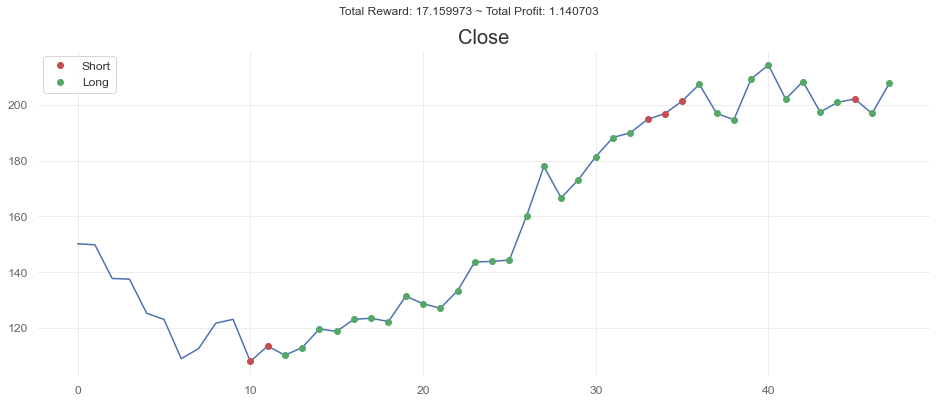

In [27]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


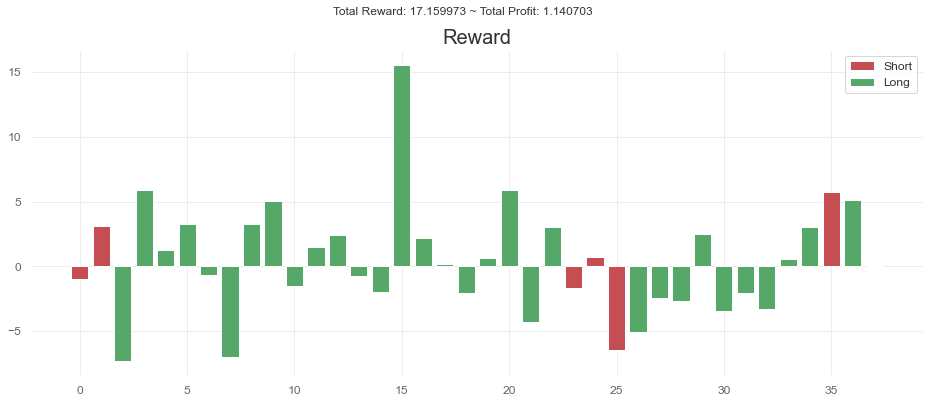

In [28]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


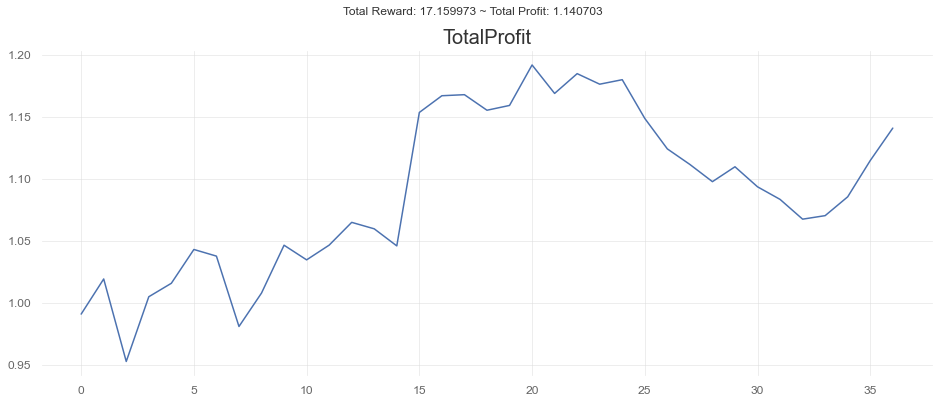

In [29]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [16]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)

目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數
注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]


第一個數字：大括號
第二個數字：有四個打橫
第三個數字：打橫入面有幾多個數字
(1, 4, 6)
[[[1 2 3 4 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]]] 

第一個數字：有幾多大組嘅數字
第二個數字：入面有幾多個小組
第三個數字：每個小組入面有幾多個數字
(4, 3, 2)
[[[1 2]
  [3 4]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]]
